In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/PEDIATRIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=82.6, y0=133.5, x1=94.0, y1=145.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 61
Page 1, Q1, A: Yellow percentage: 0.0%


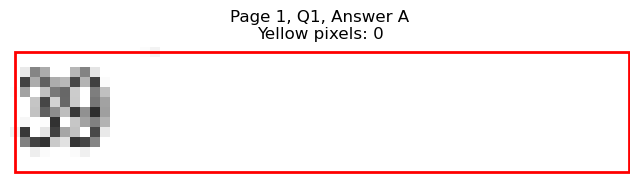

Page 1, Q1 - B: Detected box: x0=71.3, y0=145.6, x1=93.2, y1=157.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 101
Page 1, Q1, B: Yellow percentage: 0.0%


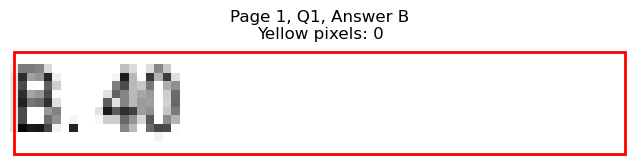

Page 1, Q1 - C: Detected box: x0=71.3, y0=157.6, x1=94.0, y1=169.6
Page 1, Q1, C: Yellow pixels: 184
Page 1, Q1, C: Total non-white pixels: 273
Page 1, Q1, C: Yellow percentage: 67.4%


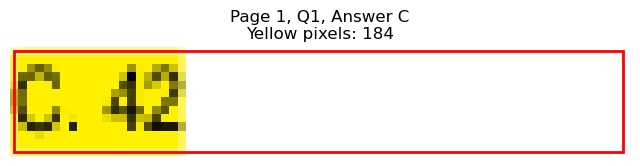

Page 1, Q1 - D: Detected box: x0=322.9, y0=133.5, x1=345.5, y1=145.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 101
Page 1, Q1, D: Yellow percentage: 0.0%


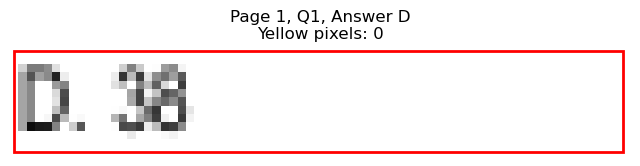

Page 1, Q1 - E: Detected box: x0=322.9, y0=145.6, x1=344.8, y1=157.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 86
Page 1, Q1, E: Yellow percentage: 0.0%


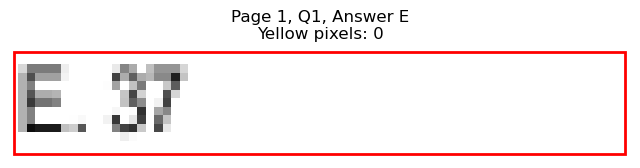


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=102.3, y1=205.6
Page 1, Q2, A: Yellow pixels: 125
Page 1, Q2, A: Total non-white pixels: 236
Page 1, Q2, A: Yellow percentage: 53.0%


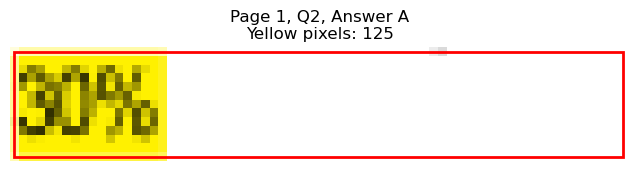

Page 1, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=101.5, y1=217.7
Page 1, Q2, B: Yellow pixels: 17
Page 1, Q2, B: Total non-white pixels: 156
Page 1, Q2, B: Yellow percentage: 10.9%


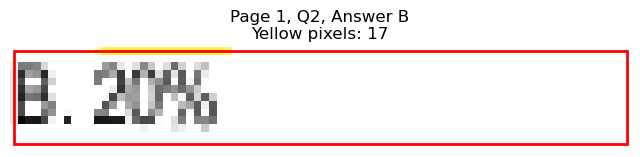

Page 1, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=102.2, y1=229.7
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 121
Page 1, Q2, C: Yellow percentage: 0.0%


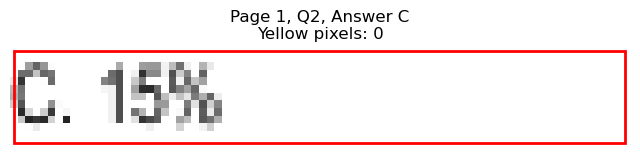

Page 1, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=353.8, y1=205.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 131
Page 1, Q2, D: Yellow percentage: 0.0%


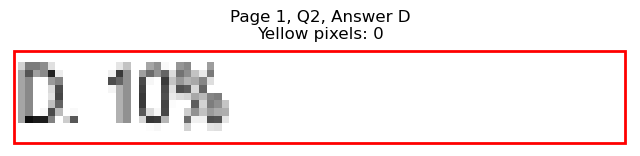

Page 1, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=348.5, y1=217.7
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 110
Page 1, Q2, E: Yellow percentage: 0.0%


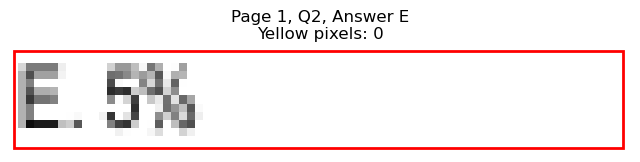


Page 1, Q2 - Selected Answer: A (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=184.7, y1=265.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 501
Page 1, Q3, A: Yellow percentage: 0.0%


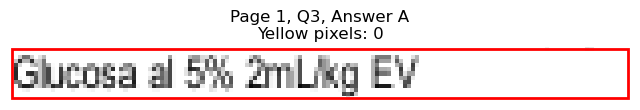

Page 1, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=189.9, y1=277.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 550
Page 1, Q3, B: Yellow percentage: 0.0%


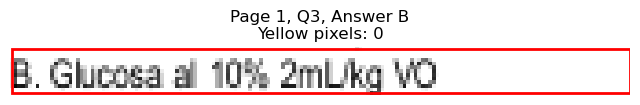

Page 1, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=185.4, y1=289.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 533
Page 1, Q3, C: Yellow percentage: 0.0%


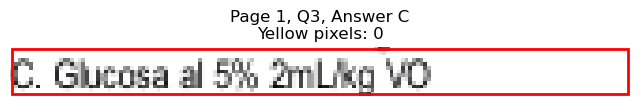

Page 1, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=440.9, y1=265.7
Page 1, Q3, D: Yellow pixels: 967
Page 1, Q3, D: Total non-white pixels: 1521
Page 1, Q3, D: Yellow percentage: 63.6%


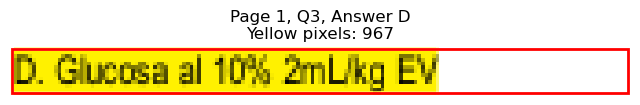

Page 1, Q3 - E: Detected box: x0=385.1, y0=265.7, x1=455.7, y1=277.7
Page 1, Q3, E: Yellow pixels: 54
Page 1, Q3, E: Total non-white pixels: 402
Page 1, Q3, E: Yellow percentage: 13.4%


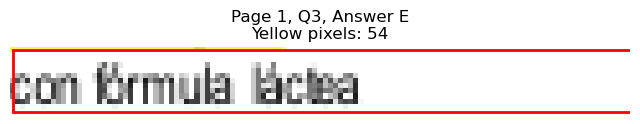


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=94.0, y1=338.5
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 48
Page 1, Q4, A: Yellow percentage: 0.0%


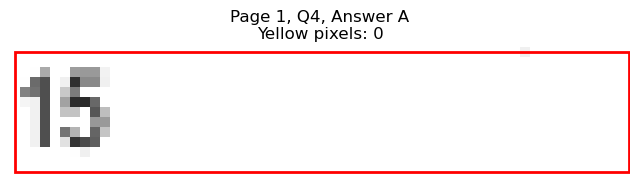

Page 1, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=93.2, y1=350.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 101
Page 1, Q4, B: Yellow percentage: 0.0%


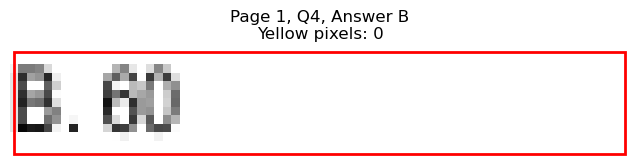

Page 1, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=94.0, y1=362.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 89
Page 1, Q4, C: Yellow percentage: 0.0%


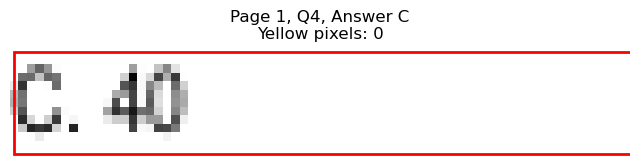

Page 1, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=345.5, y1=338.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 94
Page 1, Q4, D: Yellow percentage: 0.0%


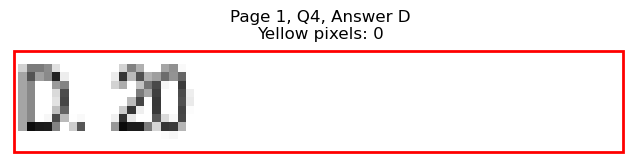

Page 1, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=344.8, y1=350.5
Page 1, Q4, E: Yellow pixels: 179
Page 1, Q4, E: Total non-white pixels: 273
Page 1, Q4, E: Yellow percentage: 65.6%


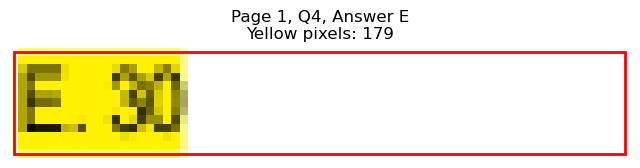


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=136.7, y1=398.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 287
Page 1, Q5, A: Yellow percentage: 0.0%


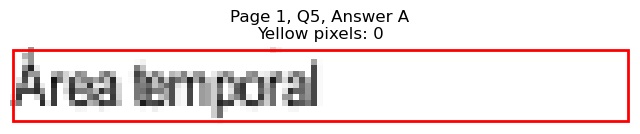

Page 1, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=146.5, y1=410.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 358
Page 1, Q5, B: Yellow percentage: 0.0%


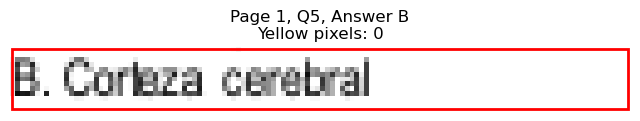

Page 1, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=125.5, y1=422.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 251
Page 1, Q5, C: Yellow percentage: 0.0%


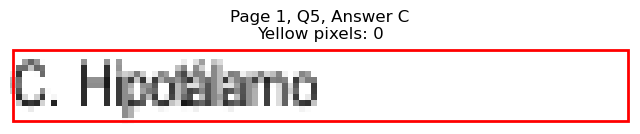

Page 1, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=401.9, y1=398.6
Page 1, Q5, D: Yellow pixels: 607
Page 1, Q5, D: Total non-white pixels: 1014
Page 1, Q5, D: Yellow percentage: 59.9%


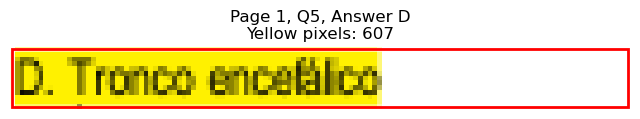

Page 1, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=385.3, y1=410.6
Page 1, Q5, E: Yellow pixels: 75
Page 1, Q5, E: Total non-white pixels: 386
Page 1, Q5, E: Yellow percentage: 19.4%


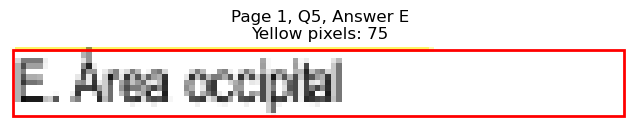


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=130.6, y0=470.6, x1=218.7, y1=482.6
Page 1, Q6, A: Yellow pixels: 666
Page 1, Q6, A: Total non-white pixels: 1131
Page 1, Q6, A: Yellow percentage: 58.9%


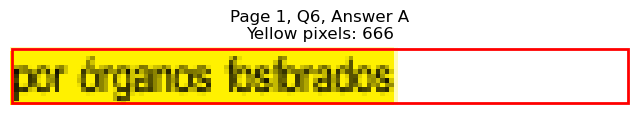

Page 1, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=117.2, y1=495.4
Page 1, Q6, B: Yellow pixels: 85
Page 1, Q6, B: Total non-white pixels: 331
Page 1, Q6, B: Yellow percentage: 25.7%


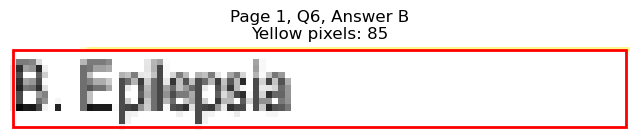

Page 1, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=165.2, y1=507.4
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 467
Page 1, Q6, C: Yellow percentage: 0.0%


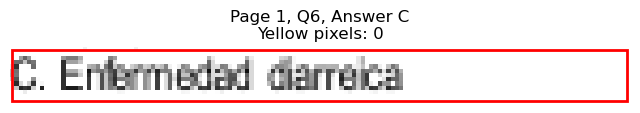

Page 1, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=379.4, y1=482.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 486
Page 1, Q6, D: Yellow percentage: 0.0%


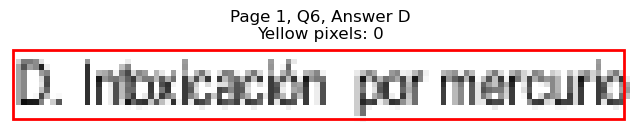

Page 1, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=378.5, y1=495.4
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 465
Page 1, Q6, E: Yellow percentage: 0.0%


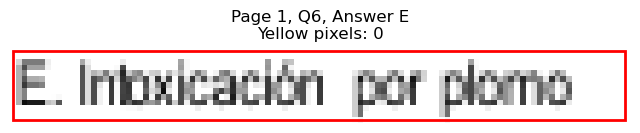


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=238.9, y1=555.5
Page 1, Q7, A: Yellow pixels: 1392
Page 1, Q7, A: Total non-white pixels: 2015
Page 1, Q7, A: Yellow percentage: 69.1%


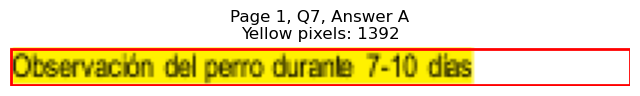

Page 1, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=211.7, y1=567.5
Page 1, Q7, B: Yellow pixels: 153
Page 1, Q7, B: Total non-white pixels: 825
Page 1, Q7, B: Yellow percentage: 18.5%


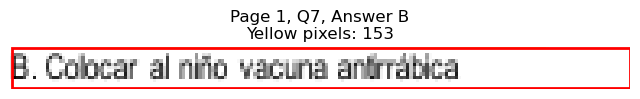

Page 1, Q7 - C: Detected box: x0=71.3, y0=567.5, x1=208.7, y1=579.5
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 645
Page 1, Q7, C: Yellow percentage: 0.0%


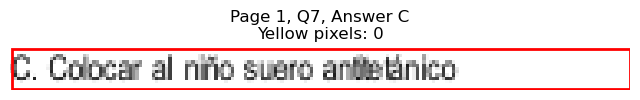

Page 1, Q7 - D: Detected box: x0=322.9, y0=543.4, x1=403.2, y1=555.5
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 391
Page 1, Q7, D: Yellow percentage: 0.0%


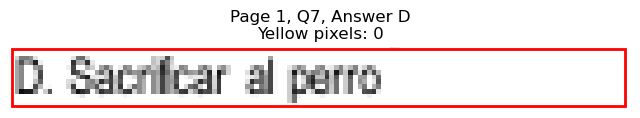

Page 1, Q7 - E: Detected box: x0=322.9, y0=555.4, x1=479.7, y1=567.5
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 704
Page 1, Q7, E: Yellow percentage: 0.0%


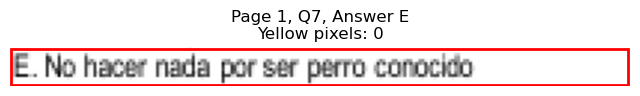


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.6, y0=615.5, x1=113.5, y1=627.5
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 147
Page 1, Q8, A: Yellow percentage: 0.0%


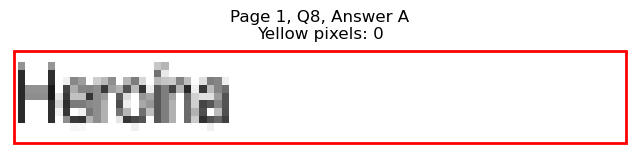

Page 1, Q8 - B: Detected box: x0=71.3, y0=627.5, x1=142.7, y1=639.6
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 369
Page 1, Q8, B: Yellow percentage: 0.0%


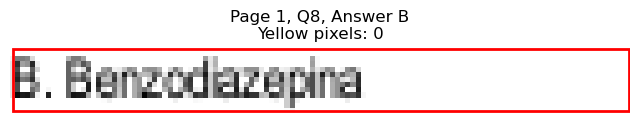

Page 1, Q8 - C: Detected box: x0=71.3, y0=639.5, x1=112.0, y1=651.6
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 175
Page 1, Q8, C: Yellow percentage: 0.0%


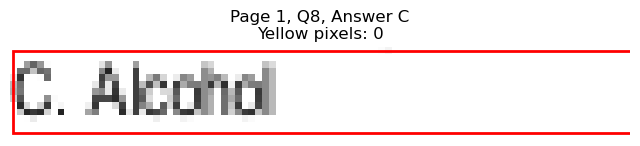

Page 1, Q8 - D: Detected box: x0=322.9, y0=615.5, x1=366.6, y1=627.5
Page 1, Q8, D: Yellow pixels: 363
Page 1, Q8, D: Total non-white pixels: 559
Page 1, Q8, D: Yellow percentage: 64.9%


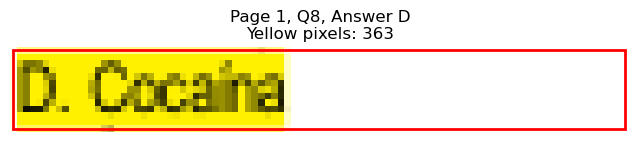

Page 1, Q8 - E: Detected box: x0=322.9, y0=627.5, x1=396.5, y1=639.6
Page 1, Q8, E: Yellow pixels: 40
Page 1, Q8, E: Total non-white pixels: 427
Page 1, Q8, E: Yellow percentage: 9.4%


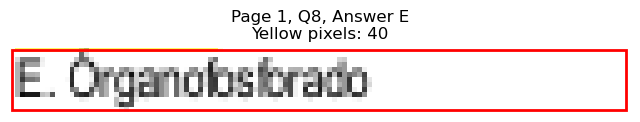


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=82.6, y0=688.3, x1=125.5, y1=700.3
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 225
Page 1, Q9, A: Yellow percentage: 0.0%


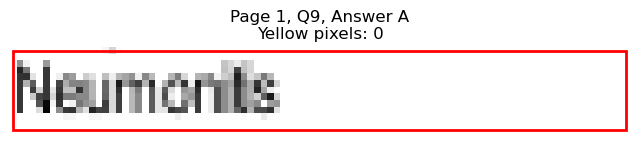

Page 1, Q9 - B: Detected box: x0=71.3, y0=700.3, x1=106.7, y1=712.3
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 172
Page 1, Q9, B: Yellow percentage: 0.0%


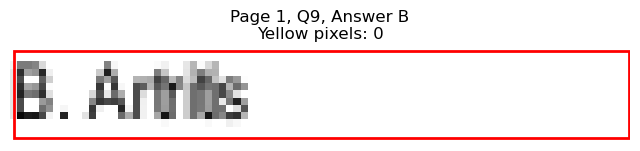

Page 1, Q9 - C: Detected box: x0=71.3, y0=712.3, x1=182.6, y1=724.4
Page 1, Q9, C: Yellow pixels: 874
Page 1, Q9, C: Total non-white pixels: 1430
Page 1, Q9, C: Yellow percentage: 61.1%


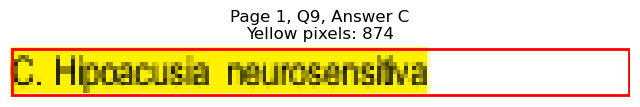

Page 1, Q9 - D: Detected box: x0=322.9, y0=688.3, x1=404.0, y1=700.3
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 392
Page 1, Q9, D: Yellow percentage: 0.0%


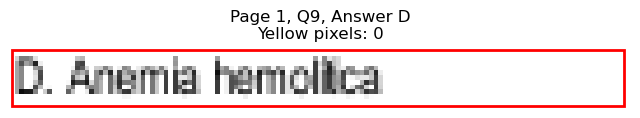

Page 1, Q9 - E: Detected box: x0=322.9, y0=700.3, x1=387.5, y1=712.3
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 321
Page 1, Q9, E: Yellow percentage: 0.0%


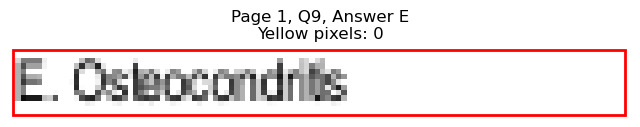


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=82.6, y0=748.4, x1=149.5, y1=760.4
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 336
Page 1, Q10, A: Yellow percentage: 0.0%


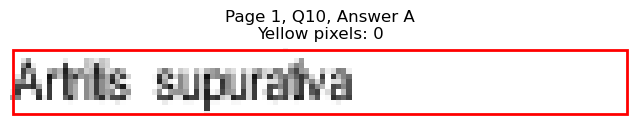

Page 1, Q10 - B: Detected box: x0=71.3, y0=760.4, x1=144.3, y1=772.4
Page 1, Q10, B: Yellow pixels: 620
Page 1, Q10, B: Total non-white pixels: 923
Page 1, Q10, B: Yellow percentage: 67.2%


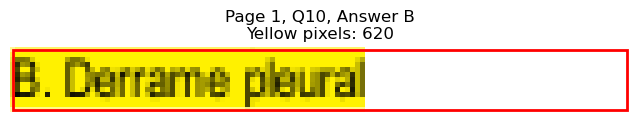

Page 1, Q10 - C: Detected box: x0=71.3, y0=772.4, x1=121.7, y1=784.4
Page 1, Q10, C: Yellow pixels: 70
Page 1, Q10, C: Total non-white pixels: 313
Page 1, Q10, C: Yellow percentage: 22.4%


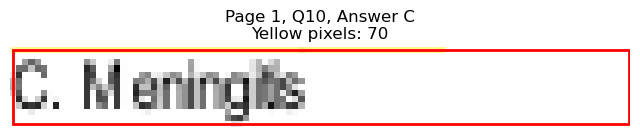

Page 1, Q10 - D: Detected box: x0=322.9, y0=748.4, x1=377.0, y1=760.4
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 263
Page 1, Q10, D: Yellow percentage: 0.0%


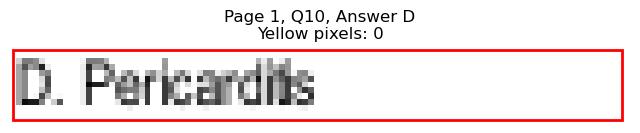

Page 1, Q10 - E: Detected box: x0=322.9, y0=760.4, x1=378.2, y1=772.4
Page 1, Q10, E: Yellow pixels: 0
Page 1, Q10, E: Total non-white pixels: 287
Page 1, Q10, E: Yellow percentage: 0.0%


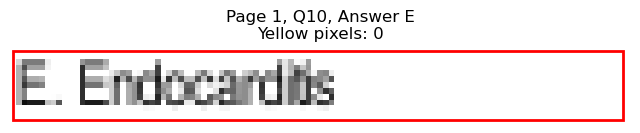


Page 1, Q10 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=149.5, y1=133.6
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 340
Page 2, Q1, A: Yellow percentage: 0.0%


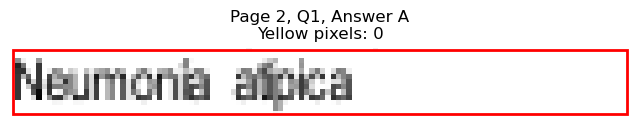

Page 2, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=163.7, y1=145.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 462
Page 2, Q1, B: Yellow percentage: 0.0%


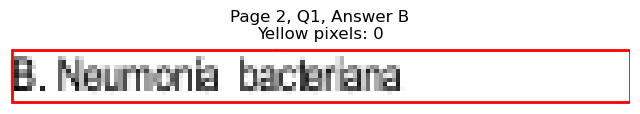

Page 2, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=142.0, y1=157.6
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 318
Page 2, Q1, C: Yellow percentage: 0.0%


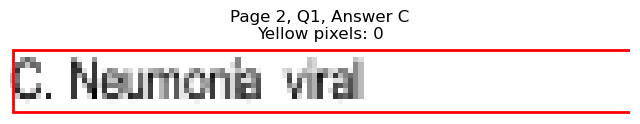

Page 2, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=450.7, y1=133.6
Page 2, Q1, D: Yellow pixels: 1116
Page 2, Q1, D: Total non-white pixels: 1652
Page 2, Q1, D: Yellow percentage: 67.6%


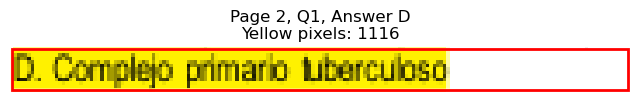

Page 2, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=445.3, y1=145.6
Page 2, Q1, E: Yellow pixels: 125
Page 2, Q1, E: Total non-white pixels: 723
Page 2, Q1, E: Yellow percentage: 17.3%


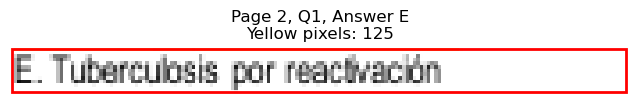


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=130.7, y1=205.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 256
Page 2, Q2, A: Yellow percentage: 0.0%


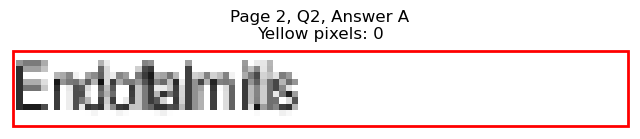

Page 2, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=111.2, y1=217.7
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 419
Page 2, Q2, B: Yellow percentage: 0.0%


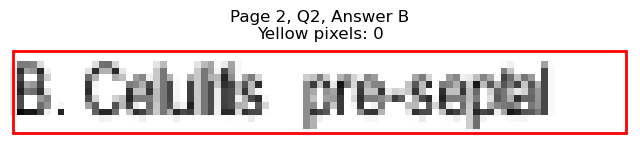

Page 2, Q2 - C: Detected box: x0=114.8, y0=217.6, x1=156.3, y1=229.7
Page 2, Q2, C: Yellow pixels: 301
Page 2, Q2, C: Total non-white pixels: 520
Page 2, Q2, C: Yellow percentage: 57.9%


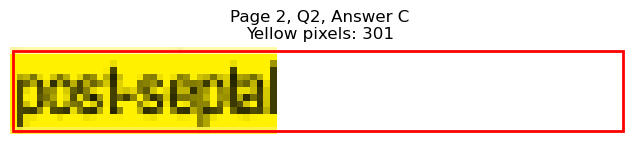

Page 2, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=386.0, y1=205.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 330
Page 2, Q2, D: Yellow percentage: 0.0%


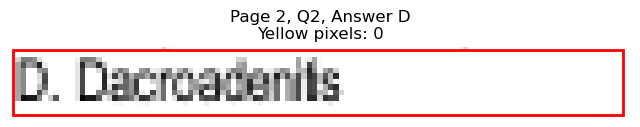

Page 2, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=407.8, y1=217.7
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 457
Page 2, Q2, E: Yellow percentage: 0.0%


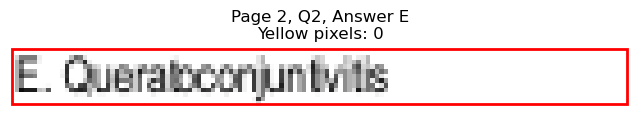


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=162.2, y1=265.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 381
Page 2, Q3, A: Yellow percentage: 0.0%


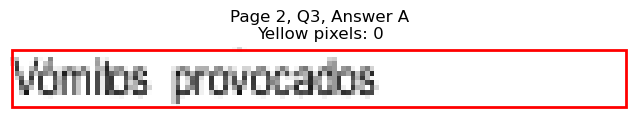

Page 2, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=142.7, y1=277.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 361
Page 2, Q3, B: Yellow percentage: 0.0%


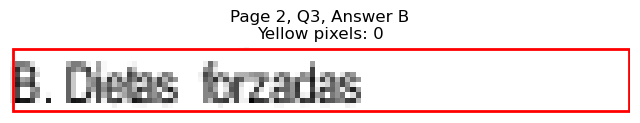

Page 2, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=122.5, y1=289.7
Page 2, Q3, C: Yellow pixels: 406
Page 2, Q3, C: Total non-white pixels: 650
Page 2, Q3, C: Yellow percentage: 62.5%


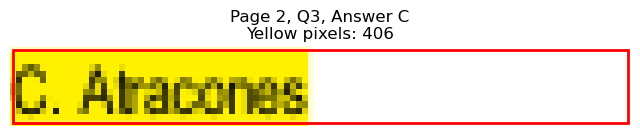

Page 2, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=449.8, y1=265.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 619
Page 2, Q3, D: Yellow percentage: 0.0%


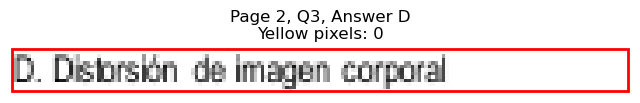

Page 2, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=376.3, y1=277.7
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 265
Page 2, Q3, E: Yellow percentage: 0.0%


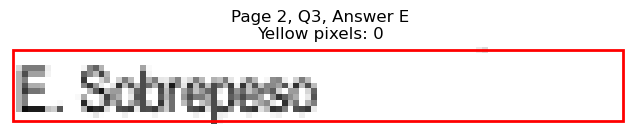


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.6, y0=338.5, x1=154.0, y1=350.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 345
Page 2, Q4, A: Yellow percentage: 0.0%


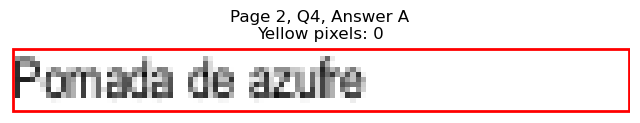

Page 2, Q4 - B: Detected box: x0=71.3, y0=350.5, x1=160.7, y1=362.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 422
Page 2, Q4, B: Yellow percentage: 0.0%


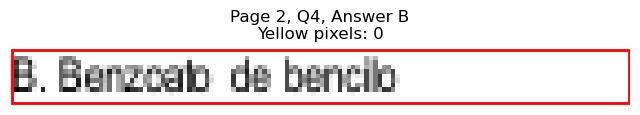

Page 2, Q4 - C: Detected box: x0=71.3, y0=362.5, x1=177.2, y1=374.6
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 474
Page 2, Q4, C: Yellow percentage: 0.0%


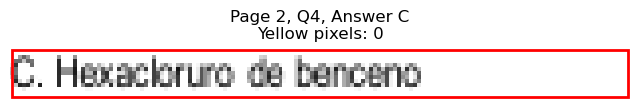

Page 2, Q4 - D: Detected box: x0=322.9, y0=338.5, x1=377.1, y1=350.5
Page 2, Q4, D: Yellow pixels: 464
Page 2, Q4, D: Total non-white pixels: 689
Page 2, Q4, D: Yellow percentage: 67.3%


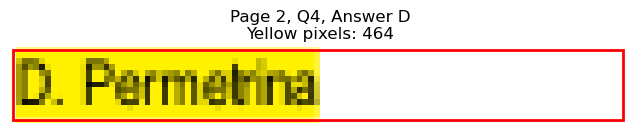

Page 2, Q4 - E: Detected box: x0=322.9, y0=350.5, x1=389.8, y1=362.5
Page 2, Q4, E: Yellow pixels: 52
Page 2, Q4, E: Total non-white pixels: 600
Page 2, Q4, E: Yellow percentage: 8.7%


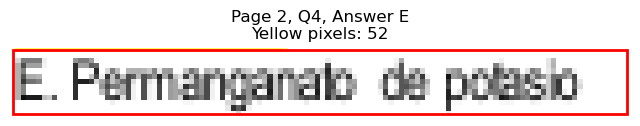


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.6, y0=398.5, x1=130.0, y1=410.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 232
Page 2, Q5, A: Yellow percentage: 0.0%


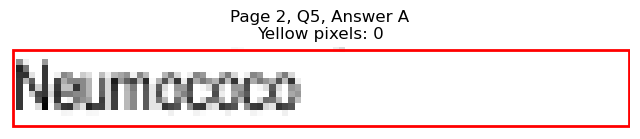

Page 2, Q5 - B: Detected box: x0=71.3, y0=410.5, x1=180.2, y1=422.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 559
Page 2, Q5, B: Yellow percentage: 0.0%


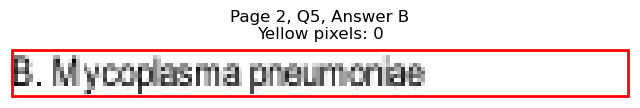

Page 2, Q5 - C: Detected box: x0=71.3, y0=422.5, x1=119.5, y1=434.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 208
Page 2, Q5, C: Yellow percentage: 0.0%


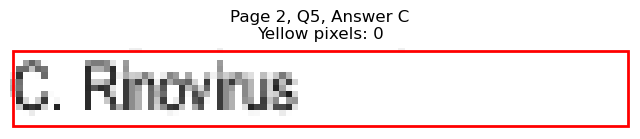

Page 2, Q5 - D: Detected box: x0=322.9, y0=398.5, x1=425.1, y1=410.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 512
Page 2, Q5, D: Yellow percentage: 0.0%


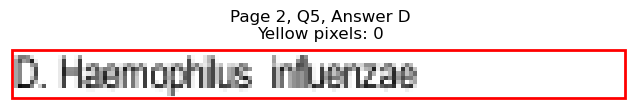

Page 2, Q5 - E: Detected box: x0=322.9, y0=410.5, x1=383.0, y1=422.6
Page 2, Q5, E: Yellow pixels: 824
Page 2, Q5, E: Total non-white pixels: 1365
Page 2, Q5, E: Yellow percentage: 60.4%


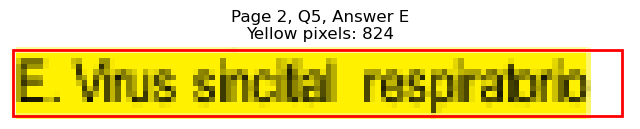


Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=147.2, y1=470.6
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 309
Page 2, Q6, A: Yellow percentage: 0.0%


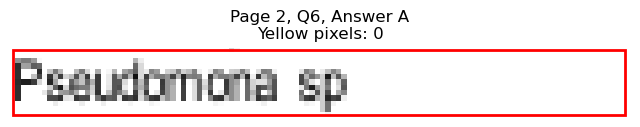

Page 2, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=143.6, y1=482.6
Page 2, Q6, B: Yellow pixels: 566
Page 2, Q6, B: Total non-white pixels: 923
Page 2, Q6, B: Yellow percentage: 61.3%


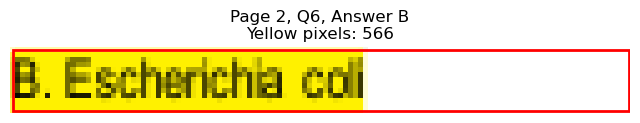

Page 2, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=169.7, y1=495.4
Page 2, Q6, C: Yellow pixels: 69
Page 2, Q6, C: Total non-white pixels: 558
Page 2, Q6, C: Yellow percentage: 12.4%


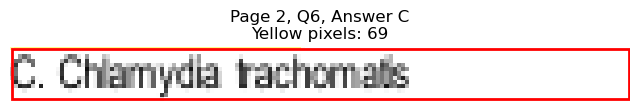

Page 2, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=424.3, y1=470.6
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 501
Page 2, Q6, D: Yellow percentage: 0.0%


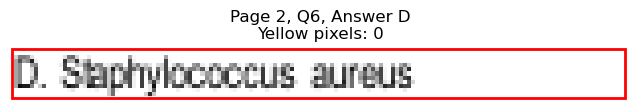

Page 2, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=417.5, y1=482.6
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 460
Page 2, Q6, E: Yellow percentage: 0.0%


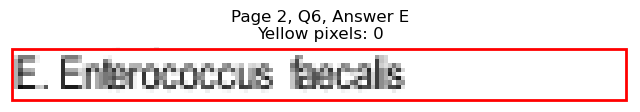


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.6, y0=531.4, x1=131.5, y1=543.5
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 352
Page 2, Q7, A: Yellow percentage: 0.0%


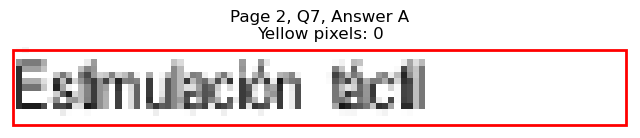

Page 2, Q7 - B: Detected box: x0=71.3, y0=543.4, x1=121.0, y1=555.5
Page 2, Q7, B: Yellow pixels: 869
Page 2, Q7, B: Total non-white pixels: 1300
Page 2, Q7, B: Yellow percentage: 66.8%


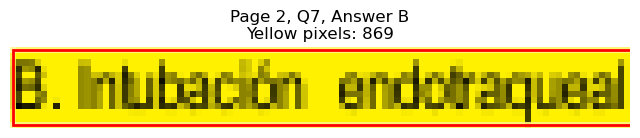

Page 2, Q7 - C: Detected box: x0=71.3, y0=555.4, x1=148.0, y1=567.5
Page 2, Q7, C: Yellow pixels: 126
Page 2, Q7, C: Total non-white pixels: 498
Page 2, Q7, C: Yellow percentage: 25.3%


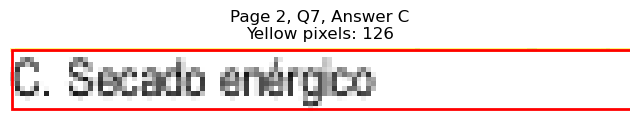

Page 2, Q7 - D: Detected box: x0=322.9, y0=531.4, x1=436.3, y1=543.5
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 537
Page 2, Q7, D: Yellow percentage: 0.0%


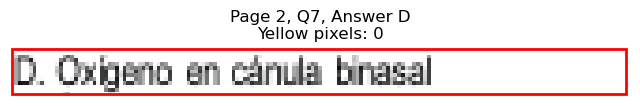

Page 2, Q7 - E: Detected box: x0=322.9, y0=543.4, x1=381.6, y1=555.5
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 453
Page 2, Q7, E: Yellow percentage: 0.0%


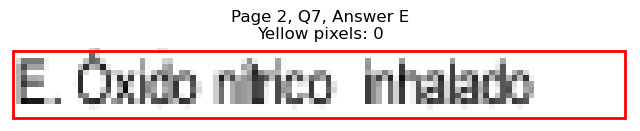


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=615.5, x1=127.8, y1=627.5
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 377
Page 2, Q8, A: Yellow percentage: 0.0%


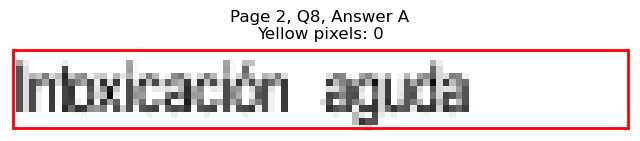

Page 2, Q8 - B: Detected box: x0=71.3, y0=627.5, x1=148.7, y1=639.6
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 369
Page 2, Q8, B: Yellow percentage: 0.0%


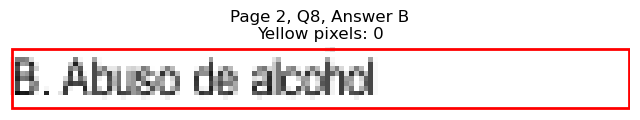

Page 2, Q8 - C: Detected box: x0=71.3, y0=639.5, x1=167.6, y1=651.6
Page 2, Q8, C: Yellow pixels: 839
Page 2, Q8, C: Total non-white pixels: 1235
Page 2, Q8, C: Yellow percentage: 67.9%


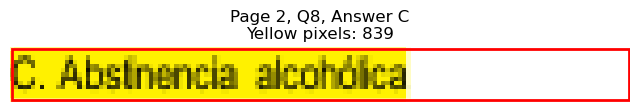

Page 2, Q8 - D: Detected box: x0=322.9, y0=615.5, x1=385.3, y1=627.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 522
Page 2, Q8, D: Yellow percentage: 0.0%


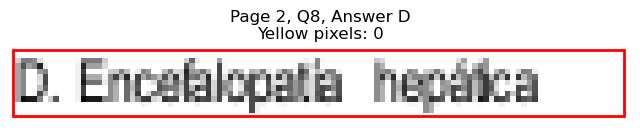

Page 2, Q8 - E: Detected box: x0=322.9, y0=627.5, x1=423.5, y1=639.6
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 486
Page 2, Q8, E: Yellow percentage: 0.0%


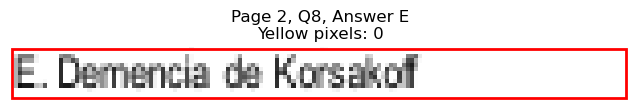


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=148.8, y1=712.3
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 348
Page 2, Q9, A: Yellow percentage: 0.0%


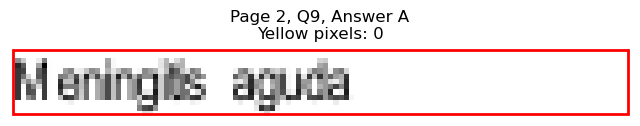

Page 2, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=169.1, y1=724.4
Page 2, Q9, B: Yellow pixels: 768
Page 2, Q9, B: Total non-white pixels: 1248
Page 2, Q9, B: Yellow percentage: 61.5%


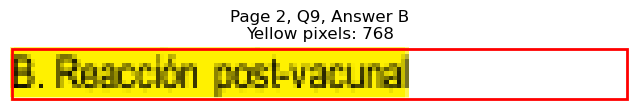

Page 2, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=121.0, y1=736.4
Page 2, Q9, C: Yellow pixels: 1
Page 2, Q9, C: Total non-white pixels: 469
Page 2, Q9, C: Yellow percentage: 0.2%


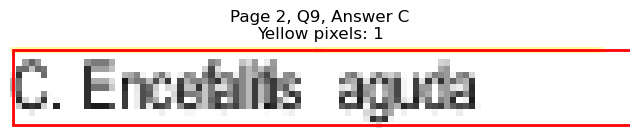

Page 2, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=413.1, y1=712.3
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 434
Page 2, Q9, D: Yellow percentage: 0.0%


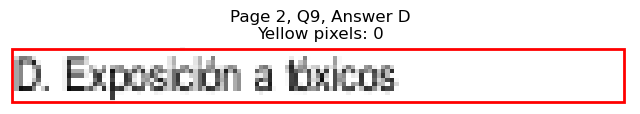

Page 2, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=402.6, y1=724.4
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 395
Page 2, Q9, E: Yellow percentage: 0.0%


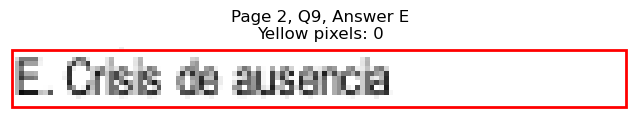


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=139.1, y1=121.6
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 305
Page 3, Q1, A: Yellow percentage: 0.0%


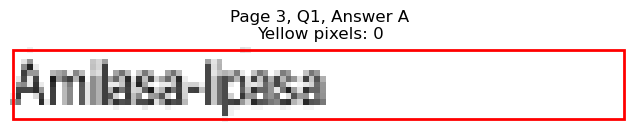

Page 3, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=179.5, y1=133.6
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 561
Page 3, Q1, B: Yellow percentage: 0.0%


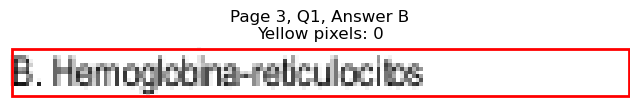

Page 3, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=120.3, y1=145.6
Page 3, Q1, C: Yellow pixels: 402
Page 3, Q1, C: Total non-white pixels: 611
Page 3, Q1, C: Yellow percentage: 65.8%


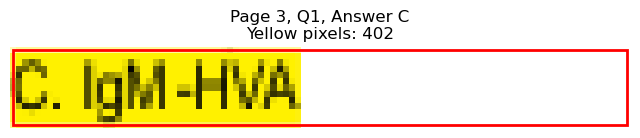

Page 3, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=394.4, y1=121.6
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 346
Page 3, Q1, D: Yellow percentage: 0.0%


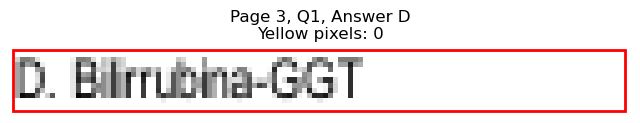

Page 3, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=415.4, y1=133.6
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 470
Page 3, Q1, E: Yellow percentage: 0.0%


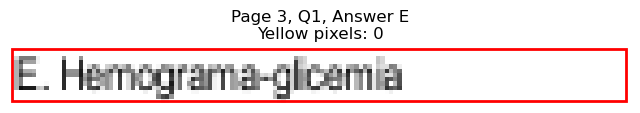


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=116.5, y1=181.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 170
Page 3, Q2, A: Yellow percentage: 0.0%


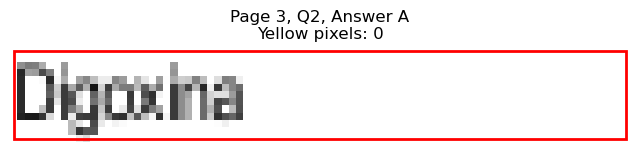

Page 3, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=126.2, y1=193.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 286
Page 3, Q2, B: Yellow percentage: 0.0%


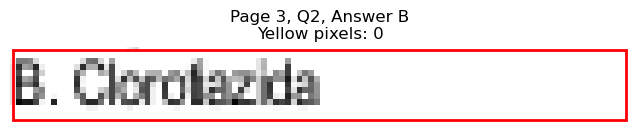

Page 3, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=143.5, y1=205.6
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 346
Page 3, Q2, C: Yellow percentage: 0.0%


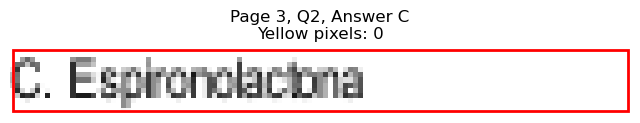

Page 3, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=380.9, y1=181.6
Page 3, Q2, D: Yellow pixels: 442
Page 3, Q2, D: Total non-white pixels: 741
Page 3, Q2, D: Yellow percentage: 59.6%


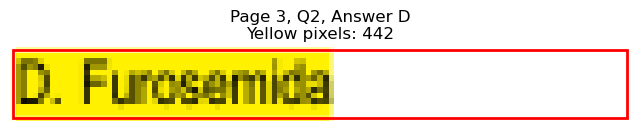

Page 3, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=379.3, y1=193.6
Page 3, Q2, E: Yellow pixels: 55
Page 3, Q2, E: Total non-white pixels: 342
Page 3, Q2, E: Yellow percentage: 16.1%


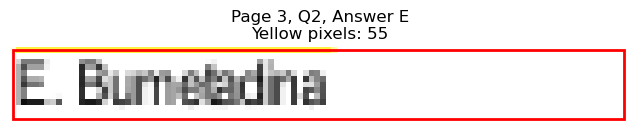


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=161.5, y1=265.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 402
Page 3, Q3, A: Yellow percentage: 0.0%


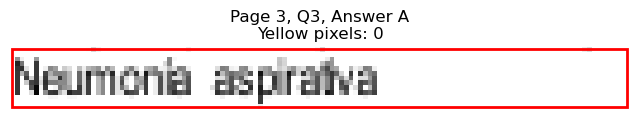

Page 3, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=210.9, y1=277.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 679
Page 3, Q3, B: Yellow percentage: 0.0%


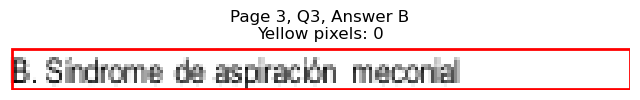

Page 3, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=151.0, y1=289.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 381
Page 3, Q3, C: Yellow percentage: 0.0%


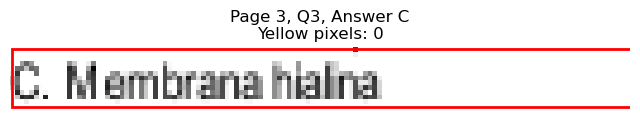

Page 3, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=374.8, y1=265.7
Page 3, Q3, D: Yellow pixels: 706
Page 3, Q3, D: Total non-white pixels: 1183
Page 3, Q3, D: Yellow percentage: 59.7%


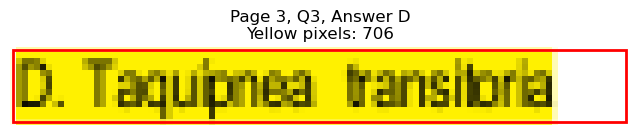

Page 3, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=466.3, y1=277.7
Page 3, Q3, E: Yellow pixels: 89
Page 3, Q3, E: Total non-white pixels: 799
Page 3, Q3, E: Yellow percentage: 11.1%


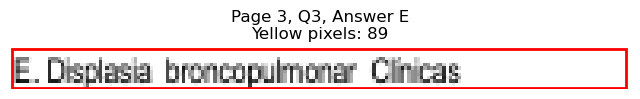


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.6, y0=338.5, x1=124.0, y1=350.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 208
Page 3, Q4, A: Yellow percentage: 0.0%


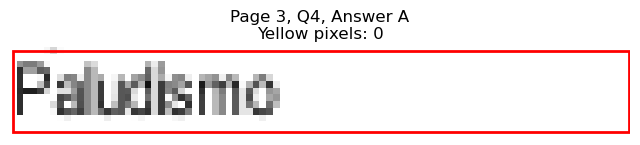

Page 3, Q4 - B: Detected box: x0=71.3, y0=350.5, x1=123.2, y1=362.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 253
Page 3, Q4, B: Yellow percentage: 0.0%


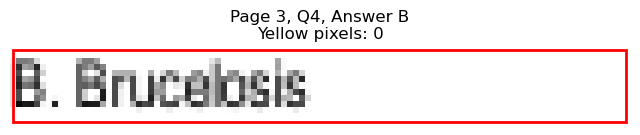

Page 3, Q4 - C: Detected box: x0=71.3, y0=362.5, x1=151.1, y1=374.6
Page 3, Q4, C: Yellow pixels: 697
Page 3, Q4, C: Total non-white pixels: 1014
Page 3, Q4, C: Yellow percentage: 68.7%


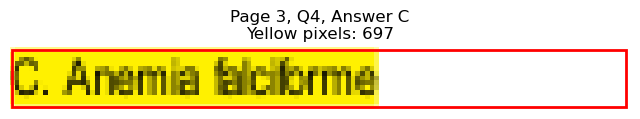

Page 3, Q4 - D: Detected box: x0=322.9, y0=338.5, x1=365.0, y1=350.5
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 205
Page 3, Q4, D: Yellow percentage: 0.0%


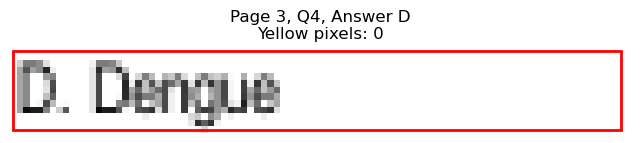

Page 3, Q4 - E: Detected box: x0=322.9, y0=350.5, x1=383.8, y1=362.5
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 288
Page 3, Q4, E: Yellow percentage: 0.0%


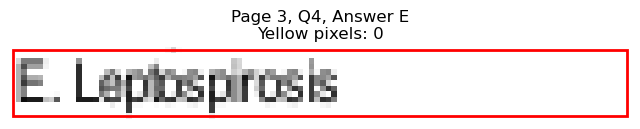


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=145.6, y0=410.5, x1=218.5, y1=422.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 363
Page 3, Q5, A: Yellow percentage: 0.0%


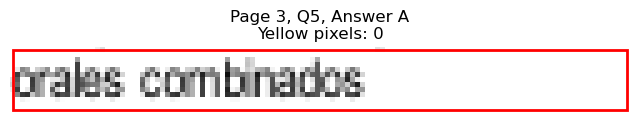

Page 3, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=136.7, y1=434.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 560
Page 3, Q5, B: Yellow percentage: 0.0%


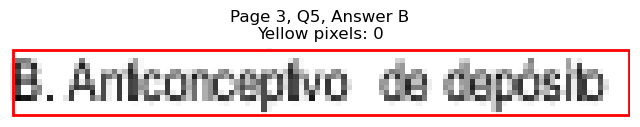

Page 3, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=147.2, y1=446.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 367
Page 3, Q5, C: Yellow percentage: 0.0%


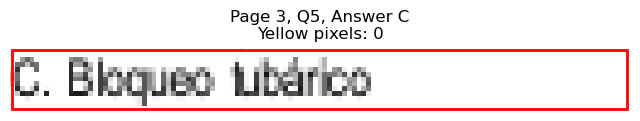

Page 3, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=396.5, y1=422.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 368
Page 3, Q5, D: Yellow percentage: 0.0%


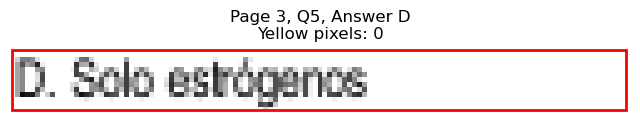

Page 3, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=391.3, y1=434.6
Page 3, Q5, E: Yellow pixels: 784
Page 3, Q5, E: Total non-white pixels: 1300
Page 3, Q5, E: Yellow percentage: 60.3%


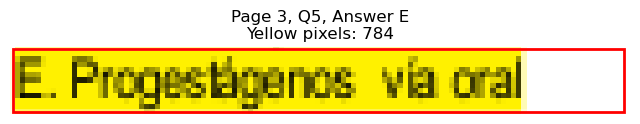


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=139.0, y1=507.4
Page 3, Q6, A: Yellow pixels: 941
Page 3, Q6, A: Total non-white pixels: 1391
Page 3, Q6, A: Yellow percentage: 67.6%


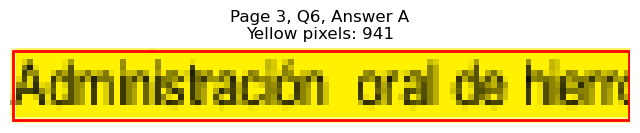

Page 3, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=172.0, y1=519.4
Page 3, Q6, B: Yellow pixels: 108
Page 3, Q6, B: Total non-white pixels: 782
Page 3, Q6, B: Yellow percentage: 13.8%


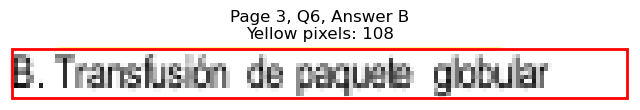

Page 3, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=204.2, y1=531.4
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 658
Page 3, Q6, C: Yellow percentage: 0.0%


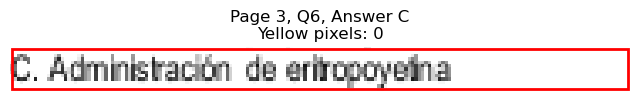

Page 3, Q6 - D: Detected box: x0=381.5, y0=495.4, x1=457.4, y1=507.4
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 384
Page 3, Q6, D: Yellow percentage: 0.0%


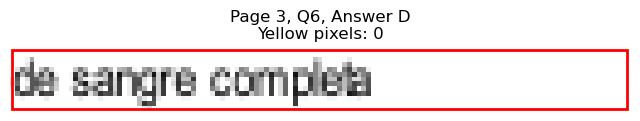

Page 3, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=389.8, y1=519.4
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 599
Page 3, Q6, E: Yellow percentage: 0.0%


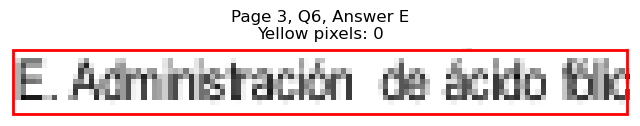


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=567.5, x1=175.0, y1=579.5
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 458
Page 3, Q7, A: Yellow percentage: 0.0%


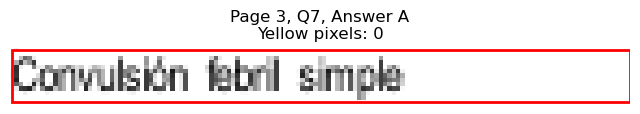

Page 3, Q7 - B: Detected box: x0=71.3, y0=579.4, x1=148.7, y1=591.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 509
Page 3, Q7, B: Yellow percentage: 0.0%


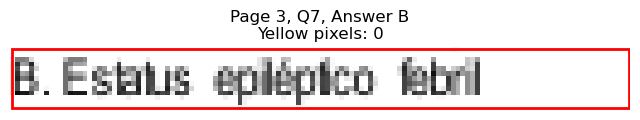

Page 3, Q7 - C: Detected box: x0=71.3, y0=591.5, x1=135.2, y1=603.5
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 303
Page 3, Q7, C: Yellow percentage: 0.0%


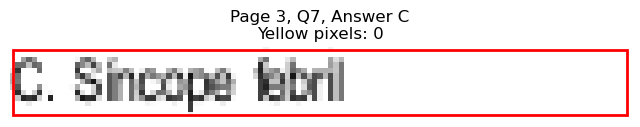

Page 3, Q7 - D: Detected box: x0=322.9, y0=567.5, x1=435.7, y1=579.5
Page 3, Q7, D: Yellow pixels: 972
Page 3, Q7, D: Total non-white pixels: 1456
Page 3, Q7, D: Yellow percentage: 66.8%


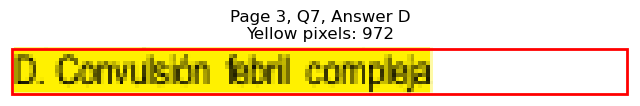

Page 3, Q7 - E: Detected box: x0=322.9, y0=579.4, x1=375.5, y1=591.5
Page 3, Q7, E: Yellow pixels: 103
Page 3, Q7, E: Total non-white pixels: 353
Page 3, Q7, E: Yellow percentage: 29.2%


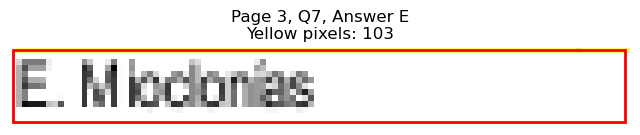


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.6, y0=627.5, x1=112.0, y1=639.6
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 148
Page 3, Q8, A: Yellow percentage: 0.0%


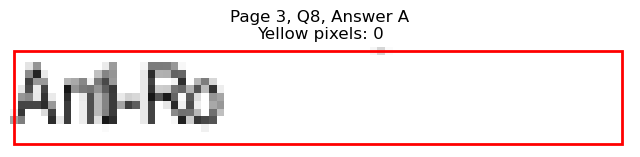

Page 3, Q8 - B: Detected box: x0=71.3, y0=639.5, x1=156.2, y1=651.6
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 422
Page 3, Q8, B: Yellow percentage: 0.0%


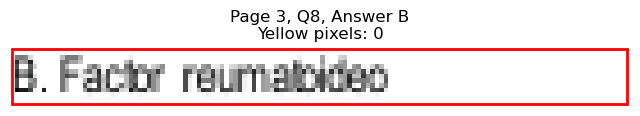

Page 3, Q8 - C: Detected box: x0=71.3, y0=651.5, x1=189.3, y1=663.6
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 583
Page 3, Q8, C: Yellow percentage: 0.0%


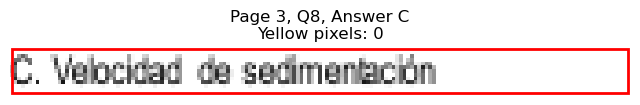

Page 3, Q8 - D: Detected box: x0=322.9, y0=627.5, x1=371.1, y1=639.6
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 232
Page 3, Q8, D: Yellow percentage: 0.0%


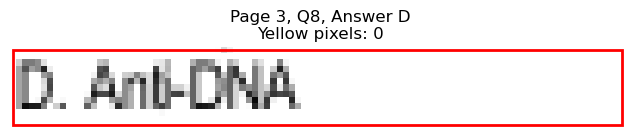

Page 3, Q8 - E: Detected box: x0=322.9, y0=639.5, x1=370.4, y1=651.6
Page 3, Q8, E: Yellow pixels: 402
Page 3, Q8, E: Total non-white pixels: 598
Page 3, Q8, E: Yellow percentage: 67.2%


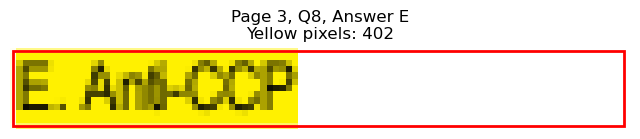


Page 3, Q8 - Selected Answer: E (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=712.3, x1=132.2, y1=724.4
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 258
Page 3, Q9, A: Yellow percentage: 0.0%


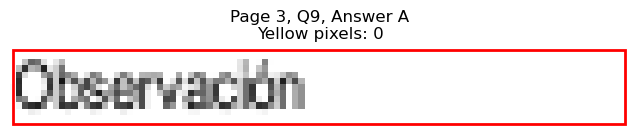

Page 3, Q9 - B: Detected box: x0=71.3, y0=724.3, x1=124.8, y1=736.4
Page 3, Q9, B: Yellow pixels: 407
Page 3, Q9, B: Total non-white pixels: 676
Page 3, Q9, B: Yellow percentage: 60.2%


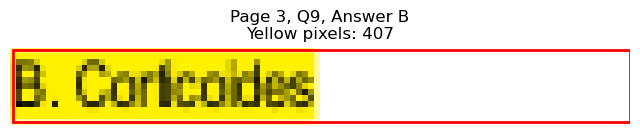

Page 3, Q9 - C: Detected box: x0=71.3, y0=736.4, x1=178.8, y1=748.4
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 569
Page 3, Q9, C: Yellow percentage: 0.0%


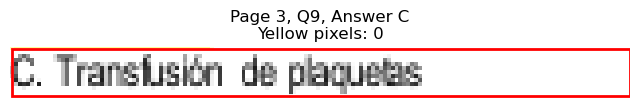

Page 3, Q9 - D: Detected box: x0=322.9, y0=712.3, x1=377.0, y1=724.4
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 280
Page 3, Q9, D: Yellow percentage: 0.0%


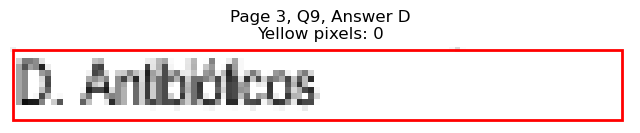

Page 3, Q9 - E: Detected box: x0=322.9, y0=724.3, x1=377.8, y1=736.4
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 257
Page 3, Q9, E: Yellow percentage: 0.0%


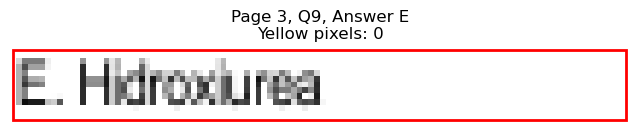


Page 3, Q9 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=142.0, y1=133.6
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 290
Page 4, Q1, A: Yellow percentage: 0.0%


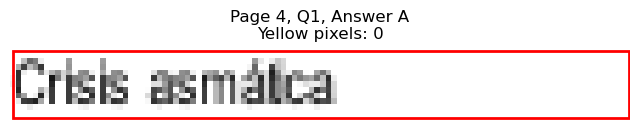

Page 4, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=129.2, y1=145.6
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 292
Page 4, Q1, B: Yellow percentage: 0.0%


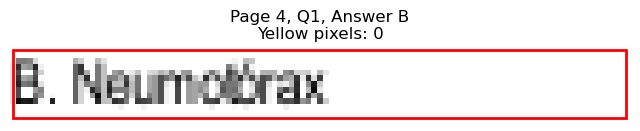

Page 4, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=142.0, y1=157.6
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 318
Page 4, Q1, C: Yellow percentage: 0.0%


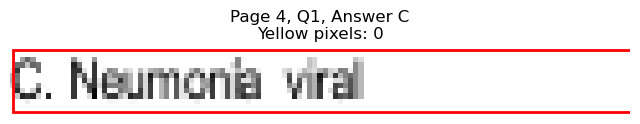

Page 4, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=394.4, y1=133.6
Page 4, Q1, D: Yellow pixels: 610
Page 4, Q1, D: Total non-white pixels: 910
Page 4, Q1, D: Yellow percentage: 67.0%


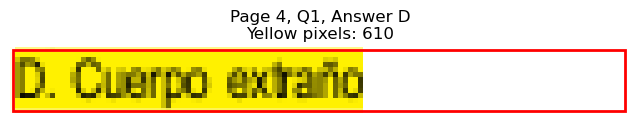

Page 4, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=406.3, y1=145.6
Page 4, Q1, E: Yellow pixels: 69
Page 4, Q1, E: Total non-white pixels: 484
Page 4, Q1, E: Yellow percentage: 14.3%


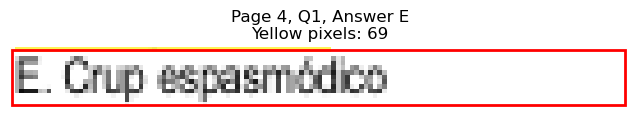


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=160.8, y1=193.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 659
Page 4, Q2, A: Yellow percentage: 0.0%


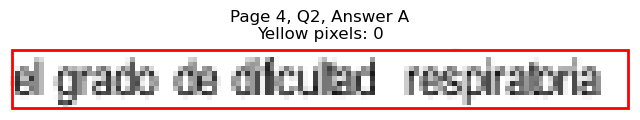

Page 4, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=121.8, y1=205.6
Page 4, Q2, B: Yellow pixels: 372
Page 4, Q2, B: Total non-white pixels: 637
Page 4, Q2, B: Yellow percentage: 58.4%


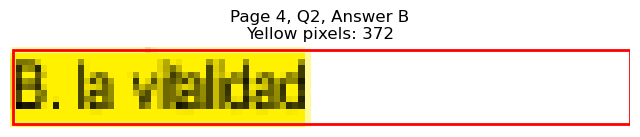

Page 4, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=156.3, y1=217.7
Page 4, Q2, C: Yellow pixels: 48
Page 4, Q2, C: Total non-white pixels: 472
Page 4, Q2, C: Yellow percentage: 10.2%


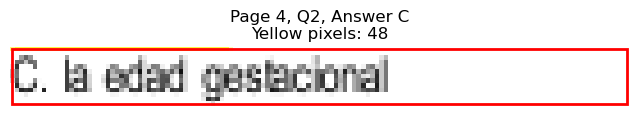

Page 4, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=427.3, y1=193.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 517
Page 4, Q2, D: Yellow percentage: 0.0%


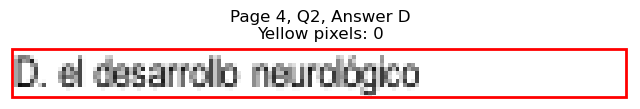

Page 4, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=440.8, y1=205.6
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 565
Page 4, Q2, E: Yellow percentage: 0.0%


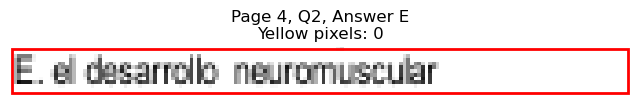


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=142.0, y1=277.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 294
Page 4, Q3, A: Yellow percentage: 0.0%


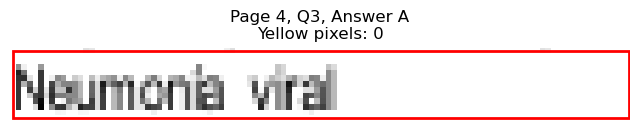

Page 4, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=183.2, y1=289.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 589
Page 4, Q3, B: Yellow percentage: 0.0%


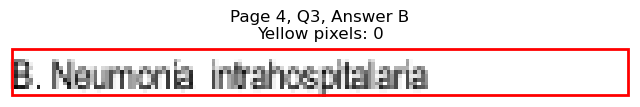

Page 4, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=164.6, y1=301.8
Page 4, Q3, C: Yellow pixels: 735
Page 4, Q3, C: Total non-white pixels: 1196
Page 4, Q3, C: Yellow percentage: 61.5%


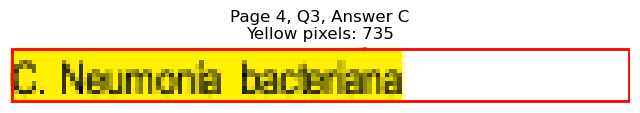

Page 4, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=420.5, y1=277.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 474
Page 4, Q3, D: Yellow percentage: 0.0%


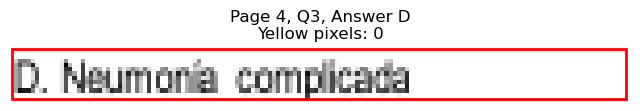

Page 4, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=412.3, y1=289.7
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 432
Page 4, Q3, E: Yellow percentage: 0.0%


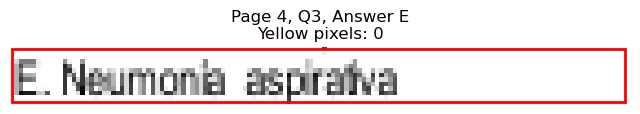


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=92.5, y1=362.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 43
Page 4, Q4, A: Yellow percentage: 0.0%


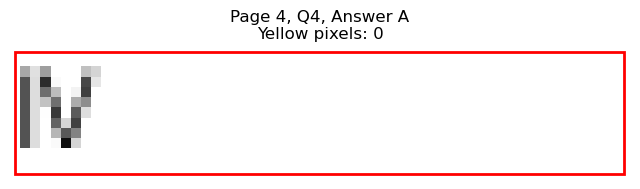

Page 4, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=89.5, y1=374.6
Page 4, Q4, B: Yellow pixels: 158
Page 4, Q4, B: Total non-white pixels: 221
Page 4, Q4, B: Yellow percentage: 71.5%


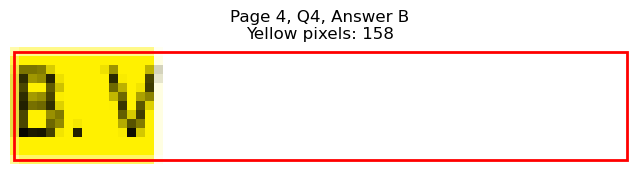

Page 4, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=89.5, y1=386.6
Page 4, Q4, C: Yellow pixels: 16
Page 4, Q4, C: Total non-white pixels: 79
Page 4, Q4, C: Yellow percentage: 20.3%


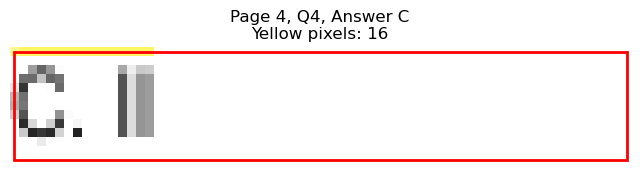

Page 4, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=338.8, y1=362.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 48
Page 4, Q4, D: Yellow percentage: 0.0%


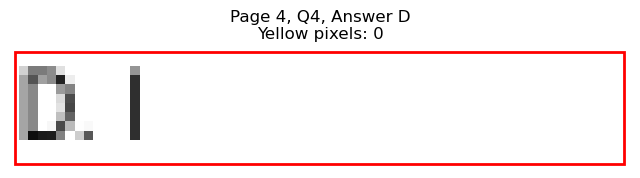

Page 4, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=342.5, y1=374.6
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 85
Page 4, Q4, E: Yellow percentage: 0.0%


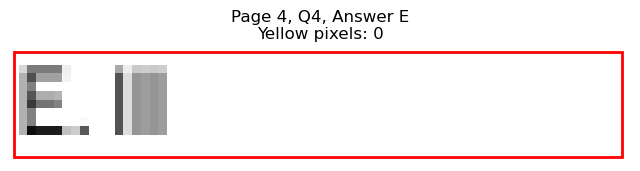


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=121.7, y1=422.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 195
Page 4, Q5, A: Yellow percentage: 0.0%


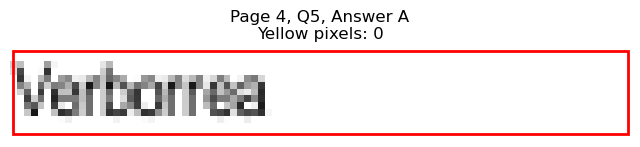

Page 4, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=135.2, y1=434.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 317
Page 4, Q5, B: Yellow percentage: 0.0%


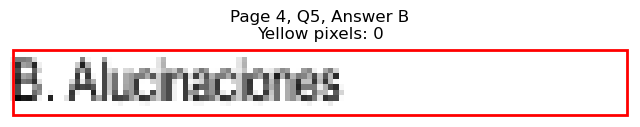

Page 4, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=123.3, y1=446.6
Page 4, Q5, C: Yellow pixels: 377
Page 4, Q5, C: Total non-white pixels: 650
Page 4, Q5, C: Yellow percentage: 58.0%


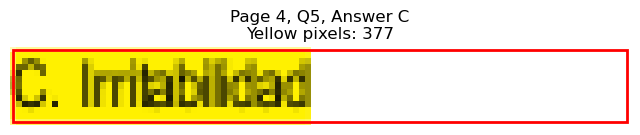

Page 4, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=372.5, y1=422.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 271
Page 4, Q5, D: Yellow percentage: 0.0%


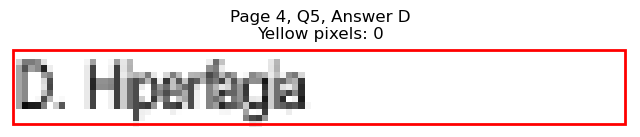

Page 4, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=369.5, y1=434.6
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 209
Page 4, Q5, E: Yellow percentage: 0.0%


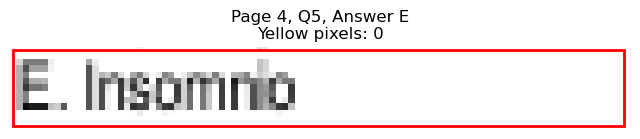


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=125.5, y1=507.4
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 214
Page 4, Q6, A: Yellow percentage: 0.0%


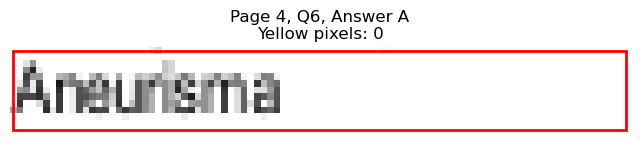

Page 4, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=121.7, y1=519.4
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 249
Page 4, Q6, B: Yellow percentage: 0.0%


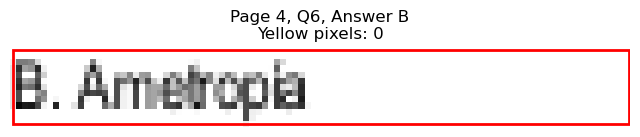

Page 4, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=122.5, y1=531.4
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 234
Page 4, Q6, C: Yellow percentage: 0.0%


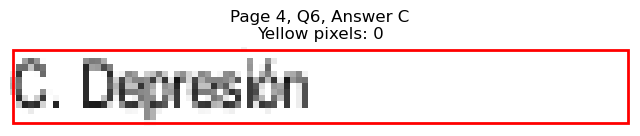

Page 4, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=393.5, y1=507.4
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 317
Page 4, Q6, D: Yellow percentage: 0.0%


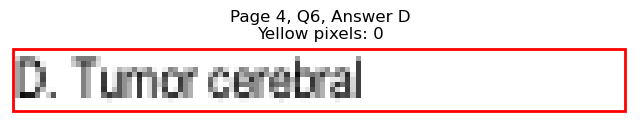

Page 4, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=366.6, y1=519.4
Page 4, Q6, E: Yellow pixels: 355
Page 4, Q6, E: Total non-white pixels: 559
Page 4, Q6, E: Yellow percentage: 63.5%


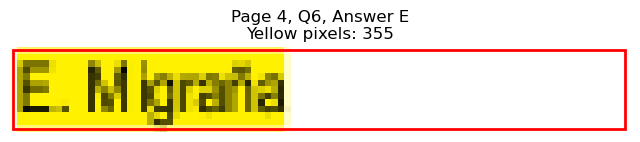


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=71.3, y0=555.4, x1=79.7, y1=567.5
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 62
Page 4, Q7, A: Yellow percentage: 0.0%


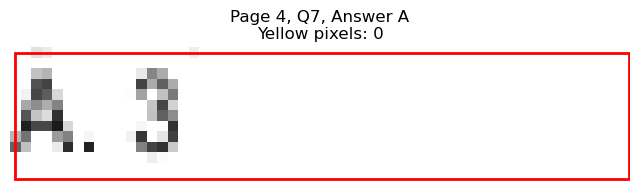

Page 4, Q7 - B: Detected box: x0=71.3, y0=567.5, x1=88.7, y1=579.5
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 71
Page 4, Q7, B: Yellow percentage: 0.0%


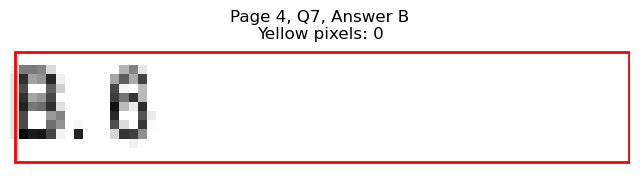

Page 4, Q7 - C: Detected box: x0=71.3, y0=579.4, x1=94.0, y1=591.5
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 79
Page 4, Q7, C: Yellow percentage: 0.0%


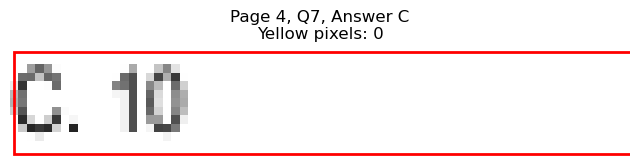

Page 4, Q7 - D: Detected box: x0=322.9, y0=555.4, x1=341.0, y1=567.5
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 69
Page 4, Q7, D: Yellow percentage: 0.0%


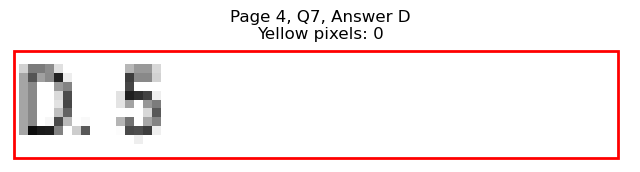

Page 4, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=340.3, y1=579.5
Page 4, Q7, E: Yellow pixels: 142
Page 4, Q7, E: Total non-white pixels: 208
Page 4, Q7, E: Yellow percentage: 68.3%


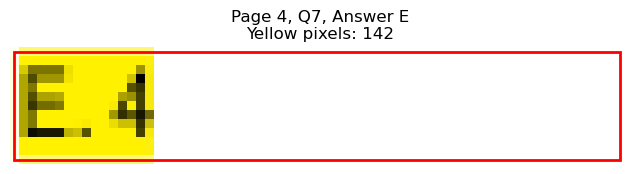


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=615.5, x1=122.5, y1=627.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 209
Page 4, Q8, A: Yellow percentage: 0.0%


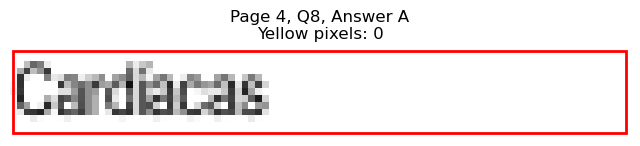

Page 4, Q8 - B: Detected box: x0=71.3, y0=627.5, x1=124.7, y1=639.6
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 269
Page 4, Q8, B: Yellow percentage: 0.0%


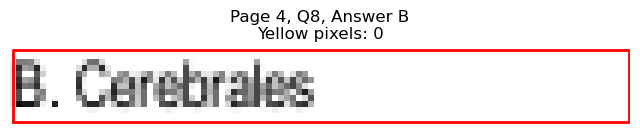

Page 4, Q8 - C: Detected box: x0=71.3, y0=639.5, x1=115.0, y1=651.6
Page 4, Q8, C: Yellow pixels: 372
Page 4, Q8, C: Total non-white pixels: 546
Page 4, Q8, C: Yellow percentage: 68.1%


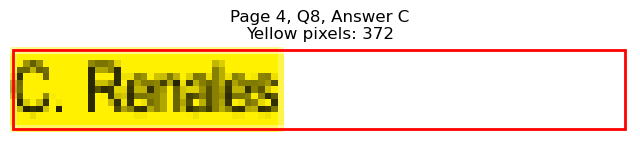

Page 4, Q8 - D: Detected box: x0=322.9, y0=615.5, x1=401.8, y1=627.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 423
Page 4, Q8, D: Yellow percentage: 0.0%


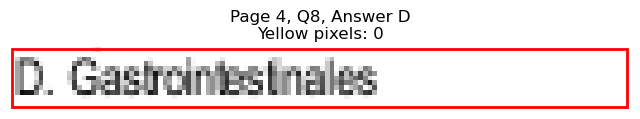

Page 4, Q8 - E: Detected box: x0=322.9, y0=627.5, x1=369.5, y1=639.6
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 217
Page 4, Q8, E: Yellow percentage: 0.0%


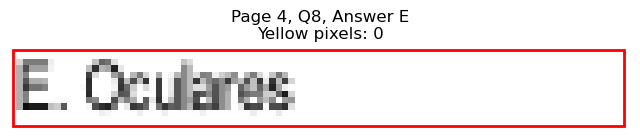


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=71.3, y0=700.3, x1=79.7, y1=712.3
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 64
Page 4, Q9, A: Yellow percentage: 0.0%


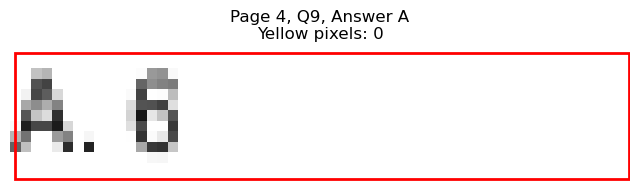

Page 4, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=88.7, y1=724.4
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 71
Page 4, Q9, B: Yellow percentage: 0.0%


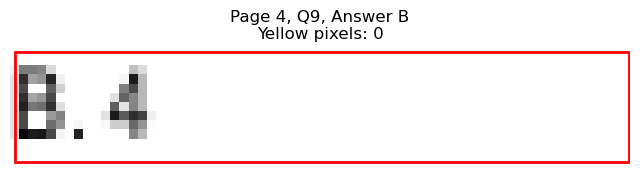

Page 4, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=89.5, y1=736.4
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 57
Page 4, Q9, C: Yellow percentage: 0.0%


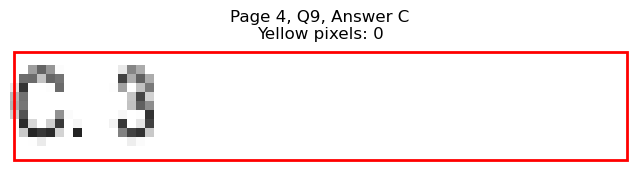

Page 4, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=341.0, y1=712.3
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 74
Page 4, Q9, D: Yellow percentage: 0.0%


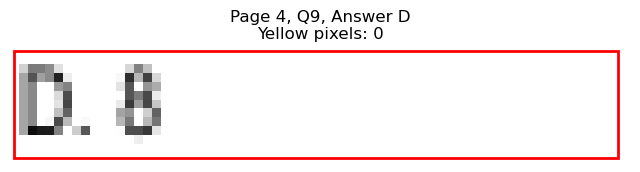

Page 4, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=338.2, y1=724.4
Page 4, Q9, E: Yellow pixels: 124
Page 4, Q9, E: Total non-white pixels: 208
Page 4, Q9, E: Yellow percentage: 59.6%


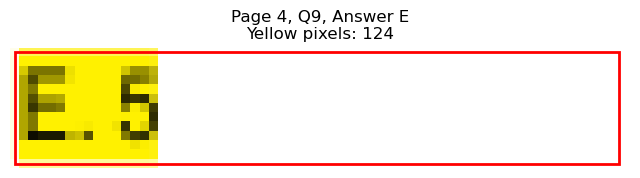


Page 4, Q9 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=103.0, y1=133.6
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 99
Page 5, Q1, A: Yellow percentage: 0.0%


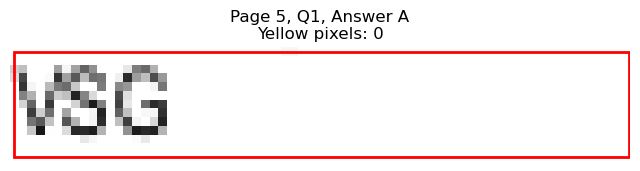

Page 5, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=130.8, y1=145.6
Page 5, Q1, B: Yellow pixels: 476
Page 5, Q1, B: Total non-white pixels: 754
Page 5, Q1, B: Yellow percentage: 63.1%


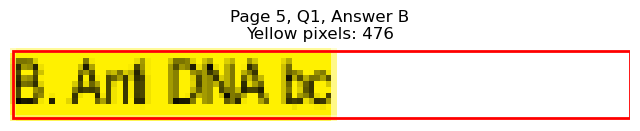

Page 5, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=113.4, y1=157.6
Page 5, Q1, C: Yellow pixels: 57
Page 5, Q1, C: Total non-white pixels: 228
Page 5, Q1, C: Yellow percentage: 25.0%


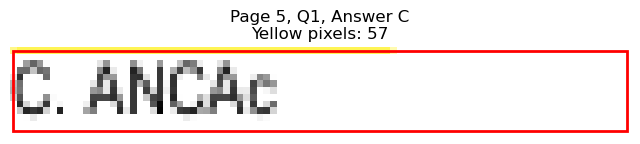

Page 5, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=347.0, y1=133.6
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 100
Page 5, Q1, D: Yellow percentage: 0.0%


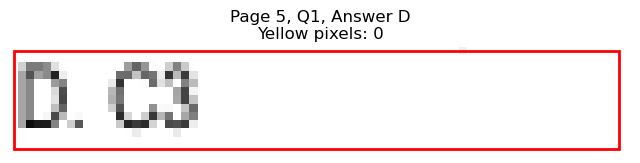

Page 5, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=362.0, y1=145.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 155
Page 5, Q1, E: Yellow percentage: 0.0%


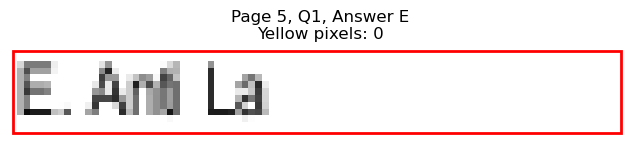


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.6, y0=217.6, x1=139.0, y1=229.7
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 570
Page 5, Q2, A: Yellow percentage: 0.0%


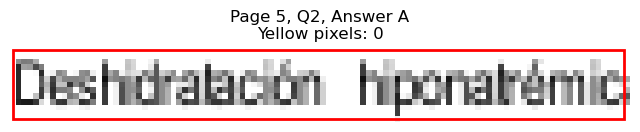

Page 5, Q2 - B: Detected box: x0=71.3, y0=229.6, x1=129.2, y1=241.7
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 434
Page 5, Q2, B: Yellow percentage: 0.0%


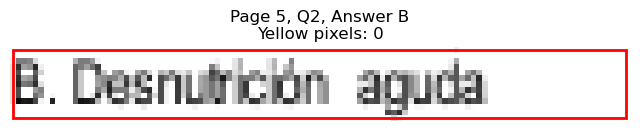

Page 5, Q2 - C: Detected box: x0=71.3, y0=241.6, x1=139.0, y1=253.7
Page 5, Q2, C: Yellow pixels: 917
Page 5, Q2, C: Total non-white pixels: 1534
Page 5, Q2, C: Yellow percentage: 59.8%


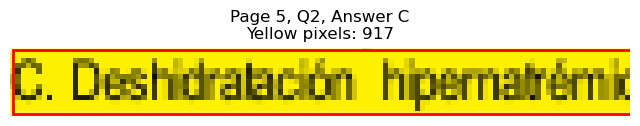

Page 5, Q2 - D: Detected box: x0=322.9, y0=217.6, x1=407.8, y1=229.7
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 435
Page 5, Q2, D: Yellow percentage: 0.0%


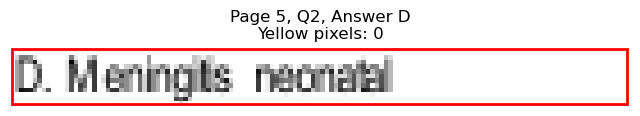

Page 5, Q2 - E: Detected box: x0=322.9, y0=229.6, x1=394.3, y1=241.7
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 477
Page 5, Q2, E: Yellow percentage: 0.0%


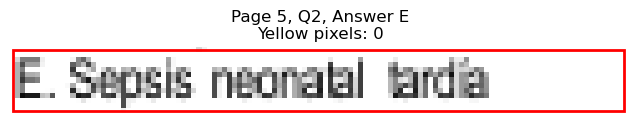


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.6, y0=289.7, x1=215.5, y1=301.8
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 864
Page 5, Q3, A: Yellow percentage: 0.0%


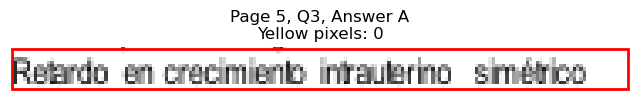

Page 5, Q3 - B: Detected box: x0=71.3, y0=302.5, x1=246.2, y1=314.5
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 834
Page 5, Q3, B: Yellow percentage: 0.0%


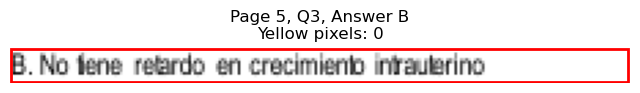

Page 5, Q3 - C: Detected box: x0=71.3, y0=314.5, x1=173.6, y1=326.5
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 462
Page 5, Q3, C: Yellow percentage: 0.0%


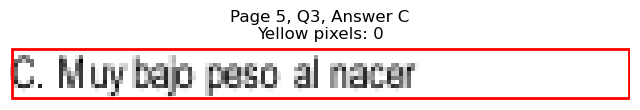

Page 5, Q3 - D: Detected box: x0=322.9, y0=289.7, x1=503.0, y1=301.8
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 902
Page 5, Q3, D: Yellow percentage: 0.0%


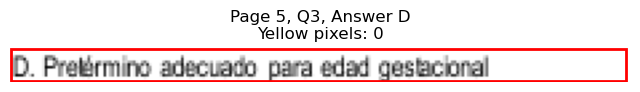

Page 5, Q3 - E: Detected box: x0=322.9, y0=302.5, x1=466.3, y1=314.5
Page 5, Q3, E: Yellow pixels: 1671
Page 5, Q3, E: Total non-white pixels: 2431
Page 5, Q3, E: Yellow percentage: 68.7%


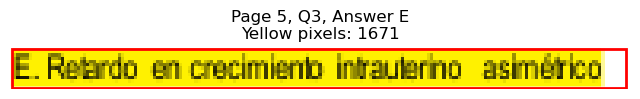


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=126.2, y1=362.5
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 223
Page 5, Q4, A: Yellow percentage: 0.0%


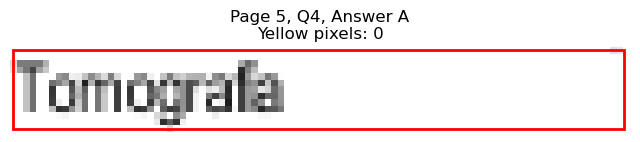

Page 5, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=134.6, y1=374.6
Page 5, Q4, B: Yellow pixels: 534
Page 5, Q4, B: Total non-white pixels: 806
Page 5, Q4, B: Yellow percentage: 66.3%


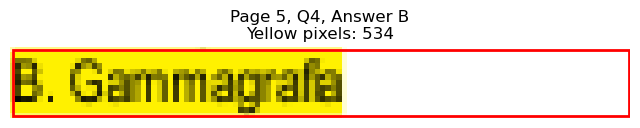

Page 5, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=128.5, y1=386.6
Page 5, Q4, C: Yellow pixels: 61
Page 5, Q4, C: Total non-white pixels: 329
Page 5, Q4, C: Yellow percentage: 18.5%


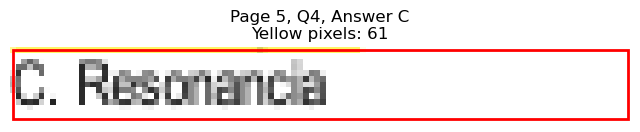

Page 5, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=401.8, y1=362.5
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 412
Page 5, Q4, D: Yellow percentage: 0.0%


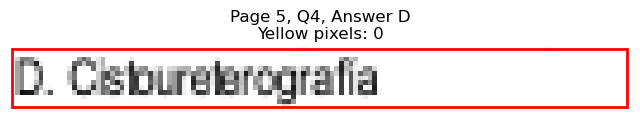

Page 5, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=370.3, y1=374.6
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 234
Page 5, Q4, E: Yellow percentage: 0.0%


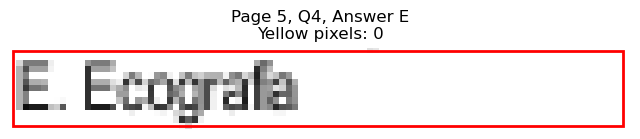


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=199.8, y1=422.6
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 755
Page 5, Q5, A: Yellow percentage: 0.0%


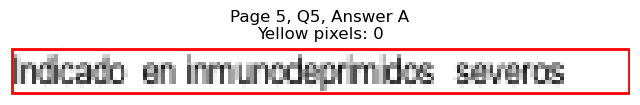

Page 5, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=168.3, y1=434.6
Page 5, Q5, B: Yellow pixels: 782
Page 5, Q5, B: Total non-white pixels: 1237
Page 5, Q5, B: Yellow percentage: 63.2%


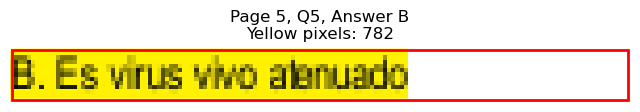

Page 5, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=237.2, y1=446.6
Page 5, Q5, C: Yellow pixels: 95
Page 5, Q5, C: Total non-white pixels: 826
Page 5, Q5, C: Yellow percentage: 11.5%


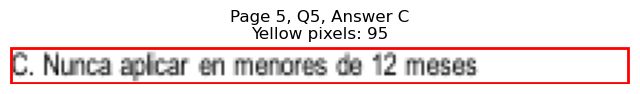

Page 5, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=452.0, y1=422.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 610
Page 5, Q5, D: Yellow percentage: 0.0%


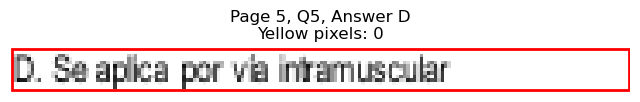

Page 5, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=460.2, y1=434.6
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 636
Page 5, Q5, E: Yellow percentage: 0.0%


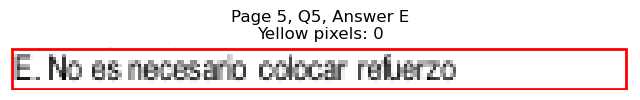


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=146.5, y1=482.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 310
Page 5, Q6, A: Yellow percentage: 0.0%


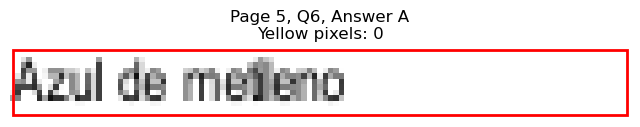

Page 5, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=129.3, y1=495.4
Page 5, Q6, B: Yellow pixels: 489
Page 5, Q6, B: Total non-white pixels: 728
Page 5, Q6, B: Yellow percentage: 67.2%


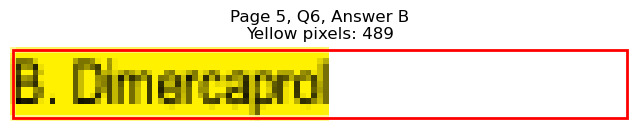

Page 5, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=136.0, y1=507.4
Page 5, Q6, C: Yellow pixels: 55
Page 5, Q6, C: Total non-white pixels: 366
Page 5, Q6, C: Yellow percentage: 15.0%


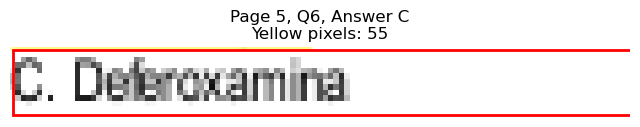

Page 5, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=380.0, y1=482.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 287
Page 5, Q6, D: Yellow percentage: 0.0%


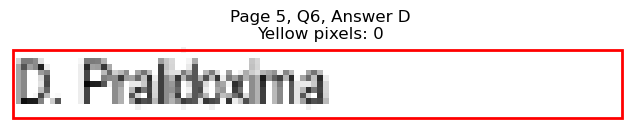

Page 5, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=396.6, y1=495.4
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 354
Page 5, Q6, E: Yellow percentage: 0.0%


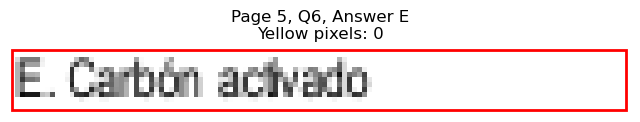


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.6, y0=555.4, x1=124.8, y1=567.5
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 416
Page 5, Q7, A: Yellow percentage: 0.0%


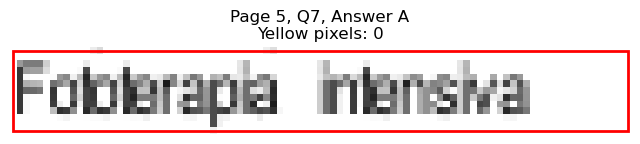

Page 5, Q7 - B: Detected box: x0=170.3, y0=567.5, x1=224.5, y1=579.5
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 257
Page 5, Q7, B: Yellow percentage: 0.0%


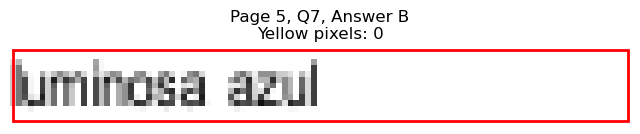

Page 5, Q7 - C: Detected box: x0=71.3, y0=579.4, x1=163.8, y1=591.5
Page 5, Q7, C: Yellow pixels: 801
Page 5, Q7, C: Total non-white pixels: 1183
Page 5, Q7, C: Yellow percentage: 67.7%


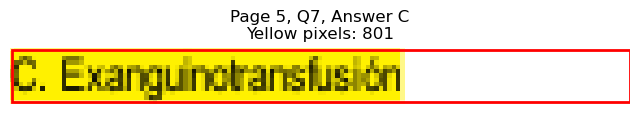

Page 5, Q7 - D: Detected box: x0=422.7, y0=555.4, x1=485.8, y1=567.5
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 321
Page 5, Q7, D: Yellow percentage: 0.0%


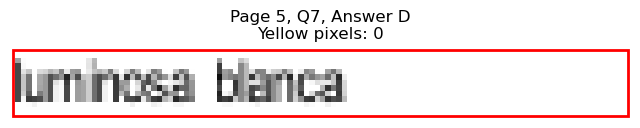

Page 5, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=380.1, y1=579.5
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 295
Page 5, Q7, E: Yellow percentage: 0.0%


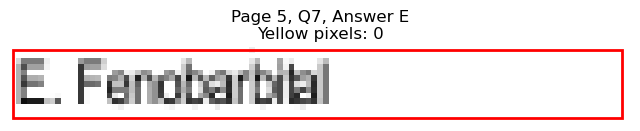


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=615.5, x1=117.3, y1=627.5
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 183
Page 5, Q8, A: Yellow percentage: 0.0%


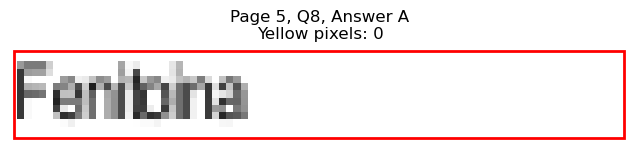

Page 5, Q8 - B: Detected box: x0=71.3, y0=627.5, x1=116.5, y1=639.6
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 221
Page 5, Q8, B: Yellow percentage: 0.0%


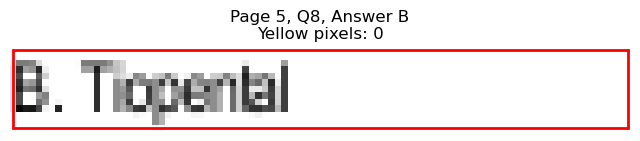

Page 5, Q8 - C: Detected box: x0=71.3, y0=639.5, x1=123.3, y1=651.6
Page 5, Q8, C: Yellow pixels: 444
Page 5, Q8, C: Total non-white pixels: 650
Page 5, Q8, C: Yellow percentage: 68.3%


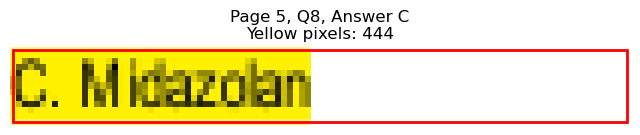

Page 5, Q8 - D: Detected box: x0=322.9, y0=615.5, x1=393.5, y1=627.5
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 328
Page 5, Q8, D: Yellow percentage: 0.0%


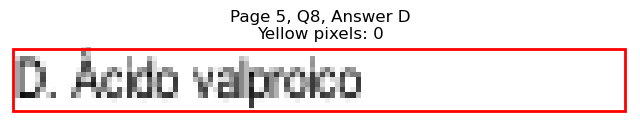

Page 5, Q8 - E: Detected box: x0=322.9, y0=627.5, x1=370.3, y1=639.6
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 226
Page 5, Q8, E: Yellow percentage: 0.0%


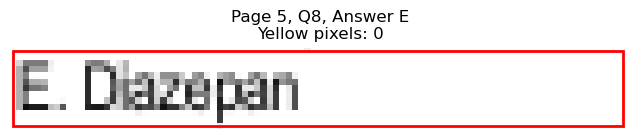


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=174.8, y0=676.3, x1=249.2, y1=688.3
Page 5, Q9, A: Yellow pixels: 722
Page 5, Q9, A: Total non-white pixels: 1157
Page 5, Q9, A: Yellow percentage: 62.4%


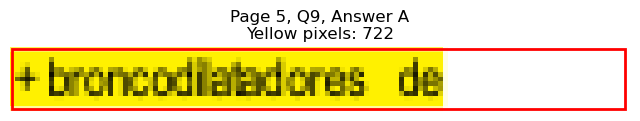

Page 5, Q9 - B: Detected box: x0=71.3, y0=700.3, x1=222.2, y1=712.3
Page 5, Q9, B: Yellow pixels: 3
Page 5, Q9, B: Total non-white pixels: 839
Page 5, Q9, B: Yellow percentage: 0.4%


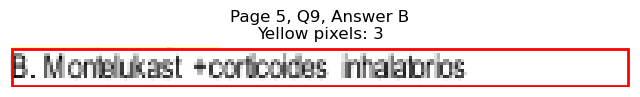

Page 5, Q9 - C: Detected box: x0=71.3, y0=712.3, x1=133.0, y1=724.4
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 532
Page 5, Q9, C: Yellow percentage: 0.0%


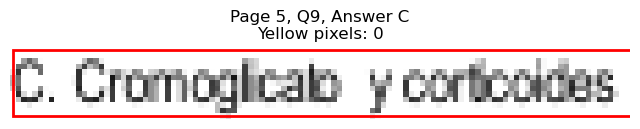

Page 5, Q9 - D: Detected box: x0=322.9, y0=676.3, x1=479.8, y1=688.3
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 980
Page 5, Q9, D: Yellow percentage: 0.0%


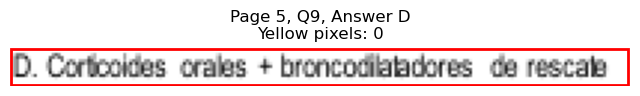

Page 5, Q9 - E: Detected box: x0=322.9, y0=688.3, x1=458.9, y1=700.3
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 851
Page 5, Q9, E: Yellow percentage: 0.0%


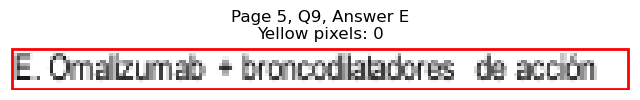


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=141.3, y1=133.6
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 304
Page 6, Q1, A: Yellow percentage: 0.0%


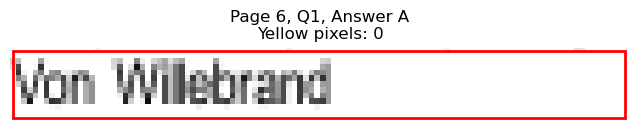

Page 6, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=193.7, y1=145.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 588
Page 6, Q1, B: Yellow percentage: 0.0%


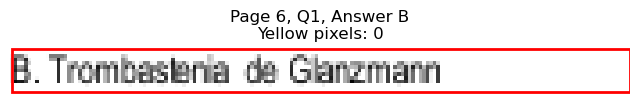

Page 6, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=118.0, y1=157.6
Page 6, Q1, C: Yellow pixels: 612
Page 6, Q1, C: Total non-white pixels: 988
Page 6, Q1, C: Yellow percentage: 61.9%


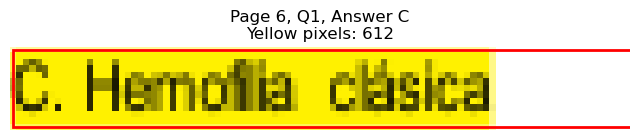

Page 6, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=449.0, y1=133.6
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 620
Page 6, Q1, D: Yellow percentage: 0.0%


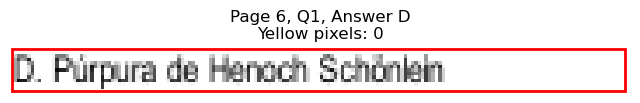

Page 6, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=434.9, y1=145.6
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 539
Page 6, Q1, E: Yellow percentage: 0.0%


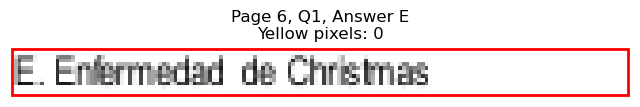


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=136.0, y1=205.6
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 272
Page 6, Q2, A: Yellow percentage: 0.0%


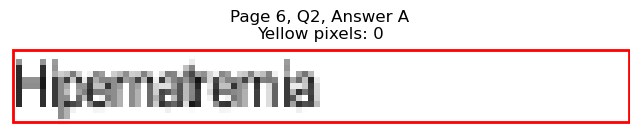

Page 6, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=129.2, y1=217.7
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 305
Page 6, Q2, B: Yellow percentage: 0.0%


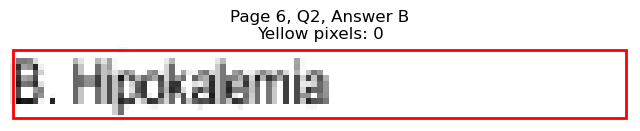

Page 6, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=133.0, y1=229.7
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 294
Page 6, Q2, C: Yellow percentage: 0.0%


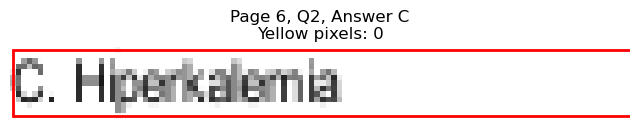

Page 6, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=384.6, y1=205.6
Page 6, Q2, D: Yellow pixels: 457
Page 6, Q2, D: Total non-white pixels: 794
Page 6, Q2, D: Yellow percentage: 57.6%


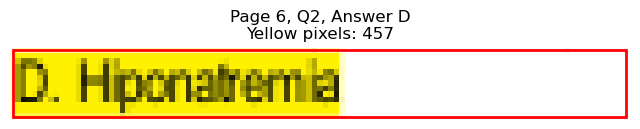

Page 6, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=385.3, y1=217.7
Page 6, Q2, E: Yellow pixels: 59
Page 6, Q2, E: Total non-white pixels: 369
Page 6, Q2, E: Yellow percentage: 16.0%


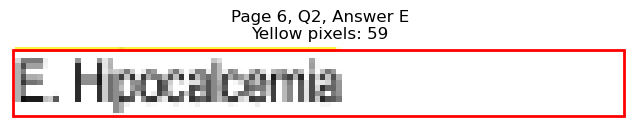


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.6, y0=277.7, x1=184.1, y1=289.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 508
Page 6, Q3, A: Yellow percentage: 0.0%


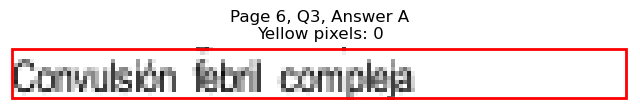

Page 6, Q3 - B: Detected box: x0=71.3, y0=289.7, x1=134.5, y1=301.8
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 319
Page 6, Q3, B: Yellow percentage: 0.0%


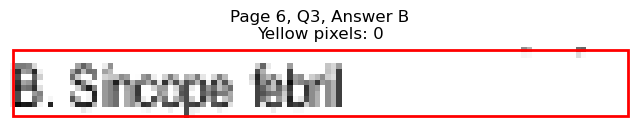

Page 6, Q3 - C: Detected box: x0=71.3, y0=302.5, x1=179.5, y1=314.5
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 545
Page 6, Q3, C: Yellow percentage: 0.0%


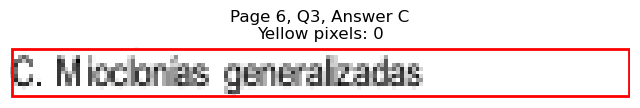

Page 6, Q3 - D: Detected box: x0=322.9, y0=277.7, x1=426.7, y1=289.7
Page 6, Q3, D: Yellow pixels: 795
Page 6, Q3, D: Total non-white pixels: 1339
Page 6, Q3, D: Yellow percentage: 59.4%


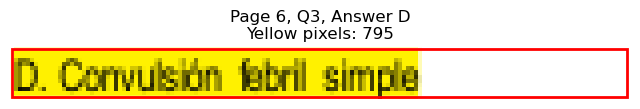

Page 6, Q3 - E: Detected box: x0=322.9, y0=289.7, x1=398.0, y1=301.8
Page 6, Q3, E: Yellow pixels: 100
Page 6, Q3, E: Total non-white pixels: 491
Page 6, Q3, E: Yellow percentage: 20.4%


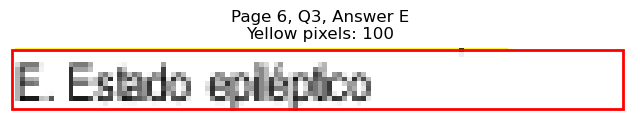


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=71.3, y0=350.5, x1=79.7, y1=362.5
Page 6, Q4, A: Yellow pixels: 29
Page 6, Q4, A: Total non-white pixels: 110
Page 6, Q4, A: Yellow percentage: 26.4%


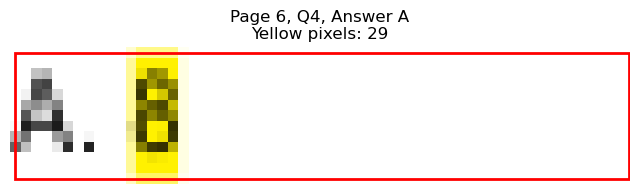

Page 6, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=88.7, y1=374.6
Page 6, Q4, B: Yellow pixels: 4
Page 6, Q4, B: Total non-white pixels: 77
Page 6, Q4, B: Yellow percentage: 5.2%


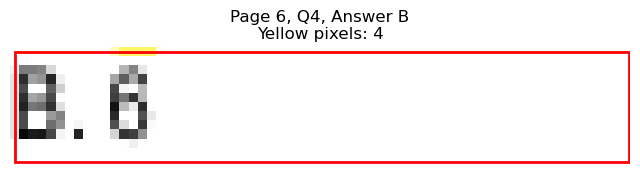

Page 6, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=94.0, y1=386.6
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 79
Page 6, Q4, C: Yellow percentage: 0.0%


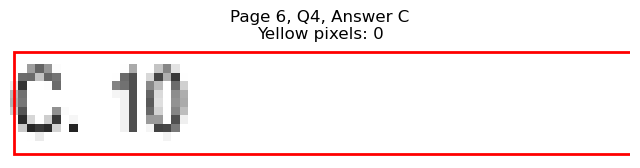

Page 6, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=345.5, y1=362.5
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 83
Page 6, Q4, D: Yellow percentage: 0.0%


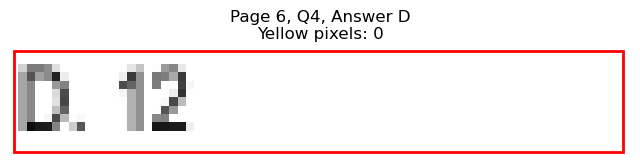

Page 6, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=344.8, y1=374.6
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 80
Page 6, Q4, E: Yellow percentage: 0.0%


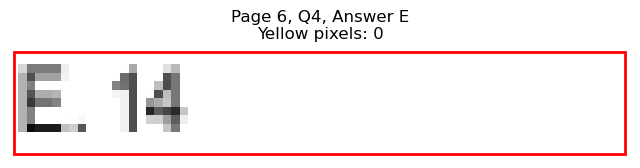


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=422.5, x1=115.0, y1=434.6
Page 6, Q5, A: Yellow pixels: 217
Page 6, Q5, A: Total non-white pixels: 405
Page 6, Q5, A: Yellow percentage: 53.6%


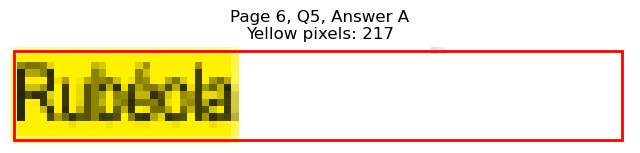

Page 6, Q5 - B: Detected box: x0=71.3, y0=434.6, x1=142.7, y1=446.6
Page 6, Q5, B: Yellow pixels: 30
Page 6, Q5, B: Total non-white pixels: 394
Page 6, Q5, B: Yellow percentage: 7.6%


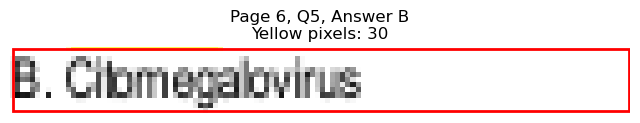

Page 6, Q5 - C: Detected box: x0=71.3, y0=446.6, x1=112.0, y1=458.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 174
Page 6, Q5, C: Yellow percentage: 0.0%


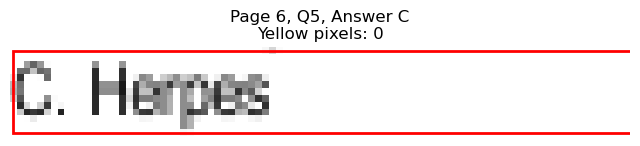

Page 6, Q5 - D: Detected box: x0=322.9, y0=422.5, x1=354.5, y1=434.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 164
Page 6, Q5, D: Yellow percentage: 0.0%


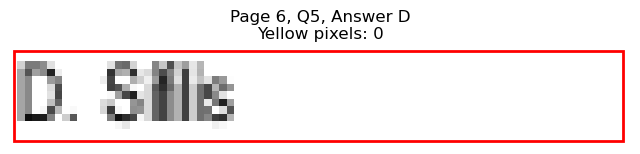

Page 6, Q5 - E: Detected box: x0=322.9, y0=434.6, x1=392.0, y1=446.6
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 328
Page 6, Q5, E: Yellow percentage: 0.0%


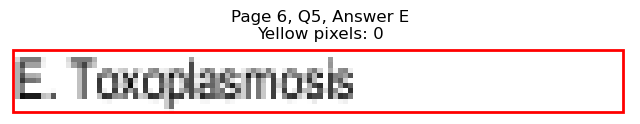


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=164.5, y1=507.4
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 407
Page 6, Q6, A: Yellow percentage: 0.0%


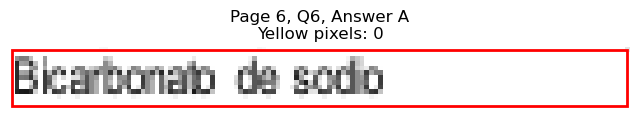

Page 6, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=121.0, y1=519.4
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 411
Page 6, Q6, B: Yellow percentage: 0.0%


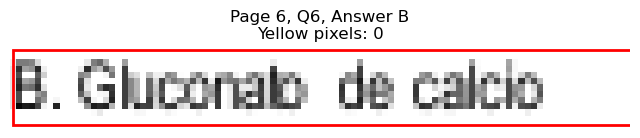

Page 6, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=122.5, y1=531.4
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 227
Page 6, Q6, C: Yellow percentage: 0.0%


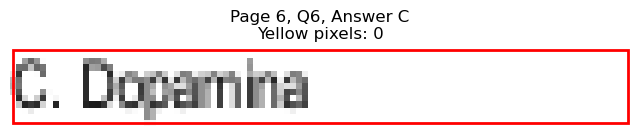

Page 6, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=375.6, y1=507.4
Page 6, Q6, D: Yellow pixels: 435
Page 6, Q6, D: Total non-white pixels: 676
Page 6, Q6, D: Yellow percentage: 64.3%


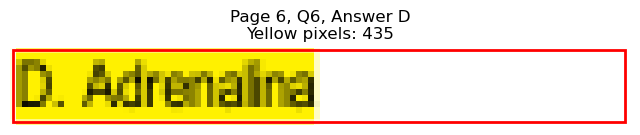

Page 6, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=365.8, y1=519.4
Page 6, Q6, E: Yellow pixels: 50
Page 6, Q6, E: Total non-white pixels: 258
Page 6, Q6, E: Yellow percentage: 19.4%


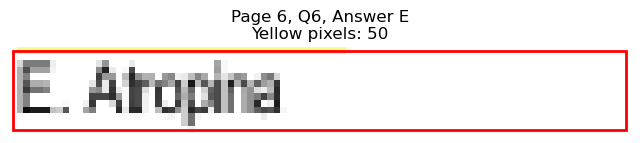


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.6, y0=579.4, x1=112.0, y1=591.5
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 149
Page 6, Q7, A: Yellow percentage: 0.0%


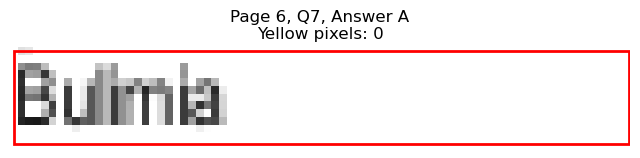

Page 6, Q7 - B: Detected box: x0=71.3, y0=591.5, x1=152.6, y1=603.5
Page 6, Q7, B: Yellow pixels: 732
Page 6, Q7, B: Total non-white pixels: 1040
Page 6, Q7, B: Yellow percentage: 70.4%


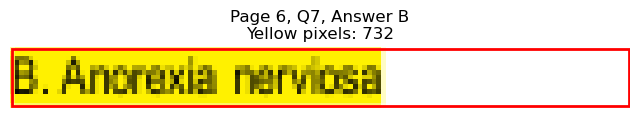

Page 6, Q7 - C: Detected box: x0=71.3, y0=603.5, x1=136.0, y1=615.5
Page 6, Q7, C: Yellow pixels: 79
Page 6, Q7, C: Total non-white pixels: 382
Page 6, Q7, C: Yellow percentage: 20.7%


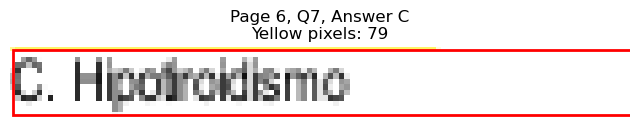

Page 6, Q7 - D: Detected box: x0=322.9, y0=579.4, x1=405.5, y1=591.5
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 391
Page 6, Q7, D: Yellow percentage: 0.0%


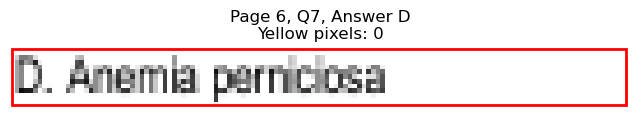

Page 6, Q7 - E: Detected box: x0=322.9, y0=591.5, x1=380.0, y1=603.5
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 498
Page 6, Q7, E: Yellow percentage: 0.0%


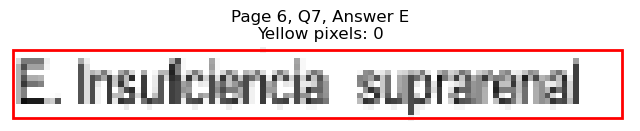


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.6, y0=663.5, x1=125.5, y1=675.6
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 225
Page 6, Q8, A: Yellow percentage: 0.0%


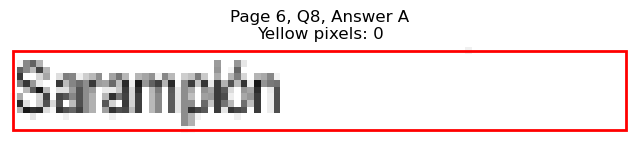

Page 6, Q8 - B: Detected box: x0=71.3, y0=676.3, x1=114.3, y1=688.3
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 223
Page 6, Q8, B: Yellow percentage: 0.0%


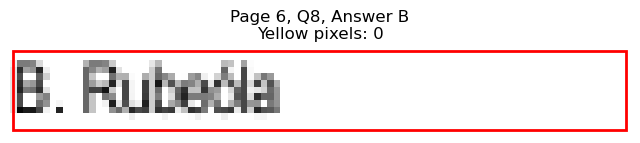

Page 6, Q8 - C: Detected box: x0=71.3, y0=688.3, x1=152.6, y1=700.3
Page 6, Q8, C: Yellow pixels: 636
Page 6, Q8, C: Total non-white pixels: 1040
Page 6, Q8, C: Yellow percentage: 61.2%


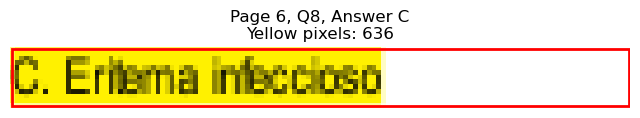

Page 6, Q8 - D: Detected box: x0=322.9, y0=663.5, x1=398.8, y1=675.6
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 377
Page 6, Q8, D: Yellow percentage: 0.0%


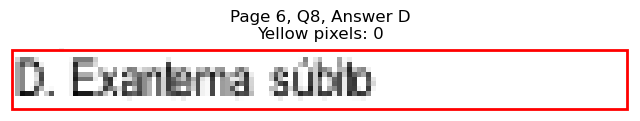

Page 6, Q8 - E: Detected box: x0=322.9, y0=676.3, x1=431.8, y1=688.3
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 524
Page 6, Q8, E: Yellow percentage: 0.0%


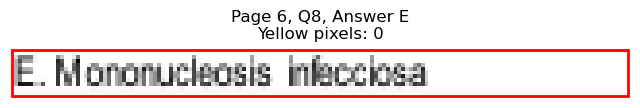


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.6, y0=736.4, x1=103.8, y1=748.4
Page 6, Q9, A: Yellow pixels: 182
Page 6, Q9, A: Total non-white pixels: 260
Page 6, Q9, A: Yellow percentage: 70.0%


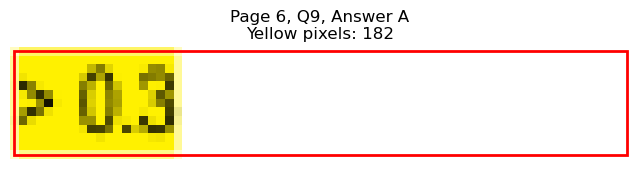

Page 6, Q9 - B: Detected box: x0=71.3, y0=748.4, x1=95.5, y1=760.4
Page 6, Q9, B: Yellow pixels: 18
Page 6, Q9, B: Total non-white pixels: 108
Page 6, Q9, B: Yellow percentage: 16.7%


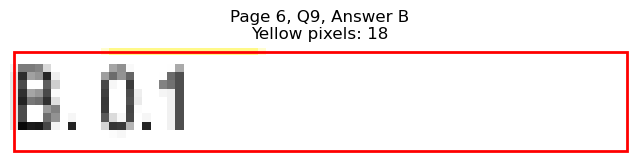

Page 6, Q9 - C: Detected box: x0=71.3, y0=760.4, x1=96.2, y1=772.4
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 87
Page 6, Q9, C: Yellow percentage: 0.0%


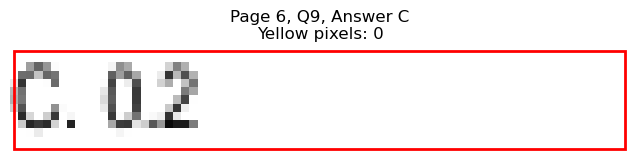

Page 6, Q9 - D: Detected box: x0=322.9, y0=736.4, x1=347.8, y1=748.4
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 103
Page 6, Q9, D: Yellow percentage: 0.0%


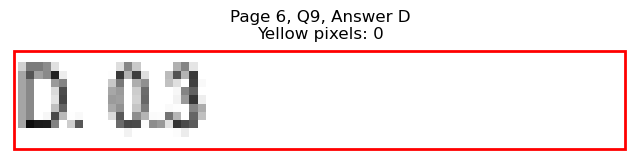

Page 6, Q9 - E: Detected box: x0=322.9, y0=748.4, x1=357.6, y1=760.4
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 101
Page 6, Q9, E: Yellow percentage: 0.0%


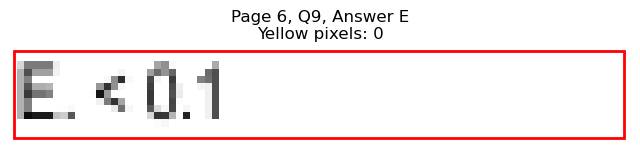


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=125.5, y1=108.8
Page 7, Q1, A: Yellow pixels: 299
Page 7, Q1, A: Total non-white pixels: 556
Page 7, Q1, A: Yellow percentage: 53.8%


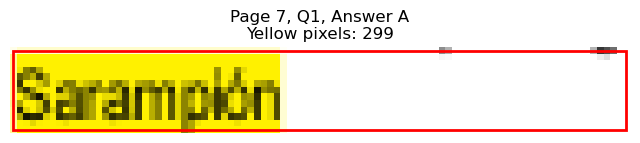

Page 7, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=114.2, y1=121.6
Page 7, Q1, B: Yellow pixels: 40
Page 7, Q1, B: Total non-white pixels: 265
Page 7, Q1, B: Yellow percentage: 15.1%


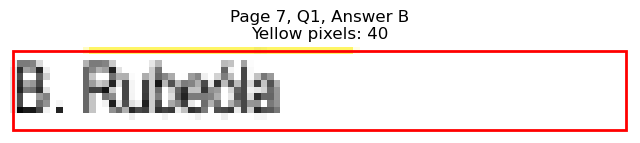

Page 7, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=147.2, y1=133.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 357
Page 7, Q1, C: Yellow percentage: 0.0%


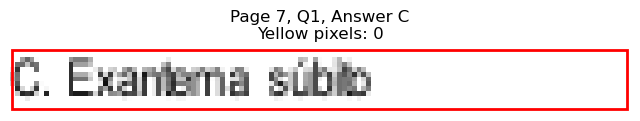

Page 7, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=424.2, y1=108.8
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 505
Page 7, Q1, D: Yellow percentage: 0.0%


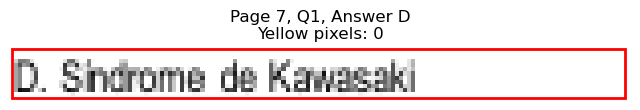

Page 7, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=431.8, y1=121.6
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 524
Page 7, Q1, E: Yellow percentage: 0.0%


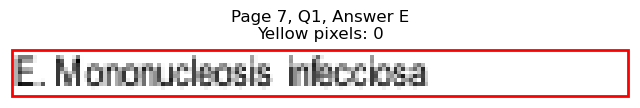


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=157.0, y1=169.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 381
Page 7, Q2, A: Yellow percentage: 0.0%


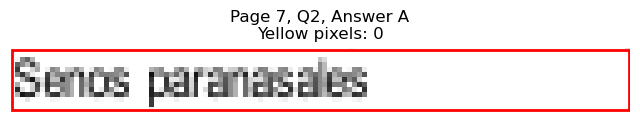

Page 7, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=122.5, y1=181.6
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 267
Page 7, Q2, B: Yellow percentage: 0.0%


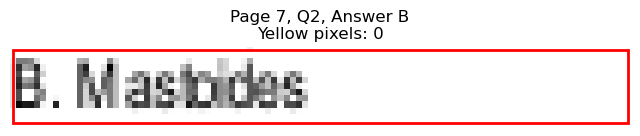

Page 7, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=130.0, y1=193.6
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 266
Page 7, Q2, C: Yellow percentage: 0.0%


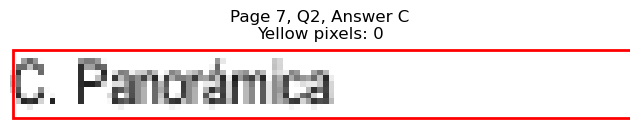

Page 7, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=363.6, y1=169.6
Page 7, Q2, D: Yellow pixels: 309
Page 7, Q2, D: Total non-white pixels: 522
Page 7, Q2, D: Yellow percentage: 59.2%


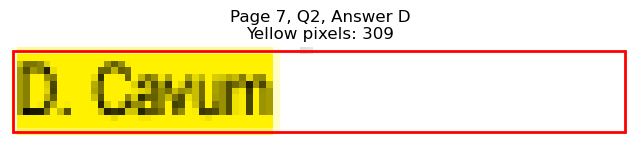

Page 7, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=389.1, y1=181.6
Page 7, Q2, E: Yellow pixels: 38
Page 7, Q2, E: Total non-white pixels: 360
Page 7, Q2, E: Yellow percentage: 10.6%


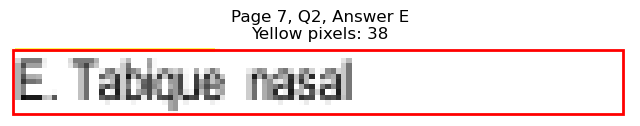


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=147.2, y1=241.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 327
Page 7, Q3, A: Yellow percentage: 0.0%


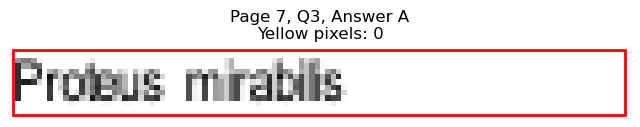

Page 7, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=146.6, y1=253.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 346
Page 7, Q3, B: Yellow percentage: 0.0%


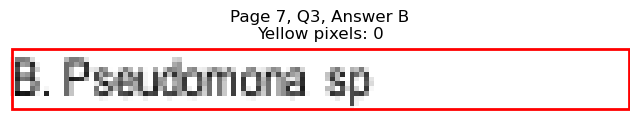

Page 7, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=137.5, y1=265.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 308
Page 7, Q3, C: Yellow percentage: 0.0%


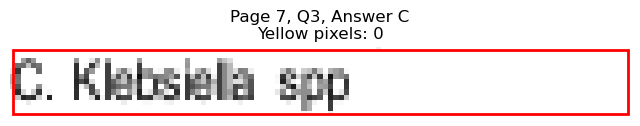

Page 7, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=417.5, y1=241.7
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 479
Page 7, Q3, D: Yellow percentage: 0.0%


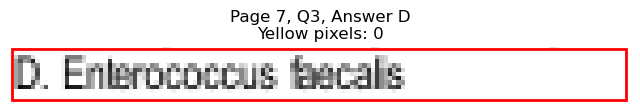

Page 7, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=395.1, y1=253.7
Page 7, Q3, E: Yellow pixels: 541
Page 7, Q3, E: Total non-white pixels: 923
Page 7, Q3, E: Yellow percentage: 58.6%


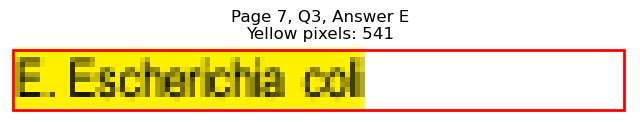


Page 7, Q3 - Selected Answer: E (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=210.9, y1=314.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 623
Page 7, Q4, A: Yellow percentage: 0.0%


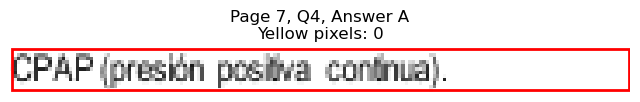

Page 7, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=187.7, y1=326.5
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 559
Page 7, Q4, B: Yellow percentage: 0.0%


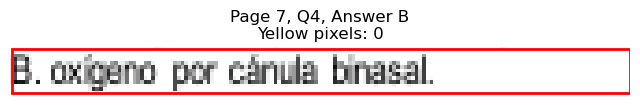

Page 7, Q4 - C: Detected box: x0=125.3, y0=326.5, x1=241.2, y1=338.5
Page 7, Q4, C: Yellow pixels: 1043
Page 7, Q4, C: Total non-white pixels: 1482
Page 7, Q4, C: Yellow percentage: 70.4%


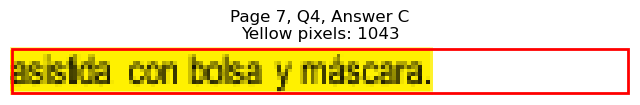

Page 7, Q4 - D: Detected box: x0=375.4, y0=302.5, x1=426.6, y1=314.5
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 272
Page 7, Q4, D: Yellow percentage: 0.0%


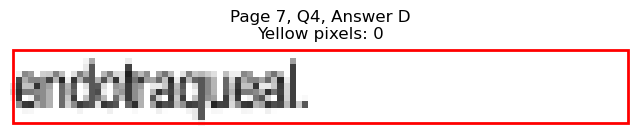

Page 7, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=472.2, y1=326.5
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 690
Page 7, Q4, E: Yellow percentage: 0.0%


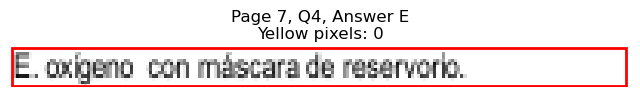


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=130.7, y1=398.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 250
Page 7, Q5, A: Yellow percentage: 0.0%


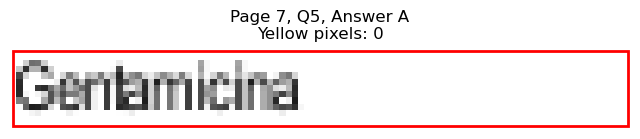

Page 7, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=121.7, y1=410.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 259
Page 7, Q5, B: Yellow percentage: 0.0%


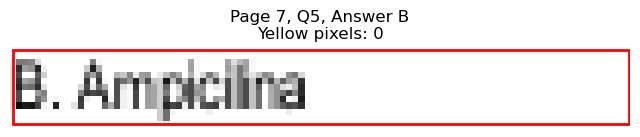

Page 7, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=136.0, y1=422.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 311
Page 7, Q5, C: Yellow percentage: 0.0%


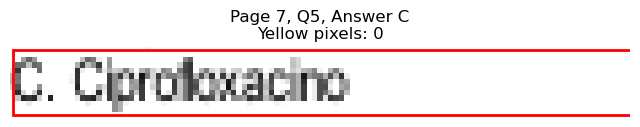

Page 7, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=377.1, y1=398.6
Page 7, Q5, D: Yellow pixels: 402
Page 7, Q5, D: Total non-white pixels: 689
Page 7, Q5, D: Yellow percentage: 58.3%


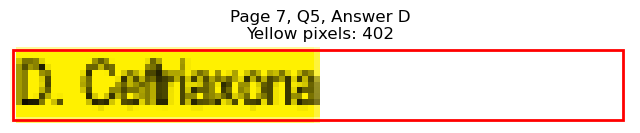

Page 7, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=388.3, y1=410.6
Page 7, Q5, E: Yellow pixels: 52
Page 7, Q5, E: Total non-white pixels: 384
Page 7, Q5, E: Yellow percentage: 13.5%


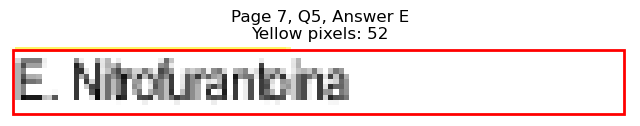


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=122.5, y1=482.6
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 203
Page 7, Q6, A: Yellow percentage: 0.0%


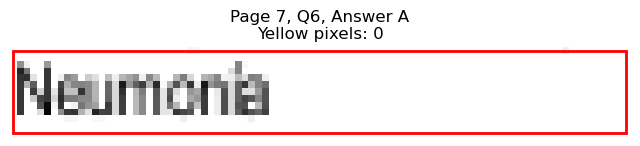

Page 7, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=118.7, y1=495.4
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 222
Page 7, Q6, B: Yellow percentage: 0.0%


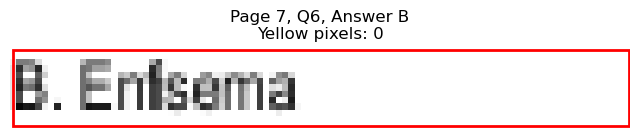

Page 7, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=115.0, y1=507.4
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 184
Page 7, Q6, C: Yellow percentage: 0.0%


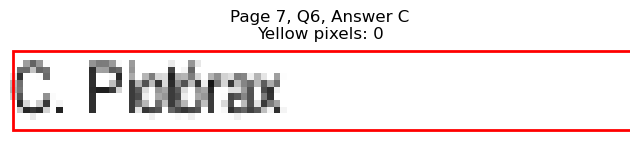

Page 7, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=375.6, y1=482.6
Page 7, Q6, D: Yellow pixels: 373
Page 7, Q6, D: Total non-white pixels: 676
Page 7, Q6, D: Yellow percentage: 55.2%


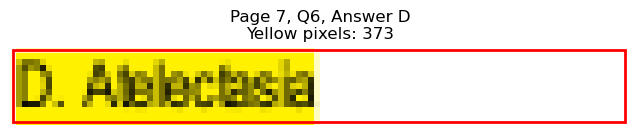

Page 7, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=380.8, y1=495.4
Page 7, Q6, E: Yellow pixels: 50
Page 7, Q6, E: Total non-white pixels: 326
Page 7, Q6, E: Yellow percentage: 15.3%


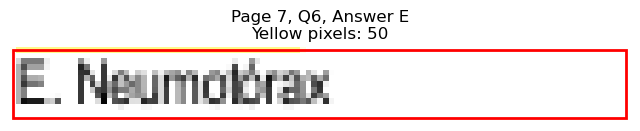


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=133.0, y1=555.5
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 263
Page 7, Q7, A: Yellow percentage: 0.0%


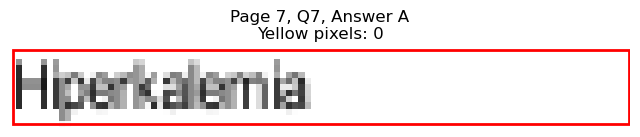

Page 7, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=129.3, y1=567.5
Page 7, Q7, B: Yellow pixels: 471
Page 7, Q7, B: Total non-white pixels: 728
Page 7, Q7, B: Yellow percentage: 64.7%


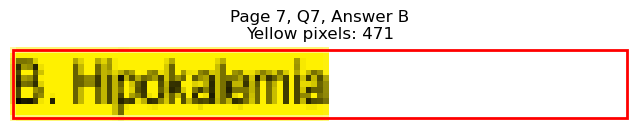

Page 7, Q7 - C: Detected box: x0=71.3, y0=567.5, x1=133.0, y1=579.5
Page 7, Q7, C: Yellow pixels: 55
Page 7, Q7, C: Total non-white pixels: 339
Page 7, Q7, C: Yellow percentage: 16.2%


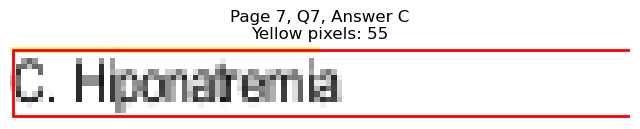

Page 7, Q7 - D: Detected box: x0=322.9, y0=543.4, x1=386.0, y1=555.5
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 322
Page 7, Q7, D: Yellow percentage: 0.0%


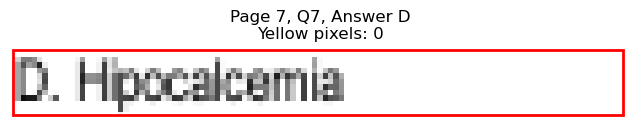

Page 7, Q7 - E: Detected box: x0=322.9, y0=555.4, x1=388.3, y1=567.5
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 320
Page 7, Q7, E: Yellow percentage: 0.0%


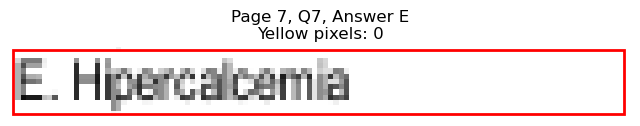


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=615.5, x1=195.2, y1=627.5
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 530
Page 7, Q8, A: Yellow percentage: 0.0%


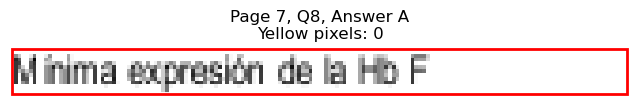

Page 7, Q8 - B: Detected box: x0=71.3, y0=627.5, x1=221.5, y1=639.6
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 702
Page 7, Q8, B: Yellow percentage: 0.0%


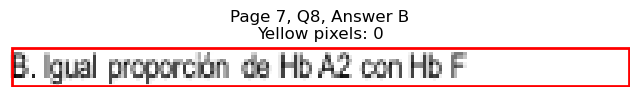

Page 7, Q8 - C: Detected box: x0=71.3, y0=639.5, x1=161.4, y1=651.6
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 393
Page 7, Q8, C: Yellow percentage: 0.0%


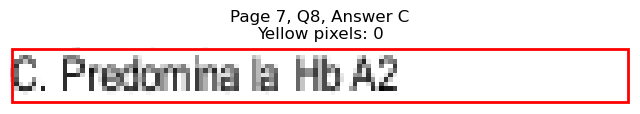

Page 7, Q8 - D: Detected box: x0=322.9, y0=615.5, x1=453.7, y1=627.5
Page 7, Q8, D: Yellow pixels: 1174
Page 7, Q8, D: Total non-white pixels: 1690
Page 7, Q8, D: Yellow percentage: 69.5%


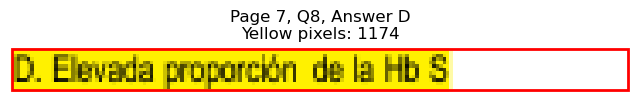

Page 7, Q8 - E: Detected box: x0=322.9, y0=627.5, x1=507.5, y1=639.6
Page 7, Q8, E: Yellow pixels: 128
Page 7, Q8, E: Total non-white pixels: 975
Page 7, Q8, E: Yellow percentage: 13.1%


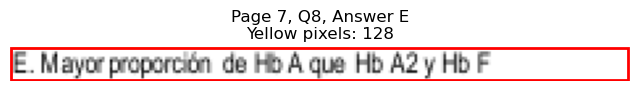


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=125.5, y1=712.3
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 457
Page 7, Q9, A: Yellow percentage: 0.0%


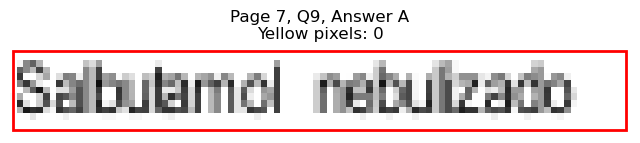

Page 7, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=158.5, y1=724.4
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 662
Page 7, Q9, B: Yellow percentage: 0.0%


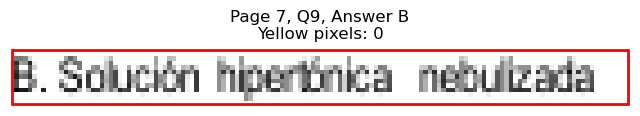

Page 7, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=140.5, y1=736.4
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 327
Page 7, Q9, C: Yellow percentage: 0.0%


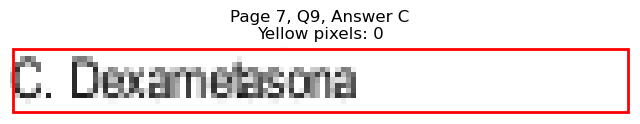

Page 7, Q9 - D: Detected box: x0=379.9, y0=700.3, x1=441.7, y1=712.3
Page 7, Q9, D: Yellow pixels: 458
Page 7, Q9, D: Total non-white pixels: 793
Page 7, Q9, D: Yellow percentage: 57.8%


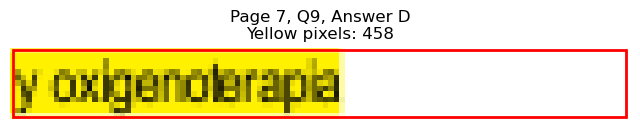

Page 7, Q9 - E: Detected box: x0=379.1, y0=712.3, x1=443.0, y1=724.4
Page 7, Q9, E: Yellow pixels: 5
Page 7, Q9, E: Total non-white pixels: 375
Page 7, Q9, E: Yellow percentage: 1.3%


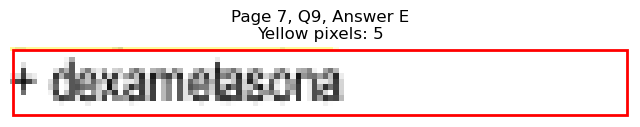


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=167.5, y1=121.6
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 400
Page 8, Q1, A: Yellow percentage: 0.0%


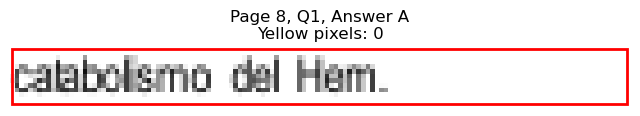

Page 8, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=173.5, y1=133.6
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 600
Page 8, Q1, B: Yellow percentage: 0.0%


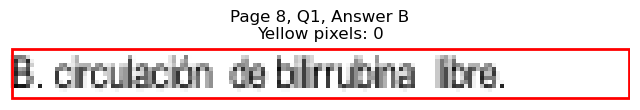

Page 8, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=163.8, y1=145.6
Page 8, Q1, C: Yellow pixels: 1171
Page 8, Q1, C: Total non-white pixels: 1859
Page 8, Q1, C: Yellow percentage: 63.0%


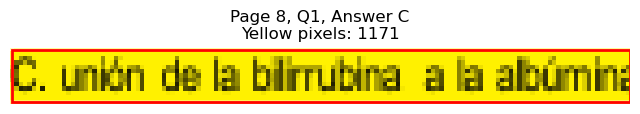

Page 8, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=444.6, y1=121.6
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 852
Page 8, Q1, D: Yellow percentage: 0.0%


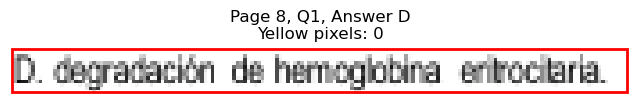

Page 8, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=401.1, y1=133.6
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 625
Page 8, Q1, E: Yellow percentage: 0.0%


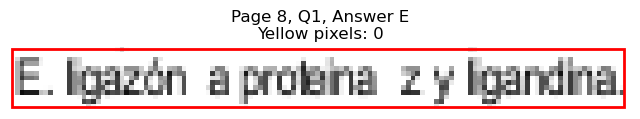


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=125.5, y1=193.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 228
Page 8, Q2, A: Yellow percentage: 0.0%


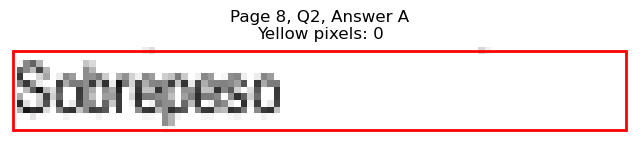

Page 8, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=143.5, y1=205.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 463
Page 8, Q2, B: Yellow percentage: 0.0%


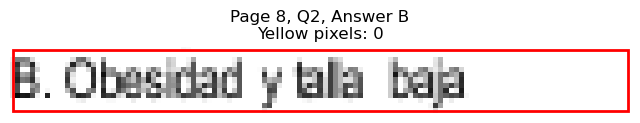

Page 8, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=148.7, y1=217.7
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 465
Page 8, Q2, C: Yellow percentage: 0.0%


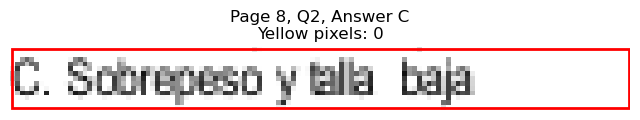

Page 8, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=372.6, y1=193.6
Page 8, Q2, D: Yellow pixels: 362
Page 8, Q2, D: Total non-white pixels: 637
Page 8, Q2, D: Yellow percentage: 56.8%


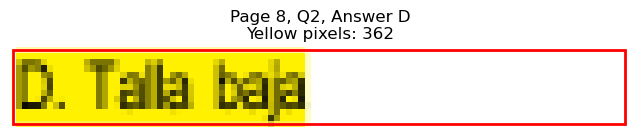

Page 8, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=371.0, y1=205.6
Page 8, Q2, E: Yellow pixels: 47
Page 8, Q2, E: Total non-white pixels: 293
Page 8, Q2, E: Yellow percentage: 16.0%


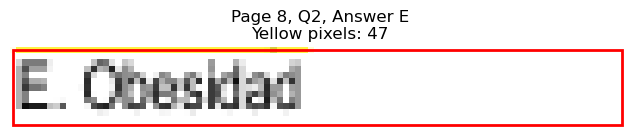


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=129.8, y0=241.6, x1=175.1, y1=253.7
Page 8, Q3, A: Yellow pixels: 352
Page 8, Q3, A: Total non-white pixels: 572
Page 8, Q3, A: Yellow percentage: 61.5%


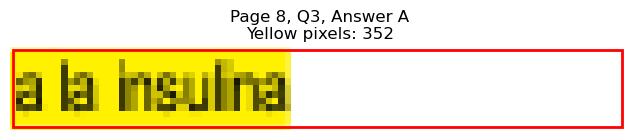

Page 8, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=201.2, y1=265.7
Page 8, Q3, B: Yellow pixels: 90
Page 8, Q3, B: Total non-white pixels: 742
Page 8, Q3, B: Yellow percentage: 12.1%


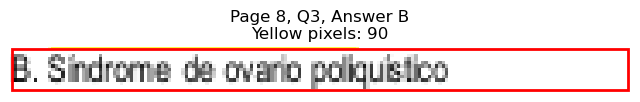

Page 8, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=157.0, y1=277.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 418
Page 8, Q3, C: Yellow percentage: 0.0%


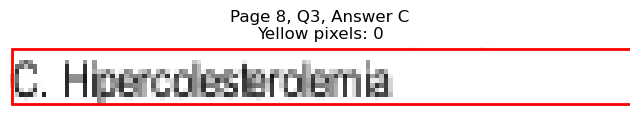

Page 8, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=389.8, y1=253.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 332
Page 8, Q3, D: Yellow percentage: 0.0%


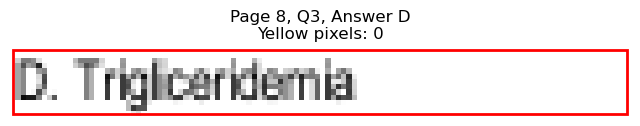

Page 8, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=417.5, y1=265.7
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 455
Page 8, Q3, E: Yellow percentage: 0.0%


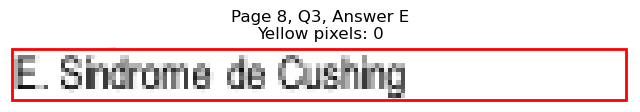


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=100.8, y1=326.5
Page 8, Q4, A: Yellow pixels: 140
Page 8, Q4, A: Total non-white pixels: 221
Page 8, Q4, A: Yellow percentage: 63.3%


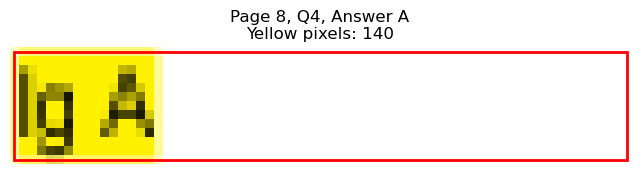

Page 8, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=100.7, y1=338.5
Page 8, Q4, B: Yellow pixels: 15
Page 8, Q4, B: Total non-white pixels: 147
Page 8, Q4, B: Yellow percentage: 10.2%


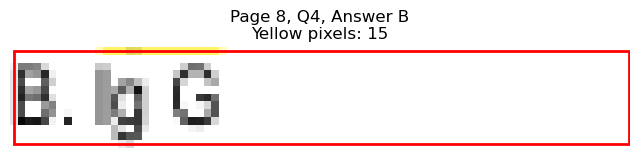

Page 8, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=102.2, y1=350.5
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 114
Page 8, Q4, C: Yellow percentage: 0.0%


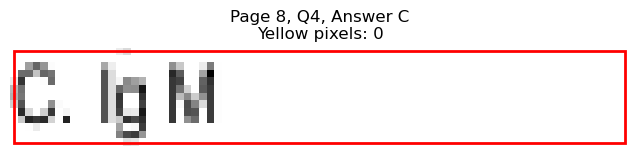

Page 8, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=351.5, y1=326.5
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 118
Page 8, Q4, D: Yellow percentage: 0.0%


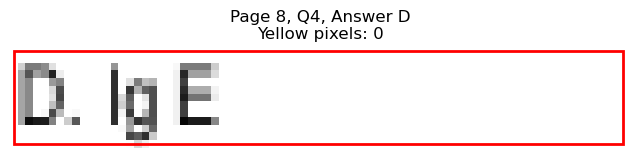

Page 8, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=351.5, y1=338.5
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 121
Page 8, Q4, E: Yellow percentage: 0.0%


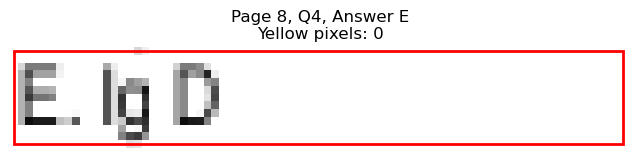


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=167.3, y0=398.5, x1=261.5, y1=410.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 473
Page 8, Q5, A: Yellow percentage: 0.0%


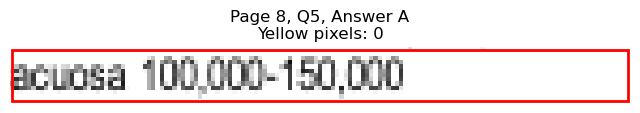

Page 8, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=173.5, y1=434.6
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 767
Page 8, Q5, B: Yellow percentage: 0.0%


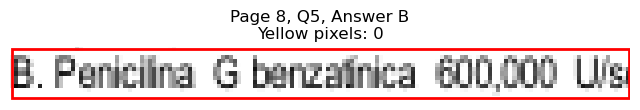

Page 8, Q5 - C: Detected box: x0=71.3, y0=446.6, x1=173.5, y1=458.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 727
Page 8, Q5, C: Yellow percentage: 0.0%


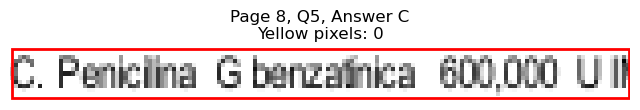

Page 8, Q5 - D: Detected box: x0=418.9, y0=398.5, x1=513.0, y1=410.6
Page 8, Q5, D: Yellow pixels: 830
Page 8, Q5, D: Total non-white pixels: 1209
Page 8, Q5, D: Yellow percentage: 68.7%


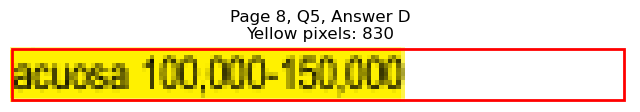

Page 8, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=422.9, y1=434.6
Page 8, Q5, E: Yellow pixels: 94
Page 8, Q5, E: Total non-white pixels: 572
Page 8, Q5, E: Yellow percentage: 16.4%


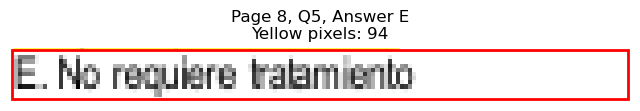


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=507.4, x1=114.3, y1=519.4
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 167
Page 8, Q6, A: Yellow percentage: 0.0%


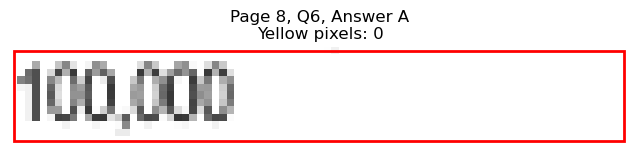

Page 8, Q6 - B: Detected box: x0=71.3, y0=519.4, x1=109.0, y1=531.4
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 178
Page 8, Q6, B: Yellow percentage: 0.0%


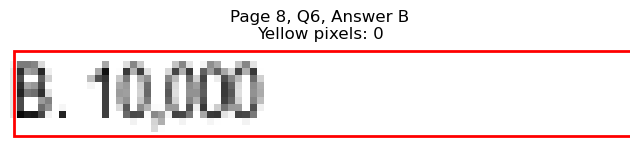

Page 8, Q6 - C: Detected box: x0=71.3, y0=531.4, x1=105.2, y1=543.5
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 150
Page 8, Q6, C: Yellow percentage: 0.0%


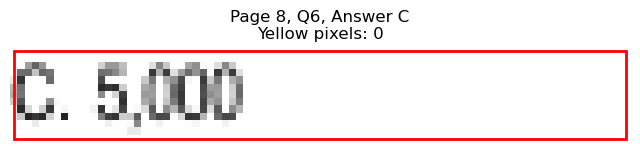

Page 8, Q6 - D: Detected box: x0=322.9, y0=507.4, x1=361.3, y1=519.4
Page 8, Q6, D: Yellow pixels: 326
Page 8, Q6, D: Total non-white pixels: 481
Page 8, Q6, D: Yellow percentage: 67.8%


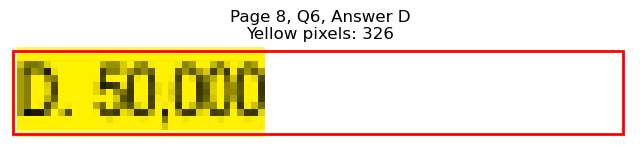

Page 8, Q6 - E: Detected box: x0=322.9, y0=519.4, x1=356.0, y1=531.4
Page 8, Q6, E: Yellow pixels: 36
Page 8, Q6, E: Total non-white pixels: 184
Page 8, Q6, E: Yellow percentage: 19.6%


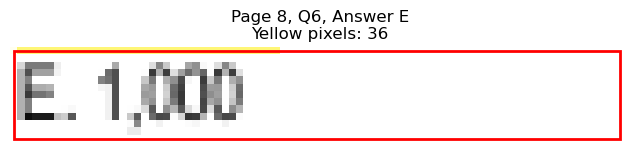


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=123.8, y0=567.5, x1=217.8, y1=579.5
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 709
Page 8, Q7, A: Yellow percentage: 0.0%


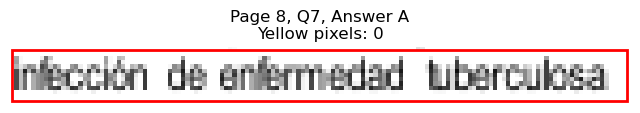

Page 8, Q7 - B: Detected box: x0=71.3, y0=579.4, x1=174.2, y1=591.5
Page 8, Q7, B: Yellow pixels: 1385
Page 8, Q7, B: Total non-white pixels: 2002
Page 8, Q7, B: Yellow percentage: 69.2%


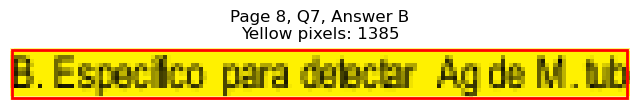

Page 8, Q7 - C: Detected box: x0=150.1, y0=591.5, x1=267.9, y1=603.5
Page 8, Q7, C: Yellow pixels: 107
Page 8, Q7, C: Total non-white pixels: 634
Page 8, Q7, C: Yellow percentage: 16.9%


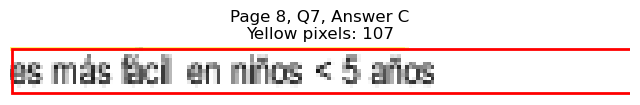

Page 8, Q7 - D: Detected box: x0=322.9, y0=567.5, x1=407.0, y1=579.5
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 377
Page 8, Q7, D: Yellow percentage: 0.0%


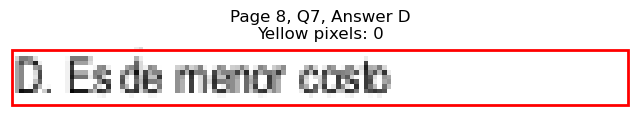

Page 8, Q7 - E: Detected box: x0=322.9, y0=579.4, x1=427.2, y1=591.5
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 507
Page 8, Q7, E: Yellow percentage: 0.0%


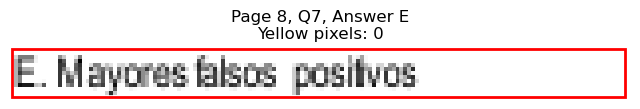


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.6, y0=651.5, x1=125.5, y1=663.6
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 228
Page 8, Q8, A: Yellow percentage: 0.0%


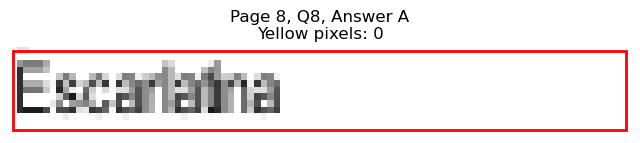

Page 8, Q8 - B: Detected box: x0=71.3, y0=663.5, x1=180.4, y1=675.6
Page 8, Q8, B: Yellow pixels: 834
Page 8, Q8, B: Total non-white pixels: 1391
Page 8, Q8, B: Yellow percentage: 60.0%


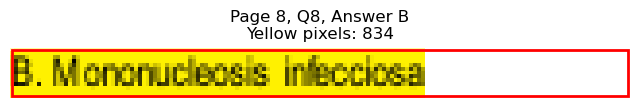

Page 8, Q8 - C: Detected box: x0=71.3, y0=676.3, x1=115.0, y1=688.3
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 295
Page 8, Q8, C: Yellow percentage: 0.0%


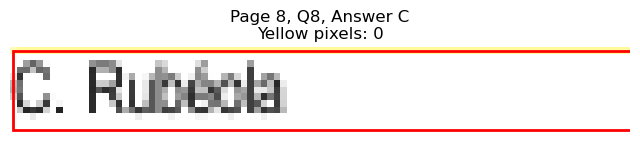

Page 8, Q8 - D: Detected box: x0=322.9, y0=651.5, x1=372.5, y1=663.6
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 246
Page 8, Q8, D: Yellow percentage: 0.0%


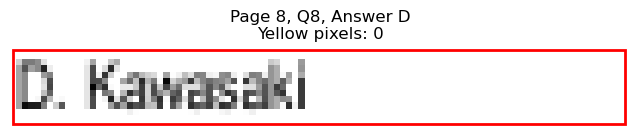

Page 8, Q8 - E: Detected box: x0=322.9, y0=663.5, x1=404.0, y1=675.6
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 395
Page 8, Q8, E: Yellow percentage: 0.0%


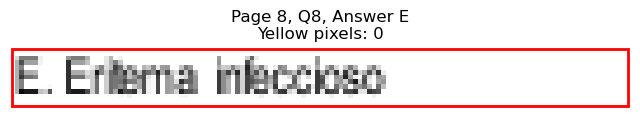


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.6, y0=712.3, x1=151.8, y1=724.4
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 376
Page 8, Q9, A: Yellow percentage: 0.0%


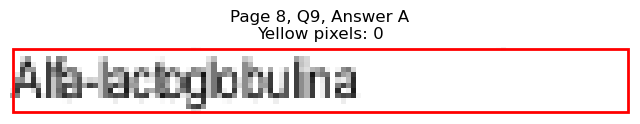

Page 8, Q9 - B: Detected box: x0=71.3, y0=724.3, x1=154.0, y1=736.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 441
Page 8, Q9, B: Yellow percentage: 0.0%


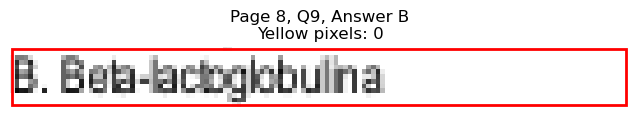

Page 8, Q9 - C: Detected box: x0=71.3, y0=736.4, x1=151.8, y1=748.4
Page 8, Q9, C: Yellow pixels: 686
Page 8, Q9, C: Total non-white pixels: 1027
Page 8, Q9, C: Yellow percentage: 66.8%


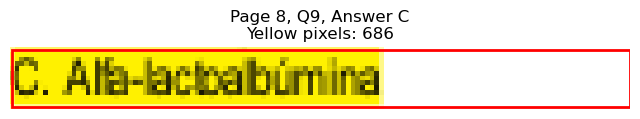

Page 8, Q9 - D: Detected box: x0=322.9, y0=712.3, x1=406.3, y1=724.4
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 436
Page 8, Q9, D: Yellow percentage: 0.0%


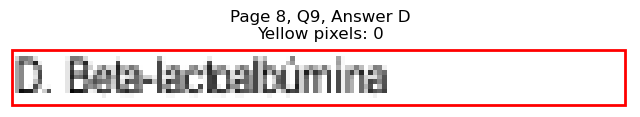

Page 8, Q9 - E: Detected box: x0=322.9, y0=724.3, x1=363.7, y1=736.4
Page 8, Q9, E: Yellow pixels: 0
Page 8, Q9, E: Total non-white pixels: 209
Page 8, Q9, E: Yellow percentage: 0.0%


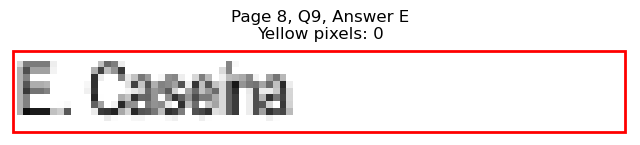


Page 8, Q9 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=142.7, y1=121.6
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 313
Page 9, Q1, A: Yellow percentage: 0.0%


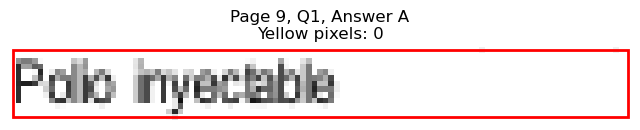

Page 9, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=130.8, y1=133.6
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 313
Page 9, Q1, B: Yellow percentage: 0.0%


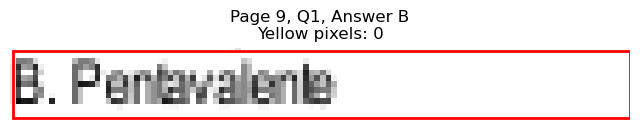

Page 9, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=117.2, y1=145.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 207
Page 9, Q1, C: Yellow percentage: 0.0%


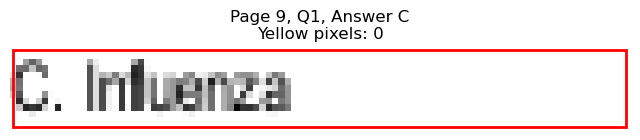

Page 9, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=408.6, y1=121.6
Page 9, Q1, D: Yellow pixels: 766
Page 9, Q1, D: Total non-white pixels: 1105
Page 9, Q1, D: Yellow percentage: 69.3%


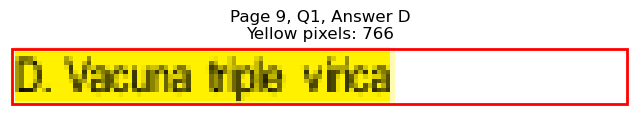

Page 9, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=398.8, y1=133.6
Page 9, Q1, E: Yellow pixels: 83
Page 9, Q1, E: Total non-white pixels: 454
Page 9, Q1, E: Yellow percentage: 18.3%


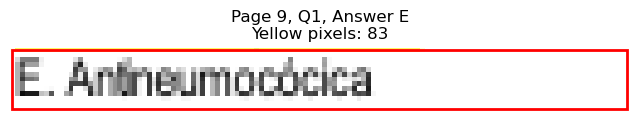


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=150.2, y1=193.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 336
Page 9, Q2, A: Yellow percentage: 0.0%


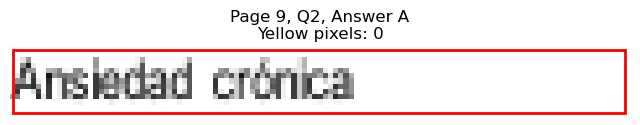

Page 9, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=133.7, y1=205.6
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 325
Page 9, Q2, B: Yellow percentage: 0.0%


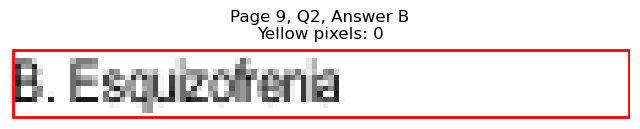

Page 9, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=150.3, y1=217.7
Page 9, Q2, C: Yellow pixels: 631
Page 9, Q2, C: Total non-white pixels: 1001
Page 9, Q2, C: Yellow percentage: 63.0%


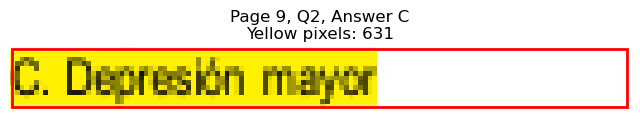

Page 9, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=368.0, y1=193.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 198
Page 9, Q2, D: Yellow percentage: 0.0%


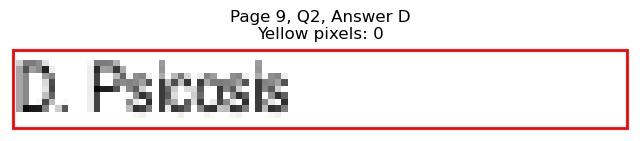

Page 9, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=382.3, y1=205.6
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 290
Page 9, Q2, E: Yellow percentage: 0.0%


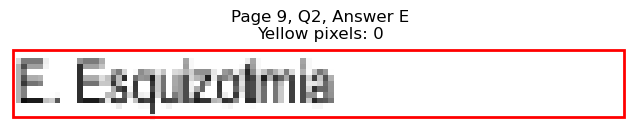


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=141.3, y1=253.7
Page 9, Q3, A: Yellow pixels: 425
Page 9, Q3, A: Total non-white pixels: 741
Page 9, Q3, A: Yellow percentage: 57.4%


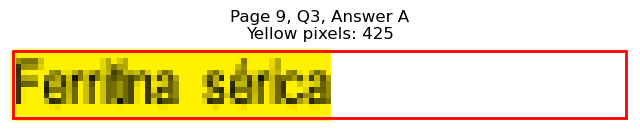

Page 9, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=132.2, y1=265.7
Page 9, Q3, B: Yellow pixels: 56
Page 9, Q3, B: Total non-white pixels: 373
Page 9, Q3, B: Yellow percentage: 15.0%


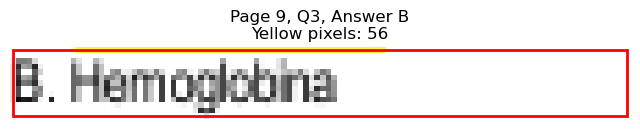

Page 9, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=121.0, y1=277.7
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 236
Page 9, Q3, C: Yellow percentage: 0.0%


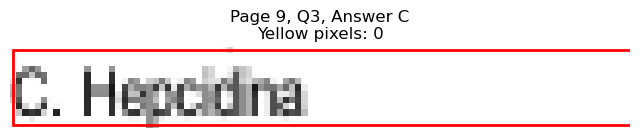

Page 9, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=380.0, y1=253.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 291
Page 9, Q3, D: Yellow percentage: 0.0%


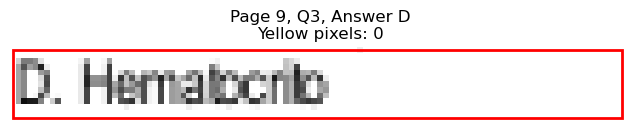

Page 9, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=355.3, y1=265.7
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 133
Page 9, Q3, E: Yellow percentage: 0.0%


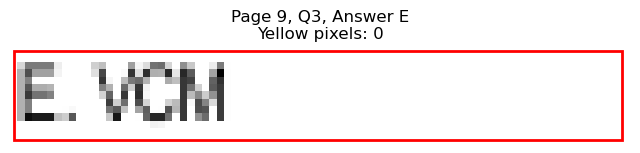


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=338.5, x1=160.7, y1=350.5
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 404
Page 9, Q4, A: Yellow percentage: 0.0%


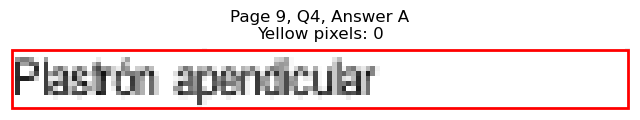

Page 9, Q4 - B: Detected box: x0=71.3, y0=350.5, x1=123.2, y1=362.5
Page 9, Q4, B: Yellow pixels: 693
Page 9, Q4, B: Total non-white pixels: 1014
Page 9, Q4, B: Yellow percentage: 68.3%


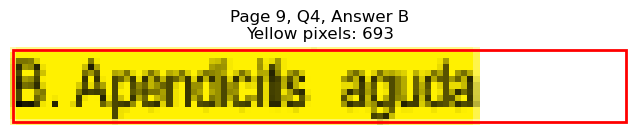

Page 9, Q4 - C: Detected box: x0=71.3, y0=362.5, x1=163.0, y1=374.6
Page 9, Q4, C: Yellow pixels: 78
Page 9, Q4, C: Total non-white pixels: 530
Page 9, Q4, C: Yellow percentage: 14.7%


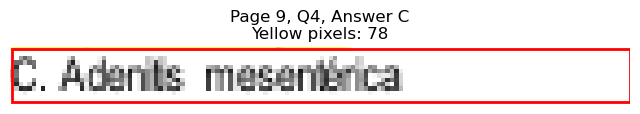

Page 9, Q4 - D: Detected box: x0=322.9, y0=338.5, x1=389.0, y1=350.5
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 483
Page 9, Q4, D: Yellow percentage: 0.0%


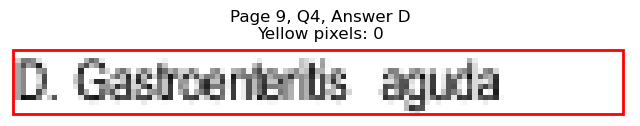

Page 9, Q4 - E: Detected box: x0=322.9, y0=350.5, x1=378.5, y1=362.5
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 491
Page 9, Q4, E: Yellow percentage: 0.0%


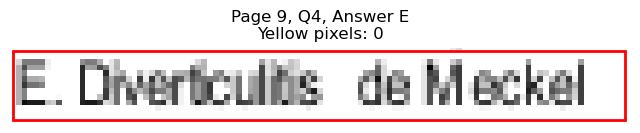


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=422.5, x1=110.5, y1=434.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 131
Page 9, Q5, A: Yellow percentage: 0.0%


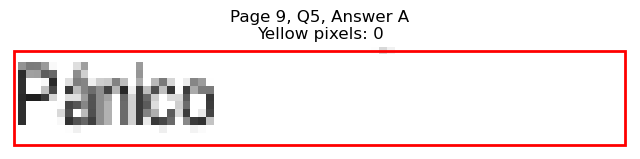

Page 9, Q5 - B: Detected box: x0=71.3, y0=434.6, x1=171.3, y1=446.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 498
Page 9, Q5, B: Yellow percentage: 0.0%


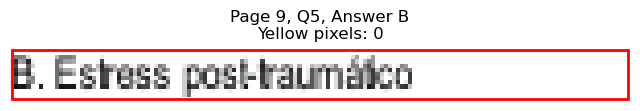

Page 9, Q5 - C: Detected box: x0=71.3, y0=446.6, x1=147.2, y1=458.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 370
Page 9, Q5, C: Yellow percentage: 0.0%


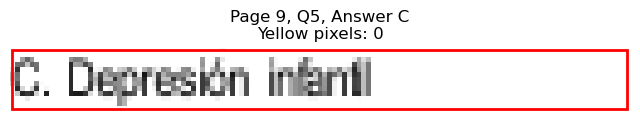

Page 9, Q5 - D: Detected box: x0=322.9, y0=422.5, x1=427.3, y1=434.6
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 518
Page 9, Q5, D: Yellow percentage: 0.0%


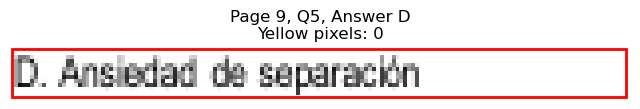

Page 9, Q5 - E: Detected box: x0=322.9, y0=434.6, x1=389.1, y1=446.6
Page 9, Q5, E: Yellow pixels: 532
Page 9, Q5, E: Total non-white pixels: 846
Page 9, Q5, E: Yellow percentage: 62.9%


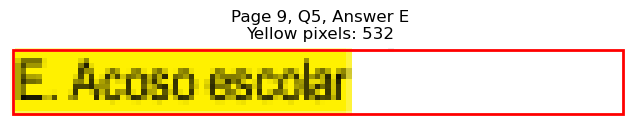


Page 9, Q5 - Selected Answer: E (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=115.6, y0=483.4, x1=262.0, y1=495.4
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 710
Page 9, Q6, A: Yellow percentage: 0.0%


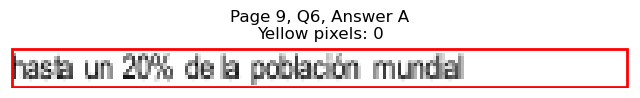

Page 9, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=190.0, y1=507.4
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 816
Page 9, Q6, B: Yellow percentage: 0.0%


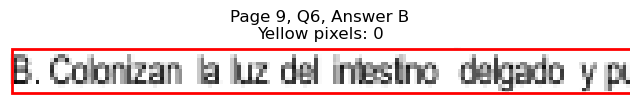

Page 9, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=197.5, y1=531.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 842
Page 9, Q6, C: Yellow percentage: 0.0%


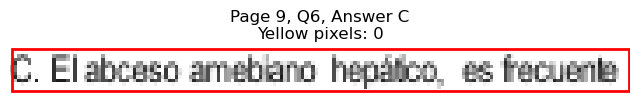

Page 9, Q6 - D: Detected box: x0=379.1, y0=483.4, x1=500.3, y1=495.4
Page 9, Q6, D: Yellow pixels: 1086
Page 9, Q6, D: Total non-white pixels: 1547
Page 9, Q6, D: Yellow percentage: 70.2%


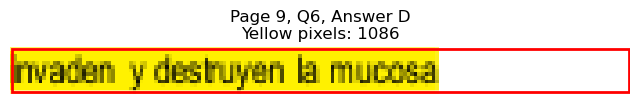

Page 9, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=466.5, y1=507.4
Page 9, Q6, E: Yellow pixels: 174
Page 9, Q6, E: Total non-white pixels: 872
Page 9, Q6, E: Yellow percentage: 20.0%


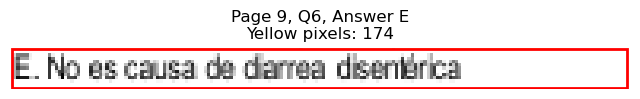


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.6, y0=591.5, x1=154.1, y1=603.5
Page 9, Q7, A: Yellow pixels: 630
Page 9, Q7, A: Total non-white pixels: 913
Page 9, Q7, A: Yellow percentage: 69.0%


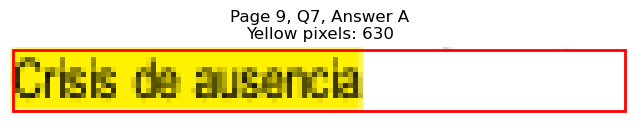

Page 9, Q7 - B: Detected box: x0=71.3, y0=603.5, x1=138.2, y1=615.5
Page 9, Q7, B: Yellow pixels: 69
Page 9, Q7, B: Total non-white pixels: 410
Page 9, Q7, B: Yellow percentage: 16.8%


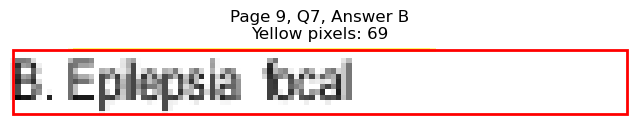

Page 9, Q7 - C: Detected box: x0=71.3, y0=615.5, x1=160.7, y1=627.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 434
Page 9, Q7, C: Yellow percentage: 0.0%


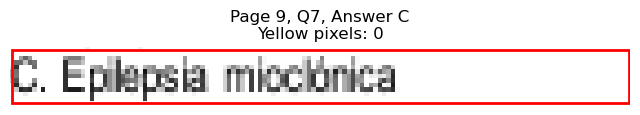

Page 9, Q7 - D: Detected box: x0=322.9, y0=591.5, x1=407.0, y1=603.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 408
Page 9, Q7, D: Yellow percentage: 0.0%


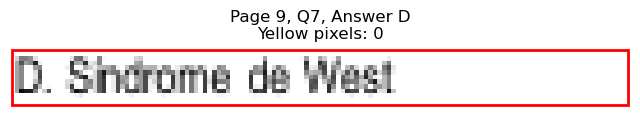

Page 9, Q7 - E: Detected box: x0=322.9, y0=603.5, x1=445.4, y1=615.5
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 590
Page 9, Q7, E: Yellow percentage: 0.0%


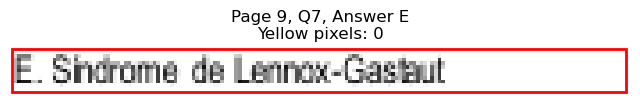


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=147.9, y0=651.5, x1=217.1, y1=663.6
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 518
Page 9, Q8, A: Yellow percentage: 0.0%


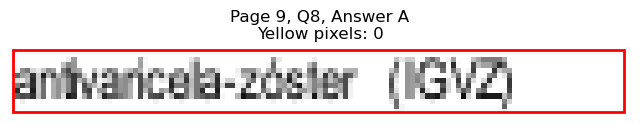

Page 9, Q8 - B: Detected box: x0=71.3, y0=663.5, x1=247.2, y1=675.6
Page 9, Q8, B: Yellow pixels: 1402
Page 9, Q8, B: Total non-white pixels: 2262
Page 9, Q8, B: Yellow percentage: 62.0%


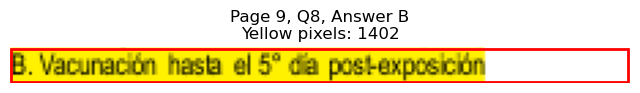

Page 9, Q8 - C: Detected box: x0=71.3, y0=676.3, x1=144.3, y1=688.3
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 723
Page 9, Q8, C: Yellow percentage: 0.0%


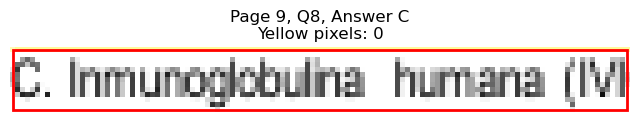

Page 9, Q8 - D: Detected box: x0=322.9, y0=651.5, x1=422.0, y1=663.6
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 481
Page 9, Q8, D: Yellow percentage: 0.0%


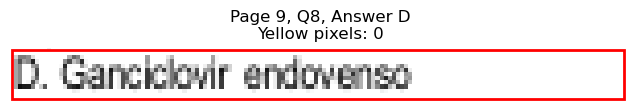

Page 9, Q8 - E: Detected box: x0=322.9, y0=663.5, x1=415.3, y1=675.6
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 443
Page 9, Q8, E: Yellow percentage: 0.0%


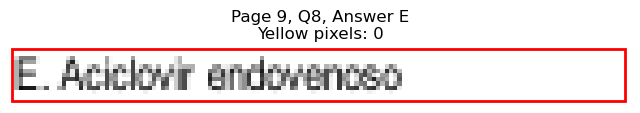


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=82.6, y0=724.3, x1=169.0, y1=736.4
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 558
Page 9, Q9, A: Yellow percentage: 0.0%


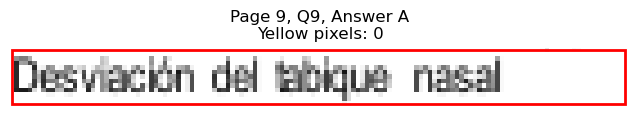

Page 9, Q9 - B: Detected box: x0=71.3, y0=736.4, x1=140.5, y1=748.4
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 338
Page 9, Q9, B: Yellow percentage: 0.0%


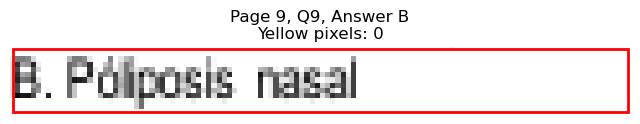

Page 9, Q9 - C: Detected box: x0=71.3, y0=748.4, x1=115.0, y1=760.4
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 196
Page 9, Q9, C: Yellow percentage: 0.0%


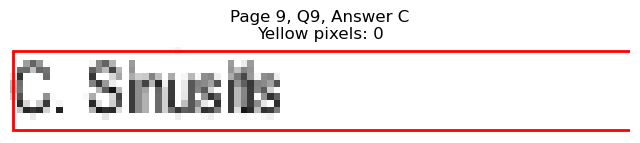

Page 9, Q9 - D: Detected box: x0=322.9, y0=724.3, x1=388.3, y1=736.4
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 327
Page 9, Q9, D: Yellow percentage: 0.0%


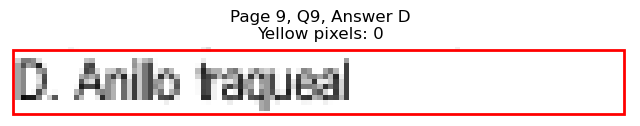

Page 9, Q9 - E: Detected box: x0=322.9, y0=736.4, x1=371.8, y1=748.4
Page 9, Q9, E: Yellow pixels: 772
Page 9, Q9, E: Total non-white pixels: 1196
Page 9, Q9, E: Yellow percentage: 64.5%


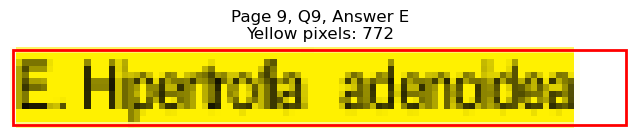


Page 9, Q9 - Selected Answer: E (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=103.8, y1=108.8
Page 10, Q1, A: Yellow pixels: 151
Page 10, Q1, A: Total non-white pixels: 260
Page 10, Q1, A: Yellow percentage: 58.1%


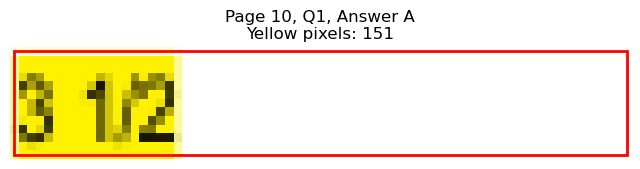

Page 10, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=88.7, y1=121.6
Page 10, Q1, B: Yellow pixels: 18
Page 10, Q1, B: Total non-white pixels: 91
Page 10, Q1, B: Yellow percentage: 19.8%


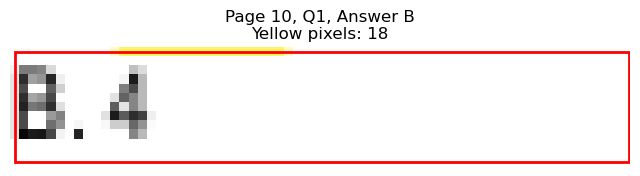

Page 10, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=103.0, y1=133.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 115
Page 10, Q1, C: Yellow percentage: 0.0%


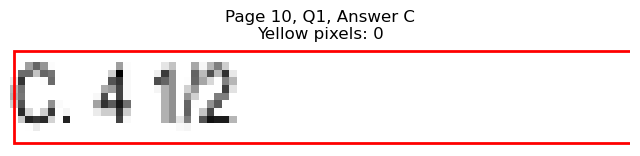

Page 10, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=341.0, y1=108.8
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 69
Page 10, Q1, D: Yellow percentage: 0.0%


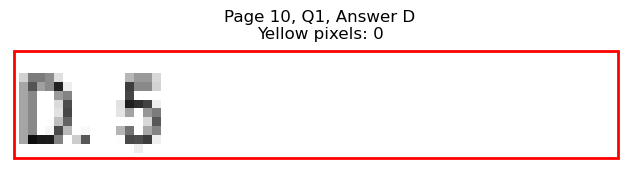

Page 10, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=354.5, y1=121.6
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 121
Page 10, Q1, E: Yellow percentage: 0.0%


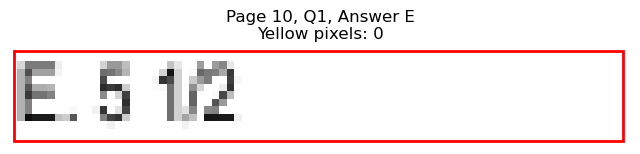


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=134.4, y0=157.6, x1=255.2, y1=169.6
Page 10, Q2, A: Yellow pixels: 959
Page 10, Q2, A: Total non-white pixels: 1561
Page 10, Q2, A: Yellow percentage: 61.4%


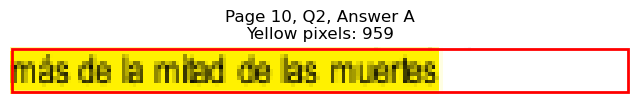

Page 10, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=202.7, y1=193.6
Page 10, Q2, B: Yellow pixels: 39
Page 10, Q2, B: Total non-white pixels: 656
Page 10, Q2, B: Yellow percentage: 5.9%


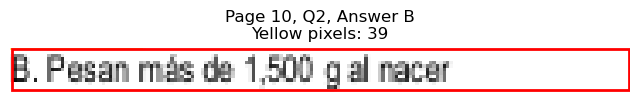

Page 10, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=264.2, y1=205.6
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 939
Page 10, Q2, C: Yellow percentage: 0.0%


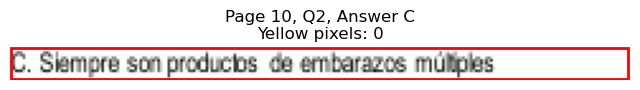

Page 10, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=478.3, y1=169.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 835
Page 10, Q2, D: Yellow percentage: 0.0%


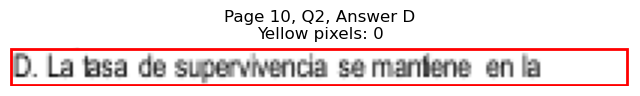

Page 10, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=502.2, y1=193.6
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 867
Page 10, Q2, E: Yellow percentage: 0.0%


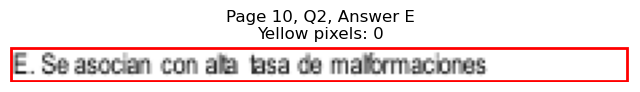


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=137.5, y1=265.7
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 285
Page 10, Q3, A: Yellow percentage: 0.0%


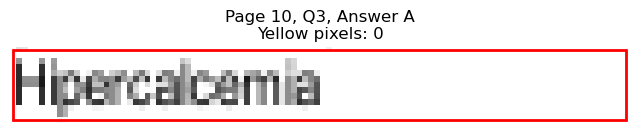

Page 10, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=151.7, y1=277.7
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 426
Page 10, Q3, B: Yellow percentage: 0.0%


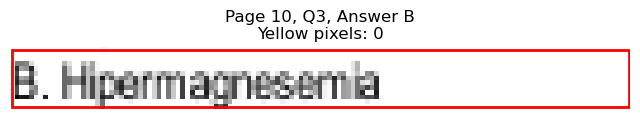

Page 10, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=131.5, y1=289.7
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 297
Page 10, Q3, C: Yellow percentage: 0.0%


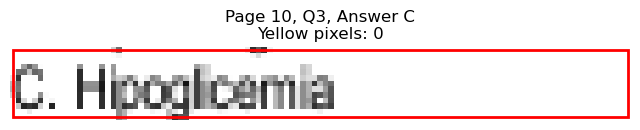

Page 10, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=386.1, y1=265.7
Page 10, Q3, D: Yellow pixels: 475
Page 10, Q3, D: Total non-white pixels: 806
Page 10, Q3, D: Yellow percentage: 58.9%


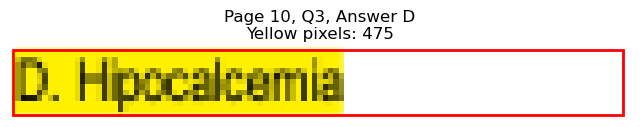

Page 10, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=383.8, y1=277.7
Page 10, Q3, E: Yellow pixels: 61
Page 10, Q3, E: Total non-white pixels: 358
Page 10, Q3, E: Yellow percentage: 17.0%


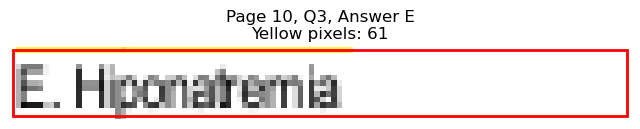


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=142.0, y1=326.5
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 302
Page 10, Q4, A: Yellow percentage: 0.0%


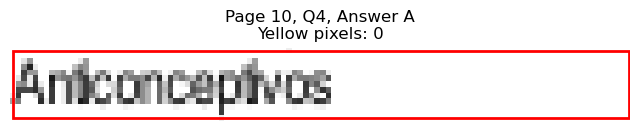

Page 10, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=124.8, y1=338.5
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 270
Page 10, Q4, B: Yellow percentage: 0.0%


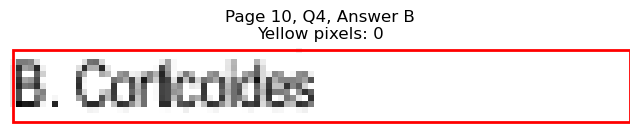

Page 10, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=111.3, y1=350.5
Page 10, Q4, C: Yellow pixels: 343
Page 10, Q4, C: Total non-white pixels: 494
Page 10, Q4, C: Yellow percentage: 69.4%


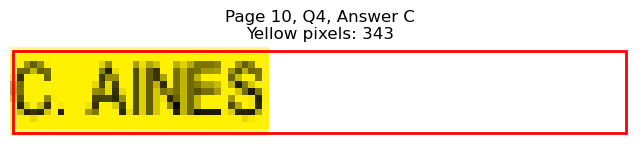

Page 10, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=393.5, y1=326.5
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 366
Page 10, Q4, D: Yellow percentage: 0.0%


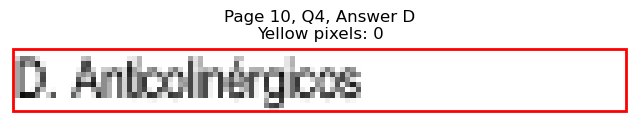

Page 10, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=395.0, y1=338.5
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 353
Page 10, Q4, E: Yellow percentage: 0.0%


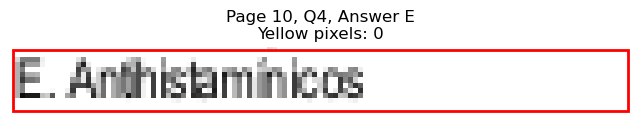


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=94.0, y1=386.6
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 51
Page 10, Q5, A: Yellow percentage: 0.0%


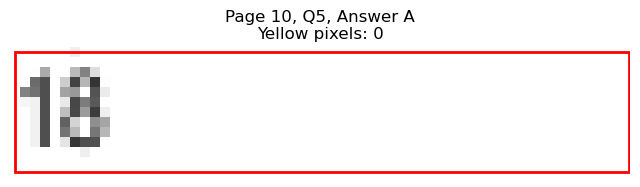

Page 10, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=93.2, y1=398.6
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 83
Page 10, Q5, B: Yellow percentage: 0.0%


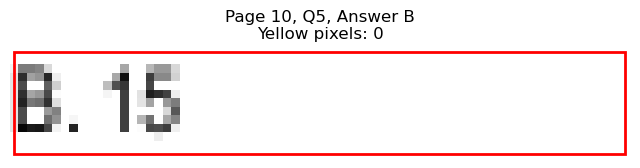

Page 10, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=94.0, y1=410.6
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 72
Page 10, Q5, C: Yellow percentage: 0.0%


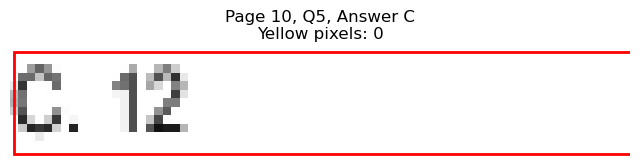

Page 10, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=345.6, y1=386.6
Page 10, Q5, D: Yellow pixels: 181
Page 10, Q5, D: Total non-white pixels: 286
Page 10, Q5, D: Yellow percentage: 63.3%


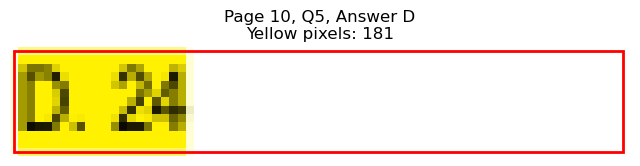

Page 10, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=344.8, y1=398.6
Page 10, Q5, E: Yellow pixels: 20
Page 10, Q5, E: Total non-white pixels: 115
Page 10, Q5, E: Yellow percentage: 17.4%


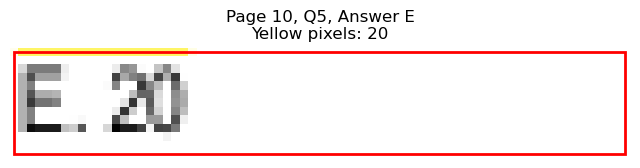


Page 10, Q5 - Selected Answer: D (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=155.5, y1=470.6
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 376
Page 10, Q6, A: Yellow percentage: 0.0%


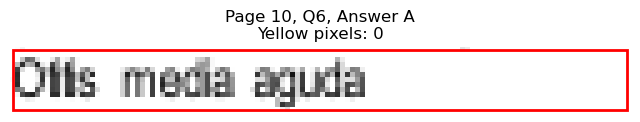

Page 10, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=120.2, y1=482.6
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 247
Page 10, Q6, B: Yellow percentage: 0.0%


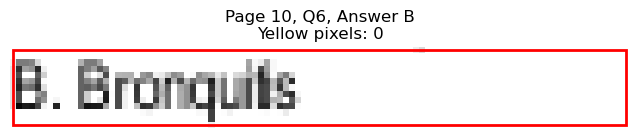

Page 10, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=115.0, y1=495.4
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 195
Page 10, Q6, C: Yellow percentage: 0.0%


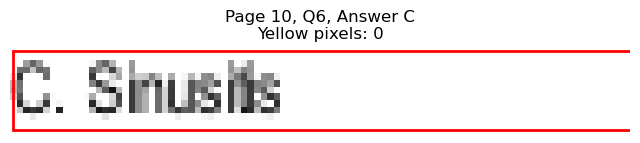

Page 10, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=395.8, y1=470.6
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 376
Page 10, Q6, D: Yellow percentage: 0.0%


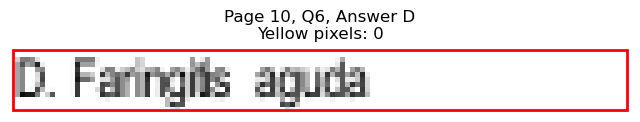

Page 10, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=361.3, y1=482.6
Page 10, Q6, E: Yellow pixels: 550
Page 10, Q6, E: Total non-white pixels: 871
Page 10, Q6, E: Yellow percentage: 63.1%


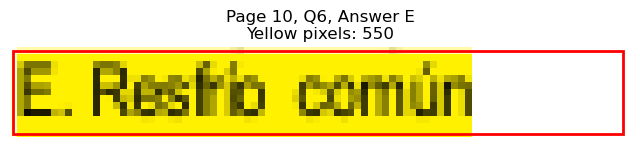


Page 10, Q6 - Selected Answer: E (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=160.8, y1=531.4
Page 10, Q7, A: Yellow pixels: 665
Page 10, Q7, A: Total non-white pixels: 1002
Page 10, Q7, A: Yellow percentage: 66.4%


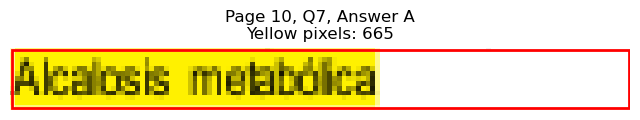

Page 10, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=161.4, y1=543.5
Page 10, Q7, B: Yellow pixels: 75
Page 10, Q7, B: Total non-white pixels: 528
Page 10, Q7, B: Yellow percentage: 14.2%


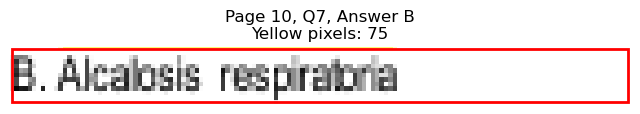

Page 10, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=158.5, y1=555.5
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 434
Page 10, Q7, C: Yellow percentage: 0.0%


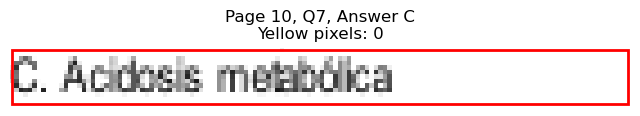

Page 10, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=411.5, y1=531.4
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 431
Page 10, Q7, D: Yellow percentage: 0.0%


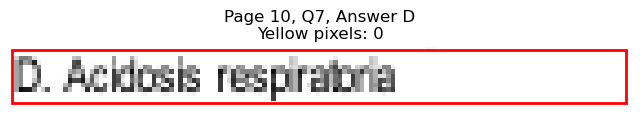

Page 10, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=392.0, y1=543.5
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 332
Page 10, Q7, E: Yellow percentage: 0.0%


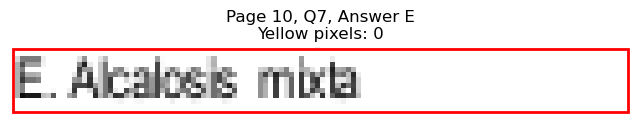


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.6, y0=603.5, x1=190.7, y1=615.5
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 551
Page 10, Q8, A: Yellow percentage: 0.0%


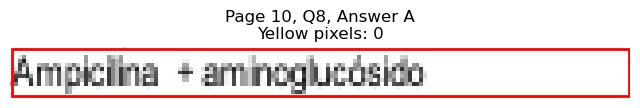

Page 10, Q8 - B: Detected box: x0=71.3, y0=615.5, x1=195.2, y1=627.5
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 629
Page 10, Q8, B: Yellow percentage: 0.0%


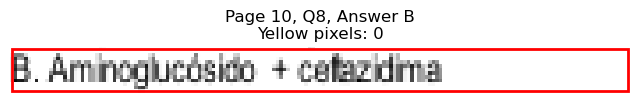

Page 10, Q8 - C: Detected box: x0=71.3, y0=627.5, x1=180.2, y1=639.6
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 514
Page 10, Q8, C: Yellow percentage: 0.0%


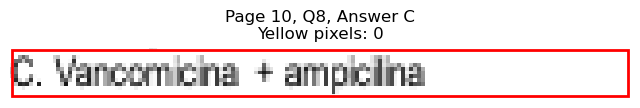

Page 10, Q8 - D: Detected box: x0=322.9, y0=603.5, x1=436.4, y1=615.5
Page 10, Q8, D: Yellow pixels: 1006
Page 10, Q8, D: Total non-white pixels: 1469
Page 10, Q8, D: Yellow percentage: 68.5%


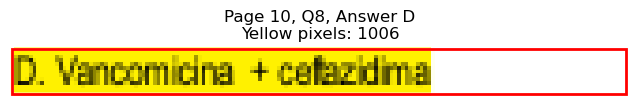

Page 10, Q8 - E: Detected box: x0=322.9, y0=615.5, x1=437.8, y1=627.5
Page 10, Q8, E: Yellow pixels: 111
Page 10, Q8, E: Total non-white pixels: 676
Page 10, Q8, E: Yellow percentage: 16.4%


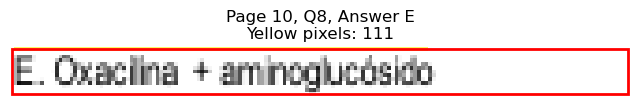


Page 10, Q8 - Selected Answer: D (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=124.0, y1=712.3
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 356
Page 10, Q9, A: Yellow percentage: 0.0%


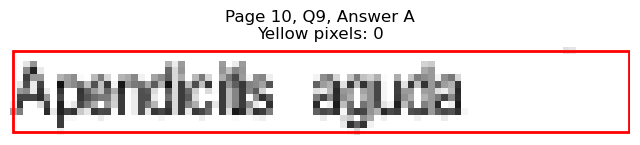

Page 10, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=136.7, y1=724.4
Page 10, Q9, B: Yellow pixels: 725
Page 10, Q9, B: Total non-white pixels: 1196
Page 10, Q9, B: Yellow percentage: 60.6%


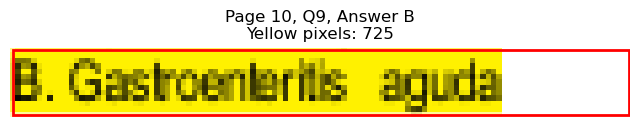

Page 10, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=145.0, y1=736.4
Page 10, Q9, C: Yellow pixels: 2
Page 10, Q9, C: Total non-white pixels: 613
Page 10, Q9, C: Yellow percentage: 0.3%


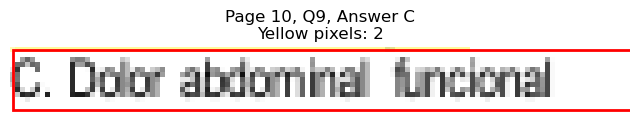

Page 10, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=400.3, y1=712.3
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 363
Page 10, Q9, D: Yellow percentage: 0.0%


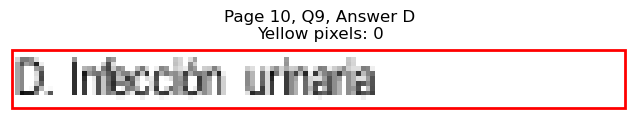

Page 10, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=373.3, y1=724.4
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 399
Page 10, Q9, E: Yellow percentage: 0.0%


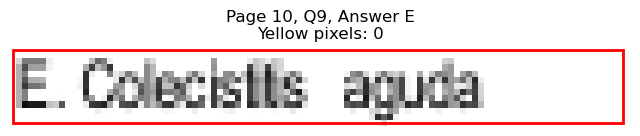


Page 10, Q9 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 9 questions
Page 11, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=163.8, y1=121.6
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 408
Page 11, Q1, A: Yellow percentage: 0.0%


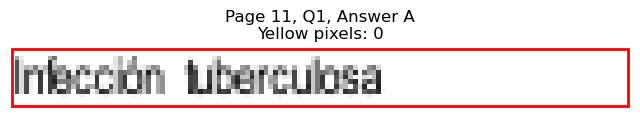

Page 11, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=166.0, y1=133.6
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 490
Page 11, Q1, B: Yellow percentage: 0.0%


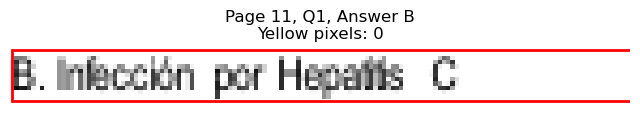

Page 11, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=156.2, y1=145.6
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 376
Page 11, Q1, C: Yellow percentage: 0.0%


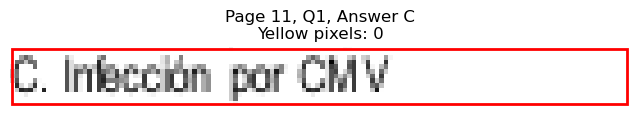

Page 11, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=401.9, y1=121.6
Page 11, Q1, D: Yellow pixels: 710
Page 11, Q1, D: Total non-white pixels: 1014
Page 11, Q1, D: Yellow percentage: 70.0%


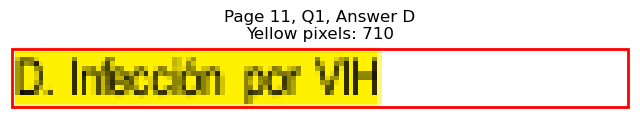

Page 11, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=404.0, y1=133.6
Page 11, Q1, E: Yellow pixels: 76
Page 11, Q1, E: Total non-white pixels: 478
Page 11, Q1, E: Yellow percentage: 15.9%


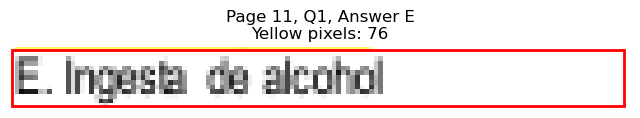


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=148.8, y1=205.6
Page 11, Q2, A: Yellow pixels: 496
Page 11, Q2, A: Total non-white pixels: 845
Page 11, Q2, A: Yellow percentage: 58.7%


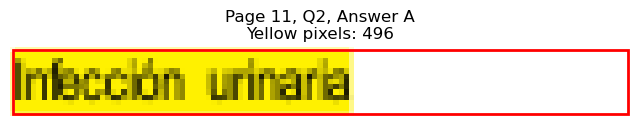

Page 11, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=152.5, y1=217.7
Page 11, Q2, B: Yellow pixels: 63
Page 11, Q2, B: Total non-white pixels: 477
Page 11, Q2, B: Yellow percentage: 13.2%


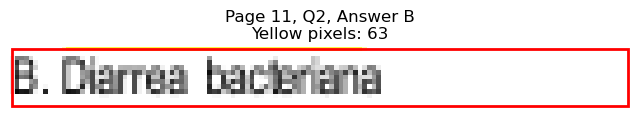

Page 11, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=126.2, y1=229.7
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 469
Page 11, Q2, C: Yellow percentage: 0.0%


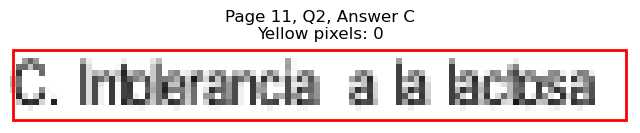

Page 11, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=379.3, y1=205.6
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 491
Page 11, Q2, D: Yellow percentage: 0.0%


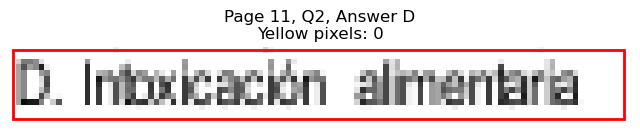

Page 11, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=365.0, y1=217.7
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 204
Page 11, Q2, E: Yellow percentage: 0.0%


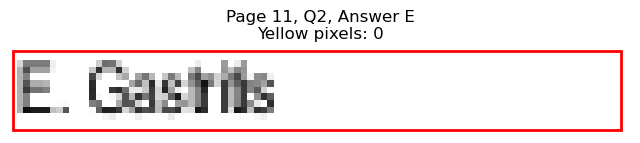


Page 11, Q2 - Selected Answer: A (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=103.8, y1=265.7
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 93
Page 11, Q3, A: Yellow percentage: 0.0%


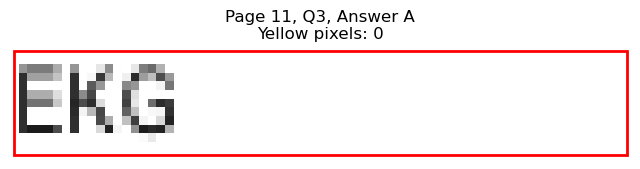

Page 11, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=102.9, y1=277.7
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 143
Page 11, Q3, B: Yellow percentage: 0.0%


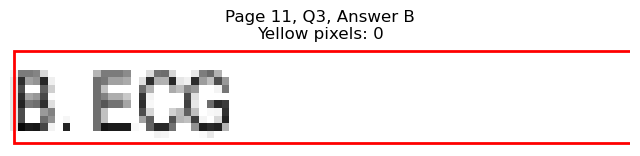

Page 11, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=156.3, y1=289.7
Page 11, Q3, C: Yellow pixels: 673
Page 11, Q3, C: Total non-white pixels: 1079
Page 11, Q3, C: Yellow percentage: 62.4%


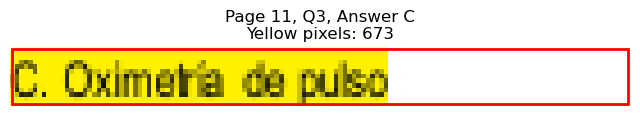

Page 11, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=356.8, y1=265.7
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 165
Page 11, Q3, D: Yellow percentage: 0.0%


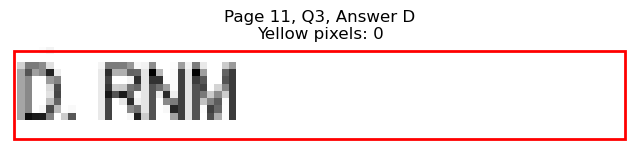

Page 11, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=368.0, y1=277.7
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 197
Page 11, Q3, E: Yellow percentage: 0.0%


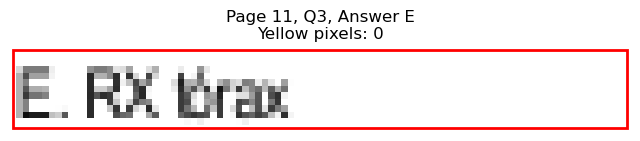


Page 11, Q3 - Selected Answer: C (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=103.0, y1=326.5
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 118
Page 11, Q4, A: Yellow percentage: 0.0%


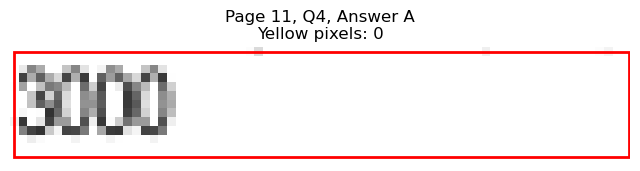

Page 11, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=102.3, y1=338.5
Page 11, Q4, B: Yellow pixels: 259
Page 11, Q4, B: Total non-white pixels: 377
Page 11, Q4, B: Yellow percentage: 68.7%


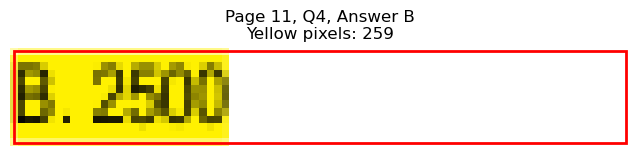

Page 11, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=103.0, y1=350.5
Page 11, Q4, C: Yellow pixels: 29
Page 11, Q4, C: Total non-white pixels: 171
Page 11, Q4, C: Yellow percentage: 17.0%


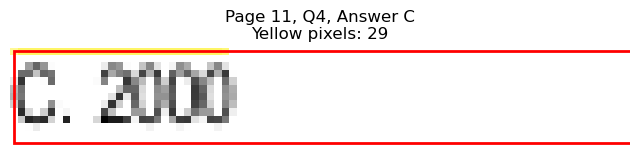

Page 11, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=354.5, y1=326.5
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 148
Page 11, Q4, D: Yellow percentage: 0.0%


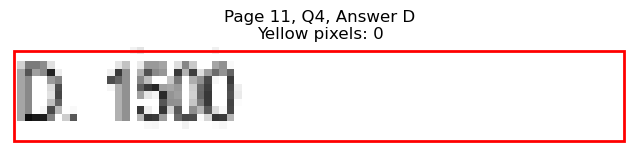

Page 11, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=353.8, y1=338.5
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 142
Page 11, Q4, E: Yellow percentage: 0.0%


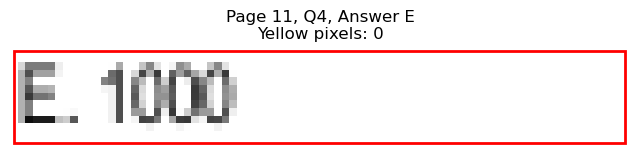


Page 11, Q4 - Selected Answer: B (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=115.0, y1=398.6
Page 11, Q5, A: Yellow pixels: 222
Page 11, Q5, A: Total non-white pixels: 403
Page 11, Q5, A: Yellow percentage: 55.1%


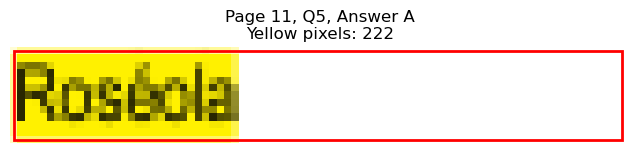

Page 11, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=124.7, y1=410.6
Page 11, Q5, B: Yellow pixels: 30
Page 11, Q5, B: Total non-white pixels: 304
Page 11, Q5, B: Yellow percentage: 9.9%


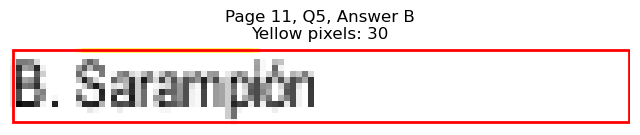

Page 11, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=152.5, y1=422.6
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 376
Page 11, Q5, C: Yellow percentage: 0.0%


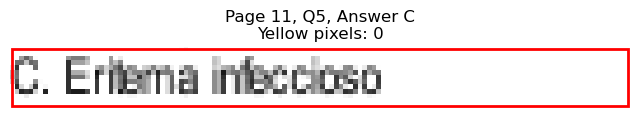

Page 11, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=377.0, y1=398.6
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 272
Page 11, Q5, D: Yellow percentage: 0.0%


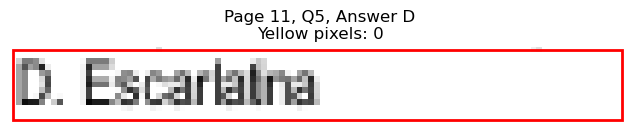

Page 11, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=365.8, y1=410.6
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 212
Page 11, Q5, E: Yellow percentage: 0.0%


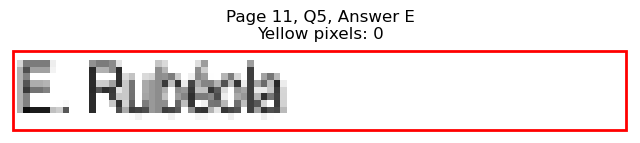


Page 11, Q5 - Selected Answer: A (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=103.0, y1=482.6
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 86
Page 11, Q6, A: Yellow percentage: 0.0%


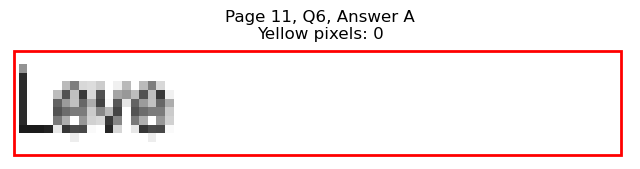

Page 11, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=122.5, y1=495.4
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 259
Page 11, Q6, B: Yellow percentage: 0.0%


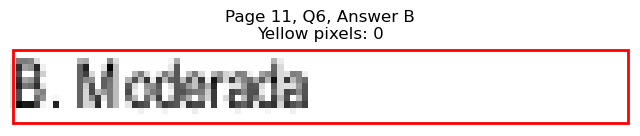

Page 11, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=146.4, y1=507.4
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 327
Page 11, Q6, C: Yellow percentage: 0.0%


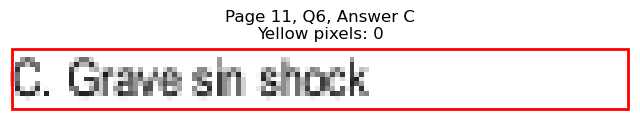

Page 11, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=406.4, y1=482.6
Page 11, Q6, D: Yellow pixels: 663
Page 11, Q6, D: Total non-white pixels: 1066
Page 11, Q6, D: Yellow percentage: 62.2%


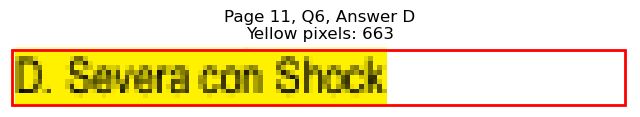

Page 11, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=401.7, y1=495.4
Page 11, Q6, E: Yellow pixels: 81
Page 11, Q6, E: Total non-white pixels: 443
Page 11, Q6, E: Yellow percentage: 18.3%


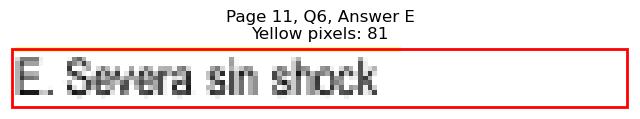


Page 11, Q6 - Selected Answer: D (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=128.5, y1=555.5
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 214
Page 11, Q7, A: Yellow percentage: 0.0%


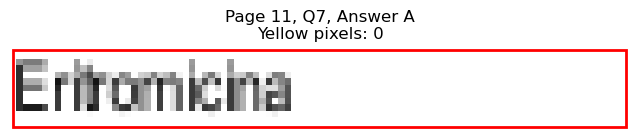

Page 11, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=132.2, y1=567.5
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 289
Page 11, Q7, B: Yellow percentage: 0.0%


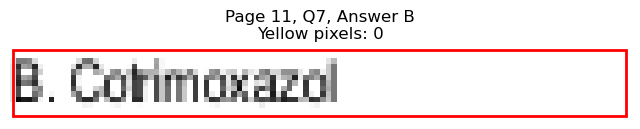

Page 11, Q7 - C: Detected box: x0=71.3, y0=567.5, x1=131.5, y1=579.5
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 285
Page 11, Q7, C: Yellow percentage: 0.0%


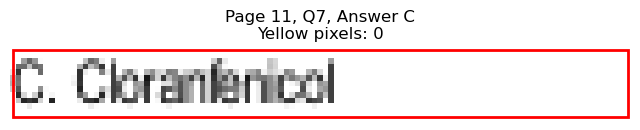

Page 11, Q7 - D: Detected box: x0=322.9, y0=543.4, x1=377.1, y1=555.5
Page 11, Q7, D: Yellow pixels: 452
Page 11, Q7, D: Total non-white pixels: 689
Page 11, Q7, D: Yellow percentage: 65.6%


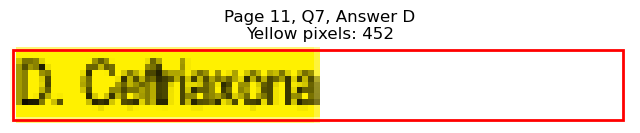

Page 11, Q7 - E: Detected box: x0=322.9, y0=555.4, x1=377.0, y1=567.5
Page 11, Q7, E: Yellow pixels: 51
Page 11, Q7, E: Total non-white pixels: 321
Page 11, Q7, E: Yellow percentage: 15.9%


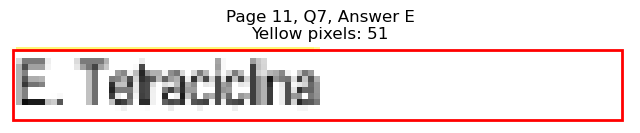


Page 11, Q7 - Selected Answer: D (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=82.6, y0=603.5, x1=127.0, y1=615.5
Page 11, Q8, A: Yellow pixels: 390
Page 11, Q8, A: Total non-white pixels: 563
Page 11, Q8, A: Yellow percentage: 69.3%


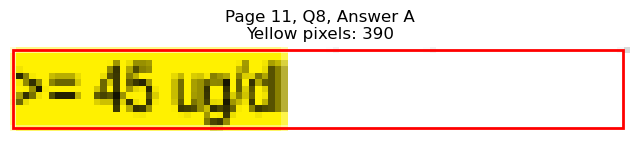

Page 11, Q8 - B: Detected box: x0=71.3, y0=615.5, x1=126.2, y1=627.5
Page 11, Q8, B: Yellow pixels: 42
Page 11, Q8, B: Total non-white pixels: 276
Page 11, Q8, B: Yellow percentage: 15.2%


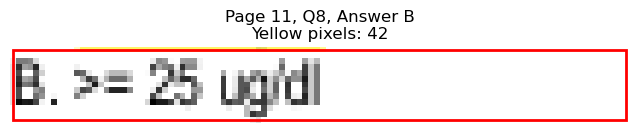

Page 11, Q8 - C: Detected box: x0=71.3, y0=627.5, x1=126.3, y1=639.6
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 229
Page 11, Q8, C: Yellow percentage: 0.0%


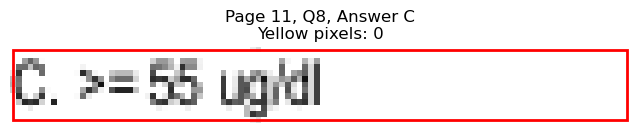

Page 11, Q8 - D: Detected box: x0=322.9, y0=603.5, x1=377.8, y1=615.5
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 248
Page 11, Q8, D: Yellow percentage: 0.0%


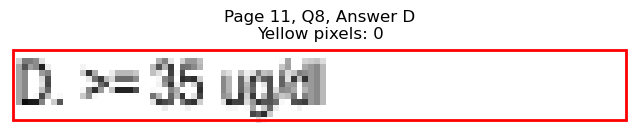

Page 11, Q8 - E: Detected box: x0=322.9, y0=615.5, x1=377.8, y1=627.5
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 247
Page 11, Q8, E: Yellow percentage: 0.0%


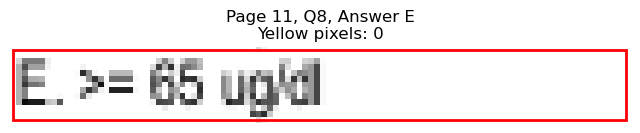


Page 11, Q8 - Selected Answer: A (based on yellow pixel count)




Page 11, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=154.8, y1=712.3
Page 11, Q9, A: Yellow pixels: 540
Page 11, Q9, A: Total non-white pixels: 923
Page 11, Q9, A: Yellow percentage: 58.5%


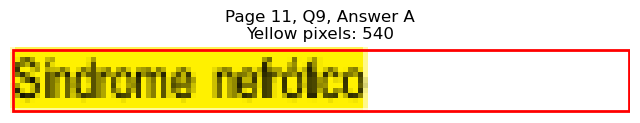

Page 11, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=151.0, y1=724.4
Page 11, Q9, B: Yellow pixels: 0
Page 11, Q9, B: Total non-white pixels: 467
Page 11, Q9, B: Yellow percentage: 0.0%


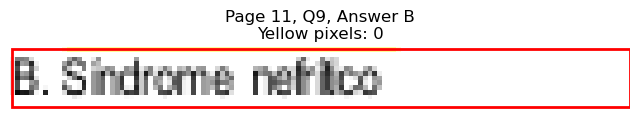

Page 11, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=129.2, y1=736.4
Page 11, Q9, C: Yellow pixels: 0
Page 11, Q9, C: Total non-white pixels: 514
Page 11, Q9, C: Yellow percentage: 0.0%


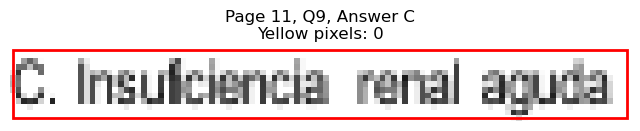

Page 11, Q9 - D: Detected box: x0=383.6, y0=700.3, x1=460.3, y1=712.3
Page 11, Q9, D: Yellow pixels: 0
Page 11, Q9, D: Total non-white pixels: 402
Page 11, Q9, D: Yellow percentage: 0.0%


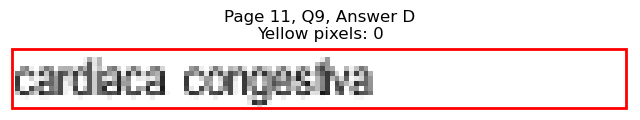

Page 11, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=380.0, y1=724.4
Page 11, Q9, E: Yellow pixels: 0
Page 11, Q9, E: Total non-white pixels: 525
Page 11, Q9, E: Yellow percentage: 0.0%


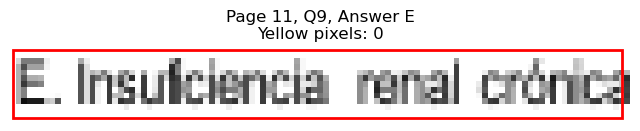


Page 11, Q9 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Recién nacido, con expresión alerta, que prese...
1   ¿Cuál es el riesgo de anomalías congénitas en ...
2   ¿Cuál es el tratamiento inicial de la hipoglic...
3   En el recién nacido, durante la maniobra de re...
4   ¿Cuál es la región del encéfalo que más se afe...
..                                                ...
95  Lactante de 11 meses, presenta durante 3 días ...
96  Lactante de 6 meses, con fiebre, diarrea acuos...
97  Recién nacido, con inyección conjuntival y sec...
98  En intoxicación por plomo. ¿A partir de que co...
99  Pre-escolar de 5 años, con anasarca, oliguria ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                  option_B  \
0                        39                        40   
1                       30%                       20%   
2   Glucosa al 5% 2mL/kg EV  Glucosa al 10% 2mL/kg VO   
3                        15                        60   
4             Área temporal          Corteza cerebral   
..                      ...                       ...   
95                  Roséola                 Sarampión   
96                     Leve                  Moderada   
97             Eritromicina              Cotrimoxazol   
98              >= 45 ug/dl               >= 25 ug/dl   
99       Síndrome nefrótico        Síndrome nefrítico   

                     option_C                           option_D  \
0                          42                                 38   
1                         15%                                10%   
2     Glucosa al 5% 2mL/kg VO           Glucosa al 10% 2mL/kg EV   
3                          40                                 20   
4                  Hipotálamo                  Tronco encefálico   
..                        ...                                ...   
95         Eritema infeccioso                        Escarlatina   
96            Grave sin shock                   Severa con Shock   
97              Cloranfenicol                        Ceftriaxona   
98                >= 55 ug/dl                        >= 35 ug/dl   
99  Insuficiencia renal aguda  Insuficiencia cardiaca congestiva   

                           option_E  
0                                37  
1                                5%  
2   Alimentación con fórmula láctea  
3                                30  
4                    Área occipital  
..                              ...  
95                          Rubéola  
96                 Severa sin shock  
97                     Tetraciclina  
98                      >= 65 ug/dl  
99      Insuficiencia renal crónica  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               A
2               D
3               E
4               D
..            ...
95              A
96              D
97              D
98              A
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Recién nacido, con expresión alerta, que prese...   
1   ¿Cuál es el riesgo de anomalías congénitas en ...   
2   ¿Cuál es el tratamiento inicial de la hipoglic...   
3   En el recién nacido, durante la maniobra de re...   
4   ¿Cuál es la región del encéfalo que más se afe...   
..                                                ...   
95  Lactante de 11 meses, presenta durante 3 días ...   
96  Lactante de 6 meses, con fiebre, diarrea acuos...   
97  Recién nacido, con inyección conjuntival y sec...   
98  En intoxicación por plomo. ¿A partir de que co...   
99  Pre-escolar de 5 años, con anasarca, oliguria ...   

                   option_A                  option_B  \
0                        39                        40   
1                       30%                       20%   
2   Glucosa al 5% 2mL/kg EV  Glucosa al 10% 2mL/kg VO   
3                        15                        60   
4             Área temporal          Corteza cerebral   
..                      ...                       ...   
95                  Roséola                 Sarampión   
96                     Leve                  Moderada   
97             Eritromicina              Cotrimoxazol   
98              >= 45 ug/dl               >= 25 ug/dl   
99       Síndrome nefrótico        Síndrome nefrítico   

                     option_C                           option_D  \
0                          42                                 38   
1                         15%                                10%   
2     Glucosa al 5% 2mL/kg VO           Glucosa al 10% 2mL/kg EV   
3                          40                                 20   
4                  Hipotálamo                  Tronco encefálico   
..                        ...                                ...   
95         Eritema infeccioso                        Escarlatina   
96            Grave sin shock                   Severa con Shock   
97              Cloranfenicol                        Ceftriaxona   
98                >= 55 ug/dl                        >= 35 ug/dl   
99  Insuficiencia renal aguda  Insuficiencia cardiaca congestiva   

                           option_E correct_answer  
0                                37              C  
1                                5%              A  
2   Alimentación con fórmula láctea              D  
3                                30              E  
4                    Área occipital              D  
..                              ...            ...  
95                          Rubéola              A  
96                 Severa sin shock              D  
97                     Tetraciclina              D  
98                      >= 65 ug/dl              A  
99      Insuficiencia renal crónica              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/PEDIATRIA.csv
